# Лабораторная работа №3: Решающие деревья

### Загрузка библиотек и настройка визуализации

In [71]:
# Основные библиотеки для работы с данными
import pandas as pd
import numpy as np
from datetime import datetime

# Визуализация
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch
import seaborn as sns
from matplotlib import rcParams

# Машинное обучение - решающие деревья
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.feature_selection import SelectKBest, f_classif, f_regression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn import tree 
from sklearn.metrics import (confusion_matrix, classification_report, 
                           f1_score, precision_score, recall_score,
                           mean_squared_error, mean_absolute_error,
                           r2_score, mean_absolute_percentage_error, accuracy_score)
                           

# Предупреждения
import warnings
warnings.filterwarnings('ignore')

# Настройка визуализации
plt.style.use('seaborn-v0_8-darkgrid')
rcParams['figure.figsize'] = (12, 6)
rcParams['font.size'] = 12
sns.set_palette("husl")

# Для визуализации деревьев (опционально)
import graphviz
from sklearn.tree import export_graphviz

### Загрузка и анализ датасета для Классификации (Employee Attrition)

Датасет загружен: 1470 строк, 35 столбцов

--- 1.1 Первичный обзор данных ---
Первые 5 строк датасета:
   Age Attrition     BusinessTravel  DailyRate              Department  \
0   41       Yes      Travel_Rarely       1102                   Sales   
1   49        No  Travel_Frequently        279  Research & Development   
2   37       Yes      Travel_Rarely       1373  Research & Development   
3   33        No  Travel_Frequently       1392  Research & Development   
4   27        No      Travel_Rarely        591  Research & Development   

   DistanceFromHome  Education EducationField  EmployeeCount  EmployeeNumber  \
0                 1          2  Life Sciences              1               1   
1                 8          1  Life Sciences              1               2   
2                 2          2          Other              1               4   
3                 3          4  Life Sciences              1               5   
4                 2          1        Medical       

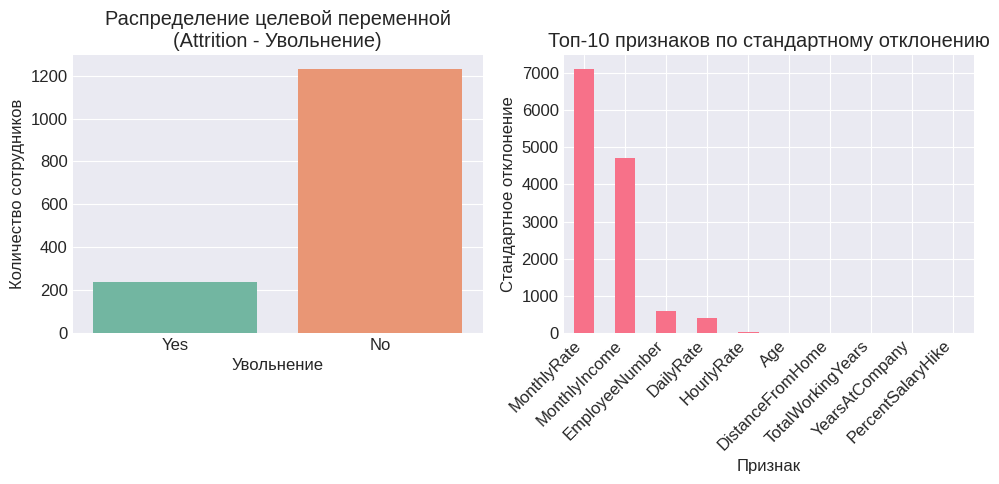


--- 1.7 Корреляционный анализ с целевой переменной ---
Топ-10 признаков по абсолютной корреляции с целевой переменной:
TotalWorkingYears       0.171063
JobLevel                0.169105
YearsInCurrentRole      0.160545
MonthlyIncome           0.159840
Age                     0.159205
YearsWithCurrManager    0.156199
StockOptionLevel        0.137145
YearsAtCompany          0.134392
JobInvolvement          0.130016
JobSatisfaction         0.103481
dtype: float64


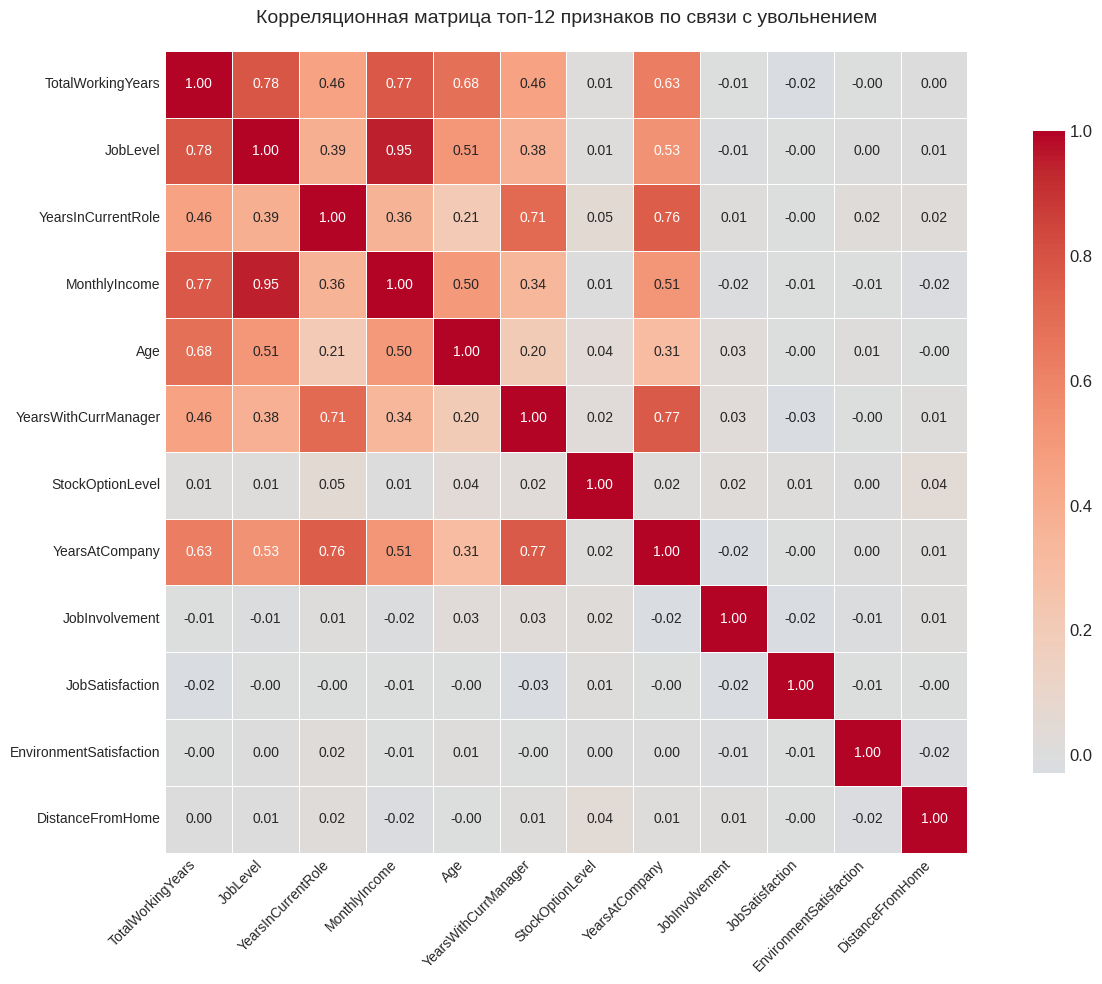

In [2]:
# Ячейка 1: АНАЛИЗ ДАТАСЕТА ДЛЯ КЛАССИФИКАЦИИ - ПРОГНОЗ УВОЛЬНЕНИЙ
# Загрузка датасета
df_class = pd.read_csv('Classification.csv')
print(f"Датасет загружен: {df_class.shape[0]} строк, {df_class.shape[1]} столбцов")

# 1.1 Первичный обзор данных
print("\n--- 1.1 Первичный обзор данных ---")
print("Первые 5 строк датасета:")
print(df_class.head())
print("\nИнформация о типах данных:")
print(df_class.info())

# 1.2 Статистическое описание числовых признаков
print("\n--- 1.2 Статистическое описание числовых признаков ---")
print(df_class.describe())

# 1.3 Проверка пропущенных значений
print("\n--- 1.3 Проверка пропущенных значений ---")
missing_values = df_class.isnull().sum()
missing_percent = (missing_values / len(df_class)) * 100

missing_df = pd.DataFrame({
    'Количество пропусков': missing_values,
    'Процент пропусков': missing_percent
}).sort_values('Количество пропусков', ascending=False)

print(missing_df[missing_df['Количество пропусков'] > 0])
if missing_df[missing_df['Количество пропусков'] > 0].empty:
    print("Пропуски в данных отсутствуют")

# 1.4 Анализ целевой переменной (Attrition)
print("\n--- 1.4 Анализ целевой переменной (Attrition) ---")
target_counts = df_class['Attrition'].value_counts()
target_percent = df_class['Attrition'].value_counts(normalize=True) * 100

print(f"Распределение классов:\n{target_counts}")
print(f"\nПроцентное соотношение:\n{target_percent.round(2)}")

# Визуализация распределения целевой переменной
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.countplot(data=df_class, x='Attrition', palette='Set2')
plt.title('Распределение целевой переменной\n(Attrition - Увольнение)')
plt.xlabel('Увольнение')
plt.ylabel('Количество сотрудников')

# 1.5 Анализ категориальных признаков
print("\n--- 1.5 Анализ категориальных признаков ---")
categorical_cols = df_class.select_dtypes(include=['object']).columns
print(f"Найдено категориальных признаков: {len(categorical_cols)}")

for col in categorical_cols:
    unique_vals = df_class[col].nunique()
    print(f"  {col}: {unique_vals} уникальных значений")

# 1.6 Анализ стандартных отклонений числовых признаков
print("\n--- 1.6 Анализ стандартных отклонений числовых признаков ---")
numeric_cols = df_class.select_dtypes(include=[np.number]).columns
std_dev = df_class[numeric_cols].std()

std_df = pd.DataFrame({
    'Стандартное отклонение': std_dev,
    'Среднее значение': df_class[numeric_cols].mean(),
    'Коэффициент вариации': (std_dev / df_class[numeric_cols].mean() * 100).round(2)
}).sort_values('Стандартное отклонение', ascending=False)

print("Топ-10 признаков с наибольшим стандартным отклонением:")
print(std_df.head(10))

# Визуализация стандартных отклонений
plt.subplot(1, 2, 2)
std_df.head(10)['Стандартное отклонение'].plot(kind='bar')
plt.title('Топ-10 признаков по стандартному отклонению')
plt.xlabel('Признак')
plt.ylabel('Стандартное отклонение')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 1.7 Корреляционный анализ с целевой переменной
print("\n--- 1.7 Корреляционный анализ с целевой переменной ---")
# Преобразование целевой переменной в числовой формат для корреляции
df_class['Attrition_numeric'] = df_class['Attrition'].map({'Yes': 1, 'No': 0})
correlations = df_class[numeric_cols].corrwith(df_class['Attrition_numeric']).abs().sort_values(ascending=False)

print("Топ-10 признаков по абсолютной корреляции с целевой переменной:")
print(correlations.head(10))

# Визуализация корреляционной матрицы
plt.figure(figsize=(14, 10))
top_corr_features = correlations.head(12).index
corr_matrix = df_class[top_corr_features].corr()

# Настройка размера шрифта и формата чисел
annot_kws = {"size": 10, "weight": "normal"}
fmt = '.2f'  # Формат отображения чисел (2 знака после запятой)

heatmap = sns.heatmap(corr_matrix, 
                     annot=True, 
                     fmt=fmt,
                     cmap='coolwarm', 
                     center=0, 
                     square=True, 
                     linewidths=0.5,
                     cbar_kws={"shrink": 0.8},
                     annot_kws=annot_kws)

# Настройка подписей осей
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)

plt.title('Корреляционная матрица топ-12 признаков по связи с увольнением', 
          fontsize=14, pad=20)
plt.tight_layout()
plt.show()

### Загрузка и анализ датасета для Регрессии (House Sales)

Датасет загружен: 21613 строк, 21 столбцов

--- 2.1 Первичный обзор данных ---
Первые 5 строк датасета:
           id             date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  20141013T000000  221900.0         3       1.00         1180   
1  6414100192  20141209T000000  538000.0         3       2.25         2570   
2  5631500400  20150225T000000  180000.0         2       1.00          770   
3  2487200875  20141209T000000  604000.0         4       3.00         1960   
4  1954400510  20150218T000000  510000.0         3       2.00         1680   

   sqft_lot  floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
0      5650     1.0           0     0  ...      7        1180              0   
1      7242     2.0           0     0  ...      7        2170            400   
2     10000     1.0           0     0  ...      6         770              0   
3      5000     1.0           0     0  ...      7        1050            910   
4      8080     1.0        

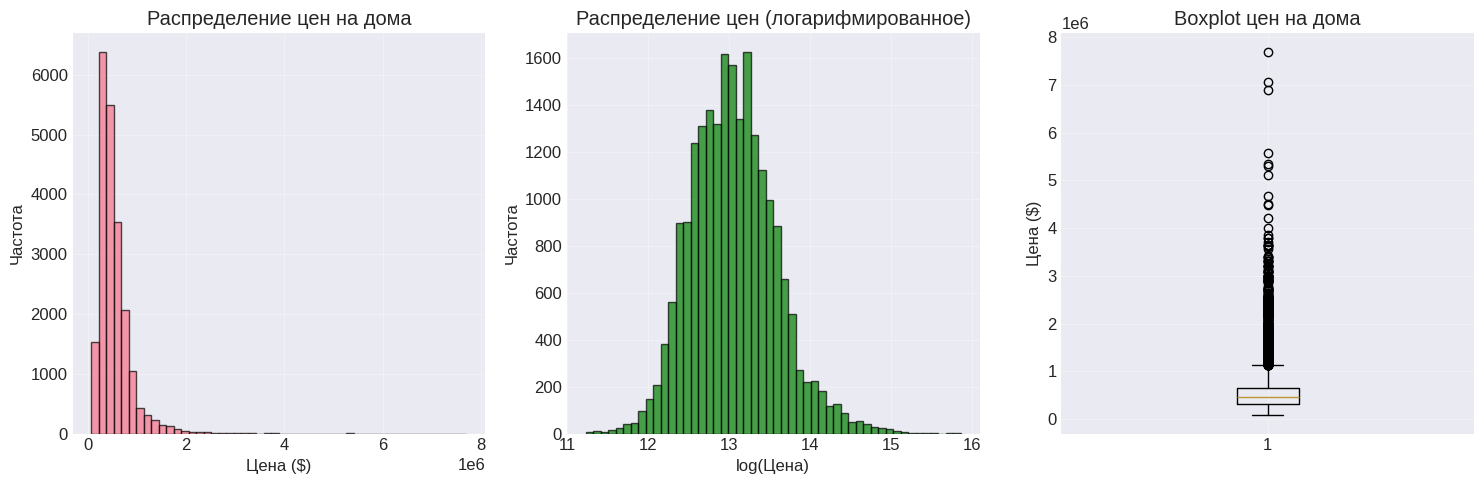


--- 2.5 Анализ стандартных отклонений ---
Топ-10 признаков с наибольшим стандартным отклонением:
               Стандартное отклонение  Среднее значение  Коэффициент вариации
id                       2.876566e+09      4.580302e+09                 62.80
price                    3.671272e+05      5.400881e+05                 67.98
sqft_lot                 4.142051e+04      1.510697e+04                274.18
sqft_lot15               2.730418e+04      1.276846e+04                213.84
sqft_living              9.184409e+02      2.079900e+03                 44.16
sqft_above               8.280910e+02      1.788391e+03                 46.30
sqft_living15            6.853913e+02      1.986552e+03                 34.50
sqft_basement            4.425750e+02      2.915090e+02                151.82
yr_renovated             4.016792e+02      8.440226e+01                475.91
zipcode                  5.350503e+01      9.807794e+04                  0.05

--- 2.6 Корреляция с целевой переменной (pr

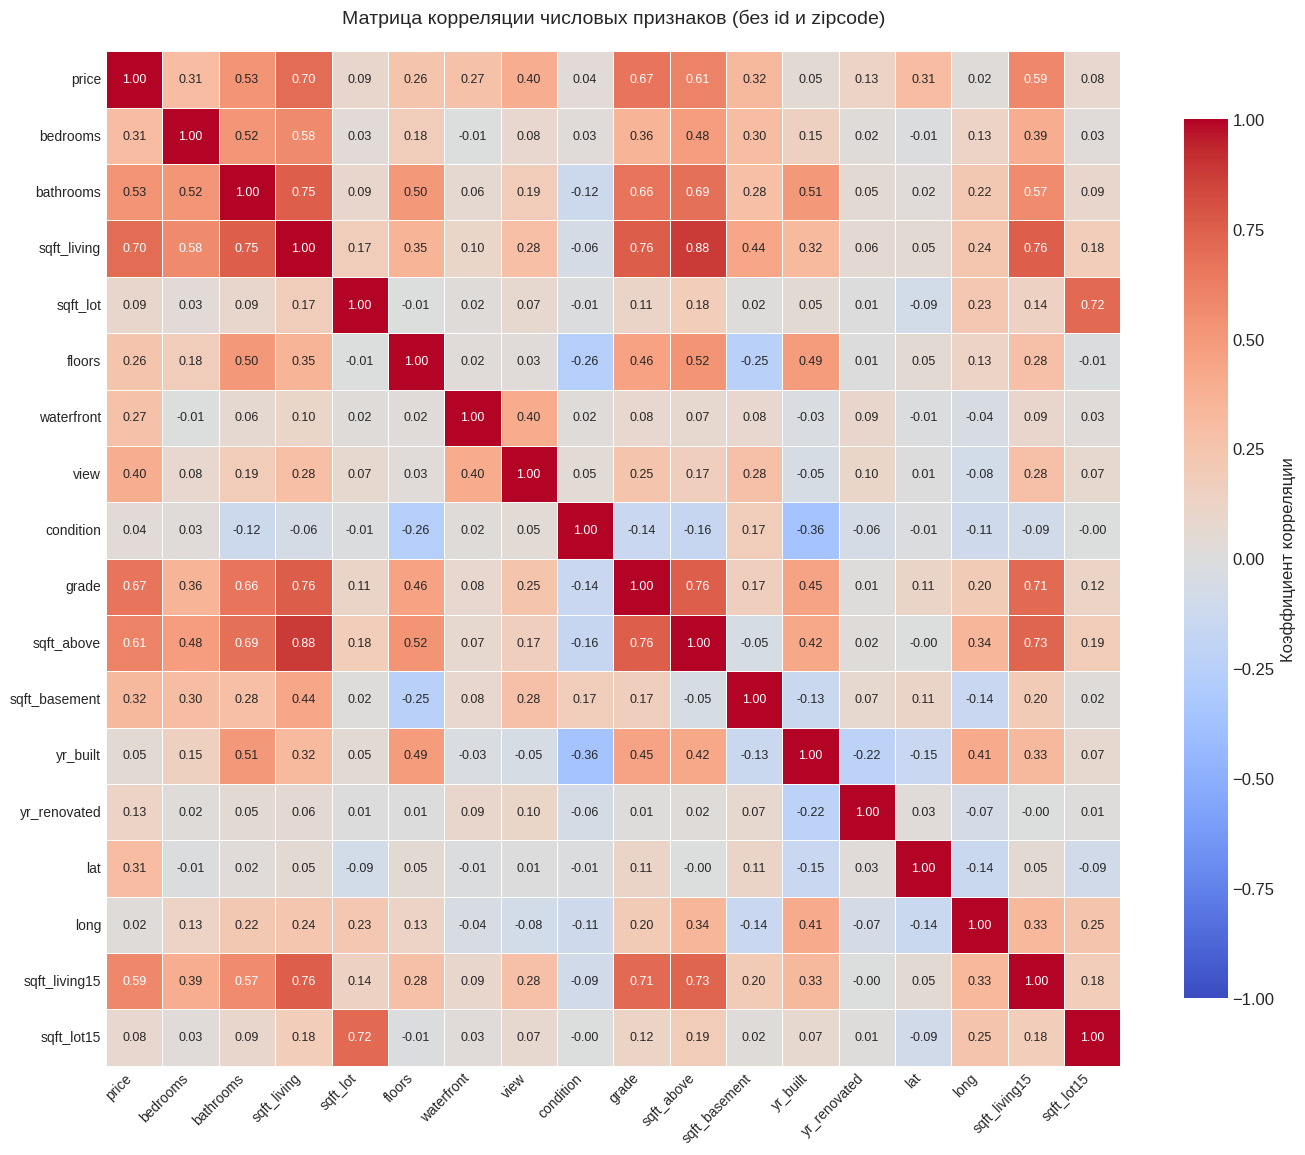


--- Анализ наиболее коррелирующих признаков ---
Пары признаков с высокой корреляцией (|r| > 0.7):
------------------------------------------------------------
  sqft_living     и sqft_above      => 0.877
  sqft_living     и grade           => 0.763
  sqft_living     и sqft_living15   => 0.756
  grade           и sqft_above      => 0.756
  bathrooms       и sqft_living     => 0.755
  sqft_above      и sqft_living15   => 0.732
  sqft_lot        и sqft_lot15      => 0.719
  grade           и sqft_living15   => 0.713
  price           и sqft_living     => 0.702

--- 2.7 Анализ выбросов в ключевых признаках ---
sqft_living    :  572 выбросов (2.6%)
sqft_lot       : 2425 выбросов (11.2%)
bedrooms       :  546 выбросов (2.5%)
bathrooms      :  571 выбросов (2.6%)
grade          : 1911 выбросов (8.8%)


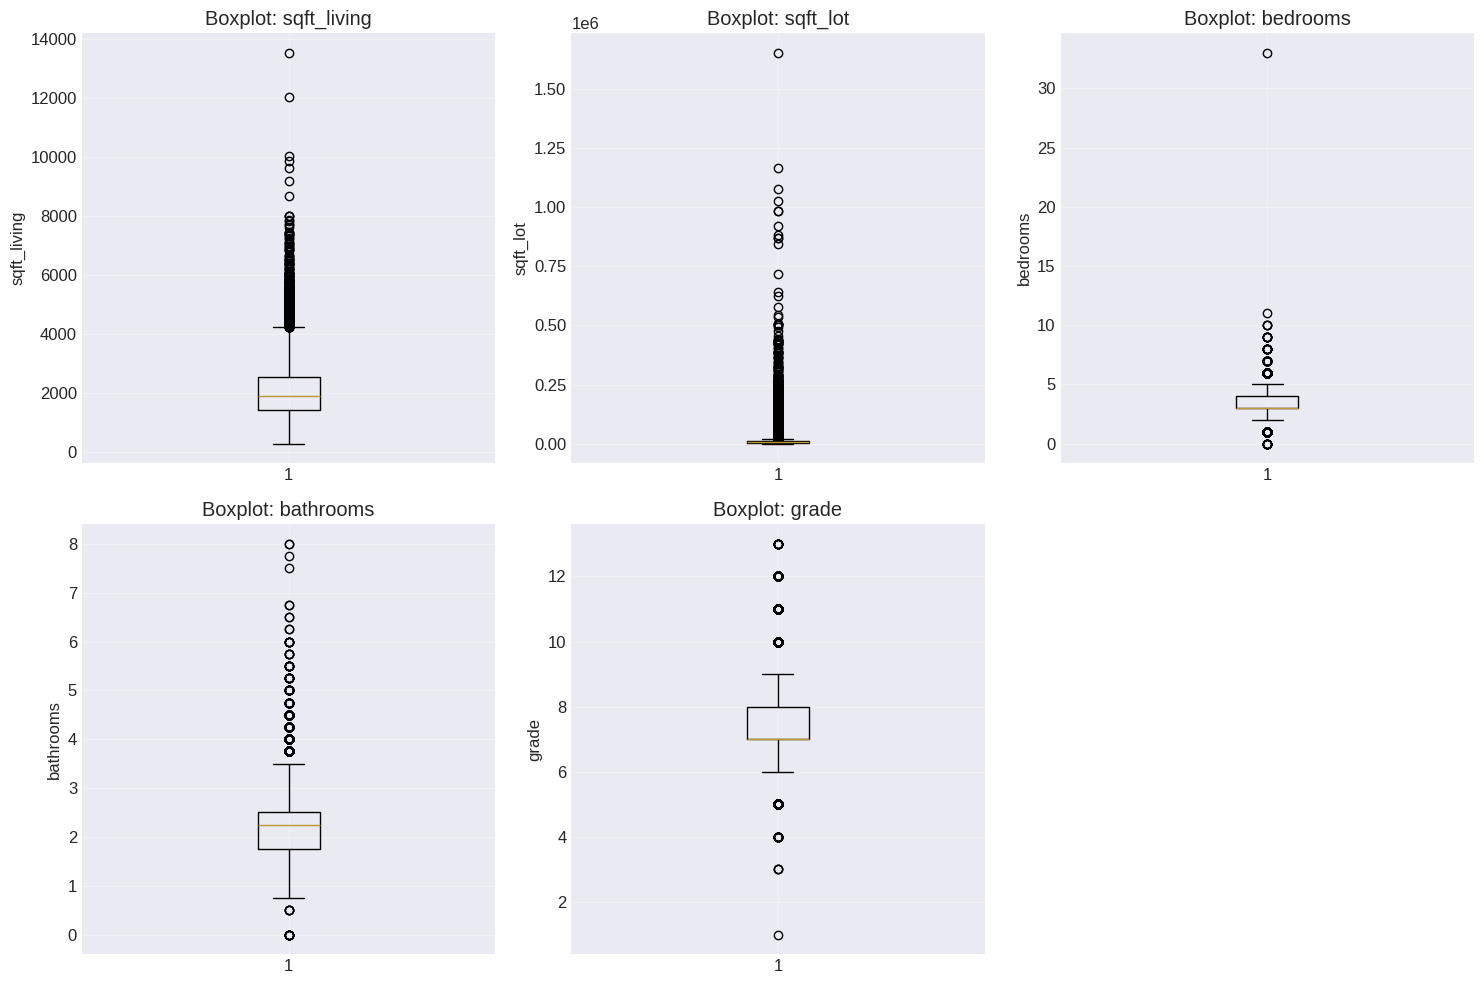

In [3]:
# Ячейка 2: АНАЛИЗ ДАТАСЕТА ДЛЯ РЕГРЕССИИ - ПРОГНОЗ ЦЕН НА ДОМА
# Загрузка датасета
df_reg = pd.read_csv('Regression.csv')
print(f"Датасет загружен: {df_reg.shape[0]} строк, {df_reg.shape[1]} столбцов")

# 2.1 Первичный обзор данных
print("\n--- 2.1 Первичный обзор данных ---")
print("Первые 5 строк датасета:")
print(df_reg.head())
print("\nИнформация о типах данных:")
print(df_reg.info())

# 2.2 Статистическое описание
print("\n--- 2.2 Статистическое описание ---")
print(df_reg.describe())

# 2.3 Проверка пропущенных значений
print("\n--- 2.3 Проверка пропущенных значений ---")
missing_values_reg = df_reg.isnull().sum()
missing_percent_reg = (missing_values_reg / len(df_reg)) * 100

missing_df_reg = pd.DataFrame({
    'Количество пропусков': missing_values_reg,
    'Процент пропусков': missing_percent_reg
}).sort_values('Количество пропусков', ascending=False)

print(missing_df_reg[missing_df_reg['Количество пропусков'] > 0])
if missing_df_reg[missing_df_reg['Количество пропусков'] > 0].empty:
    print("Пропуски в данных отсутствуют")

# 2.4 Анализ целевой переменной (price)
print("\n--- 2.4 Анализ целевой переменной (price) ---")
price_stats = {
    'Медиана': df_reg['price'].median(),
    'Среднее значение': df_reg['price'].mean(),
    'Стандартное отклонение': df_reg['price'].std(),
    'Минимальная цена': df_reg['price'].min(),
    'Максимальная цена': df_reg['price'].max(),
    'Коэффициент вариации': (df_reg['price'].std() / df_reg['price'].mean() * 100)
}

for key, value in price_stats.items():
    if key != 'Коэффициент вариации':
        print(f"{key}: ${value:,.2f}")
    else:
        print(f"{key}: {value:.2f}%")

# Визуализация распределения цены
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(df_reg['price'], bins=50, edgecolor='black', alpha=0.7)
plt.title('Распределение цен на дома')
plt.xlabel('Цена ($)')
plt.ylabel('Частота')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.hist(np.log1p(df_reg['price']), bins=50, edgecolor='black', alpha=0.7, color='green')
plt.title('Распределение цен (логарифмированное)')
plt.xlabel('log(Цена)')
plt.ylabel('Частота')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.boxplot(df_reg['price'])
plt.title('Boxplot цен на дома')
plt.ylabel('Цена ($)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 2.5 Анализ стандартных отклонений
print("\n--- 2.5 Анализ стандартных отклонений ---")
numeric_cols_reg = df_reg.select_dtypes(include=[np.number]).columns
std_dev_reg = df_reg[numeric_cols_reg].std()

std_df_reg = pd.DataFrame({
    'Стандартное отклонение': std_dev_reg,
    'Среднее значение': df_reg[numeric_cols_reg].mean(),
    'Коэффициент вариации': (std_dev_reg / df_reg[numeric_cols_reg].mean() * 100).round(2)
}).sort_values('Стандартное отклонение', ascending=False)

print("Топ-10 признаков с наибольшим стандартным отклонением:")
print(std_df_reg.head(10))

# 2.6 Корреляция с целевой переменной (price)
print("\n--- 2.6 Корреляция с целевой переменной (price) ---")

# Исключаем неинформативные признаки (id, zipcode - это категориальные коды, а не числовые признаки)
exclude_features = ['id', 'zipcode']
numeric_features = [col for col in numeric_cols_reg if col not in exclude_features]

correlations_reg = df_reg[numeric_features].corrwith(df_reg['price']).abs().sort_values(ascending=False)

print("Топ-10 признаков по абсолютной корреляции с ценой:")
for i, (feature, corr_value) in enumerate(correlations_reg.head(10).items(), 1):
    actual_corr = df_reg[numeric_features].corrwith(df_reg['price'])[feature]
    print(f"{i:2}. {feature:20} {actual_corr:+.3f}")

# Визуализация матрицы корреляции
print("\n--- Матрица корреляции (без id и zipcode) ---")

# Создаем матрицу корреляции для осмысленных числовых признаков
corr_matrix = df_reg[numeric_features].corr()

# Определяем размер фигуры в зависимости от количества признаков
n_features = len(corr_matrix.columns)
figsize = max(14, n_features * 0.6), max(12, n_features * 0.6)

plt.figure(figsize=figsize)

# Создаем тепловую карту корреляций
sns.heatmap(corr_matrix, 
           annot=True, 
           fmt='.2f',
           cmap='coolwarm', 
           vmin=-1, vmax=1,
           center=0,
           square=True,
           linewidths=0.5,
           cbar_kws={"shrink": 0.8, "label": "Коэффициент корреляции"},
           annot_kws={"size": 9})

plt.title('Матрица корреляции числовых признаков (без id и zipcode)', fontsize=14, pad=20)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)

plt.tight_layout()
plt.show()

# Дополнительная информация о наиболее коррелирующих признаках
print("\n--- Анализ наиболее коррелирующих признаков ---")

# Находим пары признаков с высокой корреляцией
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_value = corr_matrix.iloc[i, j]
        if abs(corr_value) > 0.7:
            feat1 = corr_matrix.columns[i]
            feat2 = corr_matrix.columns[j]
            high_corr_pairs.append((feat1, feat2, corr_value))

if high_corr_pairs:
    print("Пары признаков с высокой корреляцией (|r| > 0.7):")
    print("-" * 60)
    for feat1, feat2, corr_value in sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True):
        print(f"  {feat1:15} и {feat2:15} => {corr_value:.3f}")
else:
    print("Нет пар признаков с высокой корреляцией (|r| > 0.7)")

# 2.7 Анализ выбросов в ключевых признаках
print("\n--- 2.7 Анализ выбросов в ключевых признаках ---")
key_features = ['sqft_living', 'sqft_lot', 'bedrooms', 'bathrooms', 'grade']

# Базовая информация о выбросах
for feature in key_features:
    if feature in df_reg.columns:
        Q1 = df_reg[feature].quantile(0.25)
        Q3 = df_reg[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = df_reg[(df_reg[feature] < lower_bound) | (df_reg[feature] > upper_bound)]
        n_outliers = len(outliers)
        
        print(f"{feature:15}: {n_outliers:4} выбросов ({n_outliers/len(df_reg)*100:.1f}%)")

# Визуализация
plt.figure(figsize=(15, 10))
for i, feature in enumerate(key_features, 1):
    if feature in df_reg.columns:
        plt.subplot(2, 3, i)
        plt.boxplot(df_reg[feature].dropna())
        plt.title(f'Boxplot: {feature}')
        plt.ylabel(feature)
        plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 2. Создание безлайна и оценка качества

### Предобработка данных для задачи классификации

In [4]:
# Ячейка 3: ПРЕДОБРАБОТКА ДАННЫХ ДЛЯ РЕШАЮЩЕГО ДЕРЕВА КЛАССИФИКАЦИИ
# 3.1 Создаем копию данных для обработки
df_class_processed = df_class.copy()
print("Создана копия данных для предобработки")

# 3.2 Удаляем неинформативные признаки И Attrition_numeric
print("\n--- 3.1 Удаление неинформативных признаков ---")

columns_to_drop = [
    'EmployeeCount',      # Все значения = 1
    'EmployeeNumber',     # Уникальный идентификатор
    'Over18',             # Все значения = 'Y'
    'StandardHours',      # Все значения = 80
    'Attrition_numeric'   
]

print(f"Удаляем признаки: {columns_to_drop}")
df_class_processed = df_class_processed.drop(columns=columns_to_drop, errors='ignore')
print(f"Осталось признаков: {df_class_processed.shape[1]}")

# 3.3 Преобразование целевой переменной
print("\n--- 3.3 Преобразование целевой переменной ---")
df_class_processed['Attrition'] = df_class_processed['Attrition'].map({'Yes': 1, 'No': 0})
print("Целевая переменная Attrition преобразована: Yes -> 1, No -> 0")

# Анализ дисбаланса
print(f"\nСоотношение классов: {sum(df_class_processed['Attrition'] == 0)}:1")
print(f"Процент класса 'Yes' (уволился): {df_class_processed['Attrition'].mean()*100:.1f}%")
print("Для решающего дерева с таким дисбалансом можно использовать:")
print("1. class_weight='balanced'")
print("2. Установить min_samples_leaf больше для меньшего класса")

# 3.4 Обработка категориальных признаков
print("\n--- 3.4 Обработка категориальных признаков ---")

categorical_cols = df_class_processed.select_dtypes(include=['object']).columns.tolist()
print(f"Категориальные признаки для обработки ({len(categorical_cols)}):")

# Анализируем категориальные признаки
for col in categorical_cols:
    unique_vals = df_class_processed[col].nunique()
    value_counts = df_class_processed[col].value_counts()
    print(f"  {col}: {unique_vals} уникальных значений")
    print(f"    Распределение: {dict(value_counts.head(3))}")

# One-Hot Encoding для деревьев (можно без drop_first)
print("\nПрименяем One-Hot Encoding для категориальных признаков...")
df_class_encoded = pd.get_dummies(df_class_processed, columns=categorical_cols, drop_first=True)
print(f"После кодирования: {df_class_encoded.shape[1]} признаков")

# 3.5 Разделение на признаки и целевую переменную
print("\n--- 3.5 Разделение данных ---")
X_class = df_class_encoded.drop('Attrition', axis=1)
y_class = df_class_encoded['Attrition']

print(f"Признаки (X): {X_class.shape}")
print(f"Целевая переменная (y): {y_class.shape}")
print(f"Имена признаков: {list(X_class.columns[:5])}...")

# 3.6 Подготовка
print("\n--- 3.6 Подготовка признаков ---")
X_class_prepared = X_class.values  # Просто преобразуем в numpy array

# 3.7 Разделение на обучающую и тестовую выборки
print("\n--- 3.7 Разделение на train/test ---")
print("Используем stratify=y_class для сохранения пропорций классов")
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(
    X_class_prepared, y_class, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_class
)

print(f"Обучающая выборка: {X_train_class.shape}")
print(f"Тестовая выборка: {X_test_class.shape}")
print(f"Распределение классов в train: {np.bincount(y_train_class)}")
print(f"Распределение классов в test: {np.bincount(y_test_class)}")

# Сохраняем важную информацию для дерева
feature_names_class = X_class.columns.tolist()
print(f"\nДля обучения дерева будут важны параметры:")
print("- max_depth: ограничить для предотвращения переобучения")
print("- min_samples_split: минимальное число образцов для разделения узла")
print("- min_samples_leaf: минимальное число образцов в листе")
print("- class_weight: 'balanced' для учета дисбаланса классов")

Создана копия данных для предобработки

--- 3.1 Удаление неинформативных признаков ---
Удаляем признаки: ['EmployeeCount', 'EmployeeNumber', 'Over18', 'StandardHours', 'Attrition_numeric']
Осталось признаков: 31

--- 3.3 Преобразование целевой переменной ---
Целевая переменная Attrition преобразована: Yes -> 1, No -> 0

Соотношение классов: 1233:1
Процент класса 'Yes' (уволился): 16.1%
Для решающего дерева с таким дисбалансом можно использовать:
1. class_weight='balanced'
2. Установить min_samples_leaf больше для меньшего класса

--- 3.4 Обработка категориальных признаков ---
Категориальные признаки для обработки (7):
  BusinessTravel: 3 уникальных значений
    Распределение: {'Travel_Rarely': 1043, 'Travel_Frequently': 277, 'Non-Travel': 150}
  Department: 3 уникальных значений
    Распределение: {'Research & Development': 961, 'Sales': 446, 'Human Resources': 63}
  EducationField: 6 уникальных значений
    Распределение: {'Life Sciences': 606, 'Medical': 464, 'Marketing': 159}
  Gend

### Предобработка данных для задачи регрессии

In [5]:
# Ячейка 4: ПРЕДОБРАБОТКА ДАННЫХ ДЛЯ РЕШАЮЩЕГО ДЕРЕВА РЕГРЕССИИ
# 4.1 Создаем копию данных для обработки
df_reg_processed = df_reg.copy()
print("Создана копия данных для предобработки")

# 4.2 Удаляем неинформативные признаки
print("\n--- 4.1 Удаление неинформативных признаков ---")

columns_to_drop_reg = ['id', 'zipcode']
print(f"Удаляем признаки: {columns_to_drop_reg}")
df_reg_processed = df_reg_processed.drop(columns=columns_to_drop_reg, errors='ignore')
print(f"Осталось признаков: {df_reg_processed.shape[1]}")

# 4.3 Обработка признака date
print("\n--- 4.3 Обработка временных признаков ---")

if 'date' in df_reg_processed.columns:
    df_reg_processed['date'] = pd.to_datetime(df_reg_processed['date'])
    df_reg_processed['sale_year'] = df_reg_processed['date'].dt.year
    df_reg_processed['sale_month'] = df_reg_processed['date'].dt.month
    df_reg_processed['sale_season'] = df_reg_processed['sale_month'].apply(
        lambda x: 1 if x in [12, 1, 2] else 2 if x in [3, 4, 5] else 3 if x in [6, 7, 8] else 4
    )
    df_reg_processed = df_reg_processed.drop('date', axis=1)
    print(f"Извлечены признаки из даты: sale_year, sale_month, sale_season")

# 4.4 Обработка выбросов (деревья устойчивы, но исправляем явные ошибки)
print("\n--- 4.4 Обработка явных ошибок в данных ---")

# Спальни: исправляем явные ошибки (0 или >10 спален)
if 'bedrooms' in df_reg_processed.columns:
    bedrooms_median = df_reg_processed['bedrooms'].median()
    mask_bedrooms = (df_reg_processed['bedrooms'] < 1) | (df_reg_processed['bedrooms'] > 10)
    if mask_bedrooms.any():
        n_bed = mask_bedrooms.sum()
        df_reg_processed.loc[mask_bedrooms, 'bedrooms'] = bedrooms_median
        print(f"Спальни: {n_bed} некорректных значений заменены на медиану ({bedrooms_median})")

# Ванные: исправляем явные ошибки (0 или >10 ванных)
if 'bathrooms' in df_reg_processed.columns:
    bathrooms_median = df_reg_processed['bathrooms'].median()
    mask_bathrooms = (df_reg_processed['bathrooms'] < 1) | (df_reg_processed['bathrooms'] > 10)
    if mask_bathrooms.any():
        n_bath = mask_bathrooms.sum()
        df_reg_processed.loc[mask_bathrooms, 'bathrooms'] = bathrooms_median
        print(f"Ванные: {n_bath} некорректных значений заменены на медиану ({bathrooms_median:.1f})")

# 4.5 Логарифмирование целевой переменной
print("\n--- 4.5 Логарифмирование целевой переменной ---")

# Логарифмируем цену
df_reg_processed['price_log'] = np.log1p(df_reg_processed['price'])
target_col = 'price_log'

print("Целевая переменная логарифмирована: создан price_log")
print(f"Среднее логарифмированной цены: {df_reg_processed['price_log'].mean():.2f}")
print("\nПримечание: Оригинальные цены остаются в исходном датафрейме df_reg")

# 4.6 Разделение на признаки и целевую переменную
print("\n--- 4.6 Разделение данных ---")

# Собираем все числовые признаки
all_numeric_features = df_reg_processed.select_dtypes(include=[np.number]).columns.tolist()

# Убираем price и price_log из признаков
numeric_features_reg = [col for col in all_numeric_features if col not in ['price', 'price_log']]

X_reg = df_reg_processed[numeric_features_reg]
y_reg = df_reg_processed[target_col]  # Используем price_log как целевую

print(f"Признаки (X): {X_reg.shape}")
print(f"Целевая переменная (y, log): {y_reg.shape}")
print(f"Примеры признаков: {numeric_features_reg[:10]}")

# 4.7 Подготовка
print("\n--- 4.7 Подготовка признаков для решающего дерева ---")
X_reg_prepared = X_reg.values  # Просто преобразуем в numpy array

# 4.8 Разделение на обучающую и тестовую выборки
print("\n--- 4.8 Разделение на train/test ---")

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg_prepared, y_reg, test_size=0.2, random_state=42
)

print(f"Обучающая выборка: {X_train_reg.shape}")
print(f"Тестовая выборка: {X_test_reg.shape}")

feature_names_reg = numeric_features_reg
print(f"\nСохранены имена {len(feature_names_reg)} признаков")

Создана копия данных для предобработки

--- 4.1 Удаление неинформативных признаков ---
Удаляем признаки: ['id', 'zipcode']
Осталось признаков: 19

--- 4.3 Обработка временных признаков ---
Извлечены признаки из даты: sale_year, sale_month, sale_season

--- 4.4 Обработка явных ошибок в данных ---
Спальни: 15 некорректных значений заменены на медиану (3.0)
Ванные: 86 некорректных значений заменены на медиану (2.2)

--- 4.5 Логарифмирование целевой переменной ---
Целевая переменная логарифмирована: создан price_log
Среднее логарифмированной цены: 13.05

Примечание: Оригинальные цены остаются в исходном датафрейме df_reg

--- 4.6 Разделение данных ---
Признаки (X): (21613, 20)
Целевая переменная (y, log): (21613,)
Примеры признаков: ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above']

--- 4.7 Подготовка признаков для решающего дерева ---

--- 4.8 Разделение на train/test ---
Обучающая выборка: (17290, 20)
Тестовая выборка

### Построение безлайна для классификации


--- 5.1 Обучение базовой модели решающего дерева ---
Обучаем модель решающего дерева...
Модель обучена успешно!

--- 5.2 Анализ важности признаков ---
Топ-15 самых важных признаков для решающего дерева:
  TotalWorkingYears              → 0.2139
  OverTime_Yes                   → 0.1798
  StockOptionLevel               → 0.1089
  NumCompaniesWorked             → 0.1024
  Age                            → 0.0955
  JobLevel                       → 0.0672
  DailyRate                      → 0.0531
  Department_Sales               → 0.0338
  WorkLifeBalance                → 0.0330
  DistanceFromHome               → 0.0268
  YearsSinceLastPromotion        → 0.0258
  JobRole_Sales Representative   → 0.0245
  MonthlyIncome                  → 0.0180
  JobRole_Research Scientist     → 0.0158
  HourlyRate                     → 0.0016


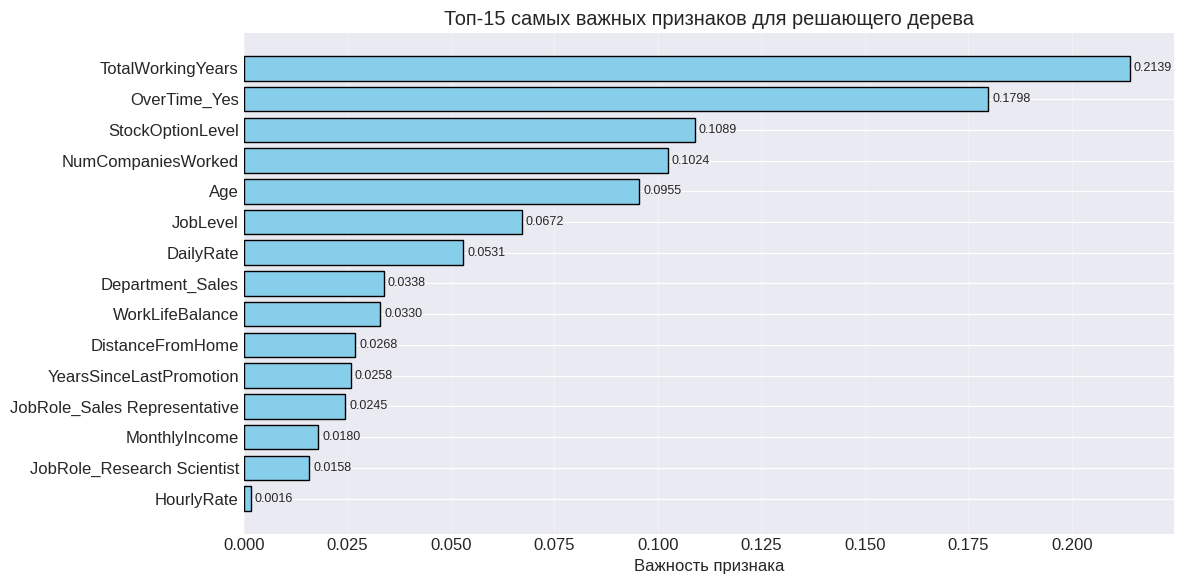


--- 5.3 Предсказания на тестовой выборке ---
Получено 294 предсказаний
Распределение предсказанных классов: Класс 0: 221, Класс 1: 73

--- 5.4 Матрица ошибок ---
Матрица ошибок решающего дерева:
                  Предсказано
                Нет     Да
Фактически Нет  [200]  [ 47]
            Да   [ 21]  [ 26]

Основные метрики качества (вычисленные из матрицы ошибок):
  • Accuracy:       0.7687
  • Precision:      0.3562
  • Recall:         0.5532
  • F1-score:       0.4333

Дополнительные метрики:
  • False Positive: 47 (19.0% от класса 'Нет')
  • False Negative: 21 (44.7% от класса 'Да')

--- 5.5 Визуализация матрицы ошибок ---


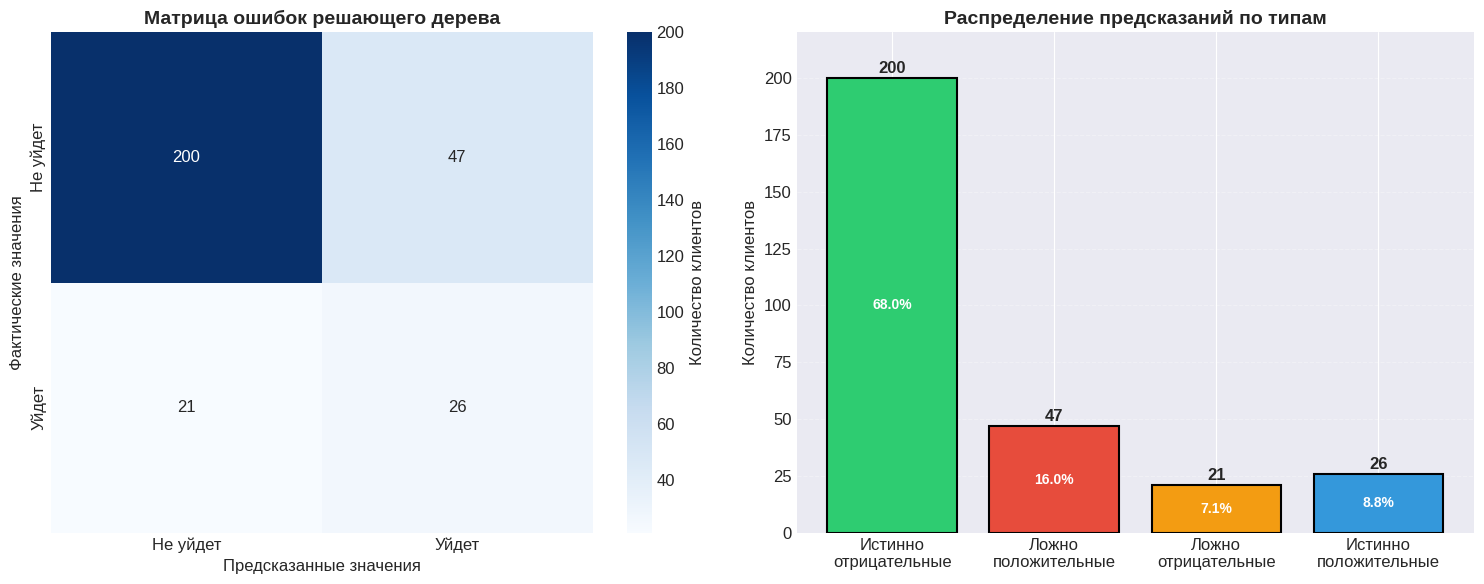


1. ОБЩАЯ СТАТИСТИКА:
   Всего предсказаний: 294
   Правильных предсказаний: 226 (76.9%)
   Ошибок предсказаний: 68 (23.1%)

2. АНАЛИЗ ПО КЛАССАМ:

   КЛАСС 'НЕ УЙДЕТ':
   • Фактически не ушли: 247 клиентов
   • Правильно предсказано: 200 клиентов
   • Точность для класса: 81.0%

   КЛАСС 'УЙДЕТ':
   • Фактически уйдут: 47 клиентов
   • Правильно предсказано: 26 клиентов
   • Точность для класса: 55.3%

3. СТАТИСТИКА ОШИБОК:
   Всего ошибок: 68
   Из них:
   • Ложные срабатывания (False Positive): 47
     - Клиентов, которые не уйдут, но мы предскажем уход: 47
     - Это 16.0% от всех предсказаний
   • Пропущенные случаи (False Negative): 21
     - Клиентов, которые уйдут, но мы не предскажем: 21
     - Это 7.1% от всех предсказаний

--- 5.6 Полный отчет о классификации ---
              precision    recall  f1-score   support

    Не уйдет       0.90      0.81      0.85       247
       Уйдет       0.36      0.55      0.43        47

    accuracy                           0.77       2

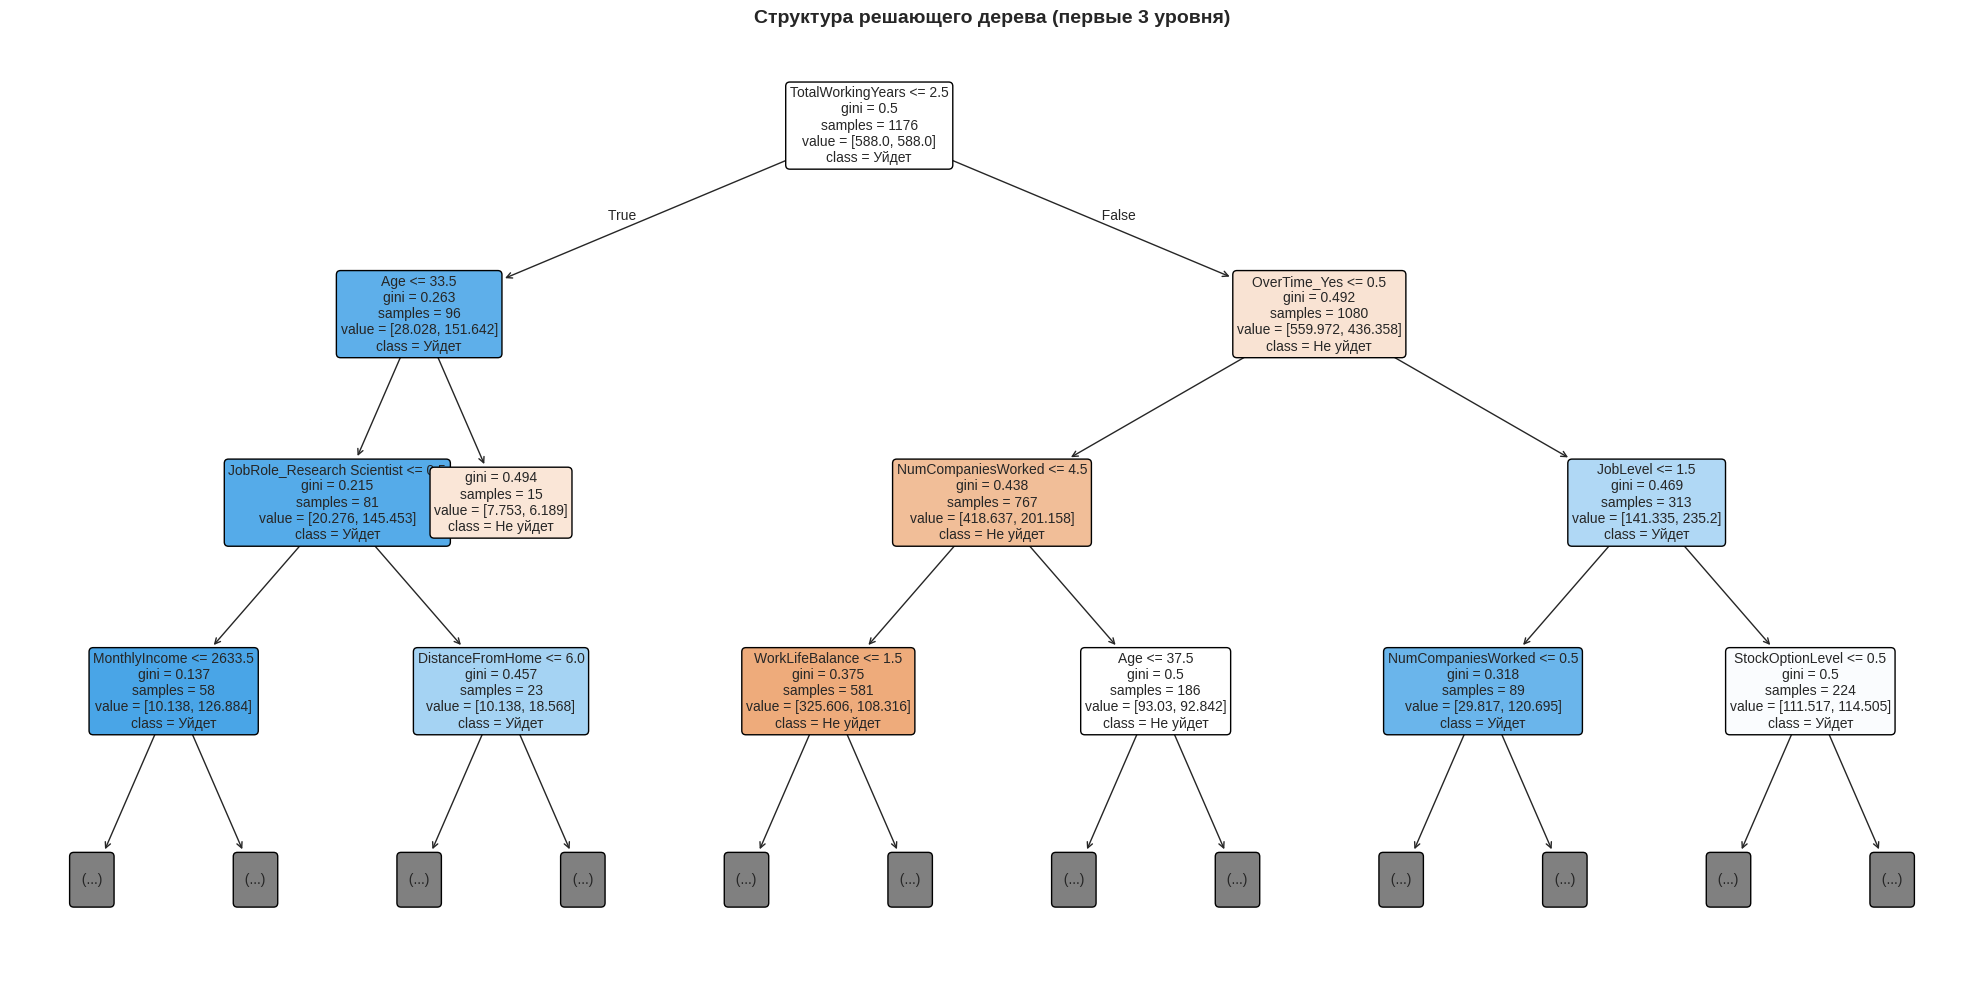


Структура дерева:
• Глубина дерева: 5
• Количество листьев: 22
• Количество узлов: 43

--- 9. Параметры модели ---
Использованные параметры решающего дерева:
• max_depth: 5
• min_samples_split: 20
• min_samples_leaf: 10
• class_weight: balanced


In [51]:
# Ячейка 5: ПОСТРОЕНИЕ БЕЙСЛАЙНА ДЛЯ КЛАССИФИКАЦИИ (Решающее дерево)
# 5.1 Обучение базовой модели решающего дерева
print("\n--- 5.1 Обучение базовой модели решающего дерева ---")

# Создаем модель решающего дерева с контролем переобучения
tree_classifier = DecisionTreeClassifier(
    random_state=42,
    max_depth=5,              # Ограничиваем глубину для предотвращения переобучения
    min_samples_split=20,     # Минимальное количество образцов для разделения узла
    min_samples_leaf=10,      # Минимальное количество образцов в листе
    class_weight='balanced'   # Учитываем дисбаланс классов
)

# Обучаем модель на обучающей выборке
print("Обучаем модель решающего дерева...")
tree_classifier.fit(X_train_class, y_train_class)
print("Модель обучена успешно!")

# 5.2 Анализ важности признаков
print("\n--- 5.2 Анализ важности признаков ---")

# Получаем важность признаков
feature_importance = tree_classifier.feature_importances_
importance_df = pd.DataFrame({
    'Признак': feature_names_class,
    'Важность': feature_importance
}).sort_values('Важность', ascending=False).head(15)

print("Топ-15 самых важных признаков для решающего дерева:")
for i, row in importance_df.iterrows():
    print(f"  {row['Признак']:30} → {row['Важность']:.4f}")

# Визуализация важности признаков
plt.figure(figsize=(12, 6))
bars = plt.barh(range(len(importance_df)), importance_df['Важность'][::-1], 
                color='skyblue', edgecolor='black')
plt.yticks(range(len(importance_df)), importance_df['Признак'][::-1])
plt.xlabel('Важность признака')
plt.title('Топ-15 самых важных признаков для решающего дерева')
plt.grid(axis='x', alpha=0.3)

# Добавляем значения на столбцы
for i, (bar, importance) in enumerate(zip(bars, importance_df['Важность'][::-1])):
    plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2,
            f'{importance:.4f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

# 5.3 Предсказания на тестовой выборке
print("\n--- 5.3 Предсказания на тестовой выборке ---")

# Получаем предсказания
y_pred_class = tree_classifier.predict(X_test_class)

print(f"Получено {len(y_pred_class)} предсказаний")
print(f"Распределение предсказанных классов: Класс 0: {(y_pred_class == 0).sum()}, Класс 1: {(y_pred_class == 1).sum()}")

# 5.4 Матрица ошибок (Confusion Matrix)
print("\n--- 5.4 Матрица ошибок ---")

# Вычисляем матрицу ошибок
cm = confusion_matrix(y_test_class, y_pred_class)
tn, fp, fn, tp = cm.ravel()

print("Матрица ошибок решающего дерева:")
print(f"                  Предсказано")
print(f"                Нет     Да")
print(f"Фактически Нет  [{tn:3d}]  [{fp:3d}]")
print(f"            Да   [{fn:3d}]  [{tp:3d}]")
print()

# Вычисляем метрики из матрицы ошибок
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

print(f"Основные метрики качества (вычисленные из матрицы ошибок):")
print(f"  • Accuracy:       {accuracy:.4f}")
print(f"  • Precision:      {precision:.4f}")
print(f"  • Recall:         {recall:.4f}")
print(f"  • F1-score:       {f1:.4f}")

# Дополнительные метрики
print(f"\nДополнительные метрики:")
print(f"  • False Positive: {fp} ({fp/(fp+tn)*100:.1f}% от класса 'Нет')")
print(f"  • False Negative: {fn} ({fn/(fn+tp)*100:.1f}% от класса 'Да')")

# 5.5 Визуализация матрицы ошибок как графика
print("\n--- 5.5 Визуализация матрицы ошибок ---")

# Создаем фигуру с несколькими графиками
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 1. Тепловая карта матрицы ошибок
ax1 = axes[0]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=['Не уйдет', 'Уйдет'], 
            yticklabels=['Не уйдет', 'Уйдет'],
            cbar_kws={'label': 'Количество клиентов'})
ax1.set_title('Матрица ошибок решающего дерева', fontsize=14, fontweight='bold')
ax1.set_ylabel('Фактические значения', fontsize=12)
ax1.set_xlabel('Предсказанные значения', fontsize=12)

# 2. Столбчатая диаграмма распределения ошибок
ax2 = axes[1]
categories = ['Истинно\nотрицательные', 'Ложно\nположительные', 
              'Ложно\nотрицательные', 'Истинно\nположительные']
values = [tn, fp, fn, tp]
colors = ['#2ecc71', '#e74c3c', '#f39c12', '#3498db']

bars = ax2.bar(categories, values, color=colors, edgecolor='black', linewidth=1.5)

# Добавляем значения на столбцы
for bar, value in zip(bars, values):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{value}', ha='center', va='bottom', fontweight='bold')

ax2.set_title('Распределение предсказаний по типам', fontsize=14, fontweight='bold')
ax2.set_ylabel('Количество клиентов', fontsize=12)
ax2.set_ylim(0, max(values) * 1.1)
ax2.grid(axis='y', alpha=0.3, linestyle='--')

# Добавляем аннотации с процентами
total_predictions = len(y_pred_class)
percentages = [v/total_predictions*100 for v in values]
for i, (bar, perc) in enumerate(zip(bars, percentages)):
    ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height()/2,
            f'{perc:.1f}%', ha='center', va='center', 
            color='white', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

# 5.6 Анализ правильности предсказаний
total_predictions = len(y_pred_class)
correct_predictions = tp + tn
incorrect_predictions = fp + fn

print(f"\n1. ОБЩАЯ СТАТИСТИКА:")
print(f"   Всего предсказаний: {total_predictions}")
print(f"   Правильных предсказаний: {correct_predictions} ({accuracy*100:.1f}%)")
print(f"   Ошибок предсказаний: {incorrect_predictions} ({(1-accuracy)*100:.1f}%)")

# Анализ по классам
print(f"\n2. АНАЛИЗ ПО КЛАССАМ:")

# Для класса "Не уйдет" (0)
correct_not_churn = tn
total_not_churn_actual = tn + fp
accuracy_not_churn = tn / (tn + fp) if (tn + fp) > 0 else 0

print(f"\n   КЛАСС 'НЕ УЙДЕТ':")
print(f"   • Фактически не ушли: {total_not_churn_actual} клиентов")
print(f"   • Правильно предсказано: {correct_not_churn} клиентов")
print(f"   • Точность для класса: {accuracy_not_churn*100:.1f}%")

# Для класса "Уйдет" (1)
correct_churn = tp
total_churn_actual = tp + fn
accuracy_churn = tp / (tp + fn) if (tp + fn) > 0 else 0

print(f"\n   КЛАСС 'УЙДЕТ':")
print(f"   • Фактически уйдут: {total_churn_actual} клиентов")
print(f"   • Правильно предсказано: {correct_churn} клиентов")
print(f"   • Точность для класса: {accuracy_churn*100:.1f}%")

# Статистика ошибок
print(f"\n3. СТАТИСТИКА ОШИБОК:")
print(f"   Всего ошибок: {incorrect_predictions}")
print(f"   Из них:")
print(f"   • Ложные срабатывания (False Positive): {fp}")
print(f"     - Клиентов, которые не уйдут, но мы предскажем уход: {fp}")
print(f"     - Это {fp/total_predictions*100:.1f}% от всех предсказаний")
print(f"   • Пропущенные случаи (False Negative): {fn}")
print(f"     - Клиентов, которые уйдут, но мы не предскажем: {fn}")
print(f"     - Это {fn/total_predictions*100:.1f}% от всех предсказаний")

# 5.7 Полный отчет о классификации
print("\n--- 5.6 Полный отчет о классификации ---")
print(classification_report(y_test_class, y_pred_class, 
                           target_names=['Не уйдет', 'Уйдет']))

# 5.8 Визуализация дерева (упрощенная версия)
print("\n--- 5.7 Визуализация структуры дерева ---")

plt.figure(figsize=(20, 10))
tree.plot_tree(tree_classifier, 
               feature_names=feature_names_class, 
               class_names=['Не уйдет', 'Уйдет'], 
               filled=True, 
               rounded=True,
               fontsize=10,
               max_depth=3)  # Показываем только 3 уровня для читаемости
plt.title('Структура решающего дерева (первые 3 уровня)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nСтруктура дерева:")
print(f"• Глубина дерева: {tree_classifier.get_depth()}")
print(f"• Количество листьев: {tree_classifier.get_n_leaves()}")
print(f"• Количество узлов: {tree_classifier.tree_.node_count}")

# 5.10 Информация о параметрах дерева
print("\n--- 9. Параметры модели ---")
print(f"Использованные параметры решающего дерева:")
print(f"• max_depth: {tree_classifier.max_depth}")
print(f"• min_samples_split: {tree_classifier.min_samples_split}")
print(f"• min_samples_leaf: {tree_classifier.min_samples_leaf}")
print(f"• class_weight: {tree_classifier.class_weight}")

### Построение безлайна для регрессии


--- 6.1 Обучение базовой модели решающего дерева регрессии ---
Обучаем модель решающего дерева для регрессии...
Модель обучена успешно!
Глубина дерева: 5
Количество листьев: 31

--- 6.2 Анализ важности признаков ---
Топ-15 самых важных признаков для предсказания цены дома:
  grade                          → 0.6817
  lat                            → 0.0901
  sqft_living                    → 0.0888
  sqft_living15                  → 0.0460
  yr_built                       → 0.0240
  sqft_basement                  → 0.0200
  long                           → 0.0183
  view                           → 0.0100
  yr_renovated                   → 0.0087
  sqft_above                     → 0.0063
  waterfront                     → 0.0057
  bedrooms                       → 0.0003
  bathrooms                      → 0.0000
  condition                      → 0.0000
  floors                         → 0.0000


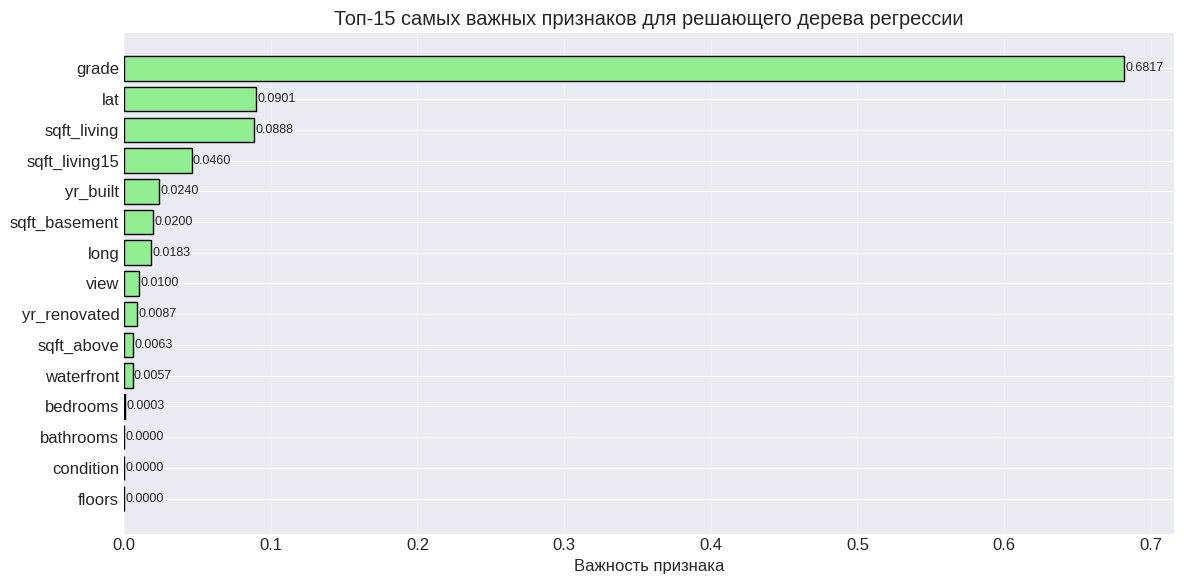


--- 6.3 Предсказания на тестовой выборке ---
Получено 4323 предсказаний цен
Примеры предсказанных цен (первые 5): $[ 437353  566098 1308347 2125777  715701]
Примеры фактических цен (первые 5):   $[ 364999  864999 1037999 1490000  711000]

--- 6.4 Оценка качества модели (метрики) ---
Метрики в логарифмированной шкале (более устойчивые):
  • RMSE (log scale): 0.3292
  • MAE (log scale):  0.2582

Метрики в оригинальной шкале (доллары):
  • RMSE:            $232,477 (основная метрика)
  • MAE:             $141,486 (вспомогательная)
  • MAPE:            26.61% (вспомогательная)
  • R²:              0.6425 (вспомогательная)

--- 6.5 Визуализация результатов регрессии ---


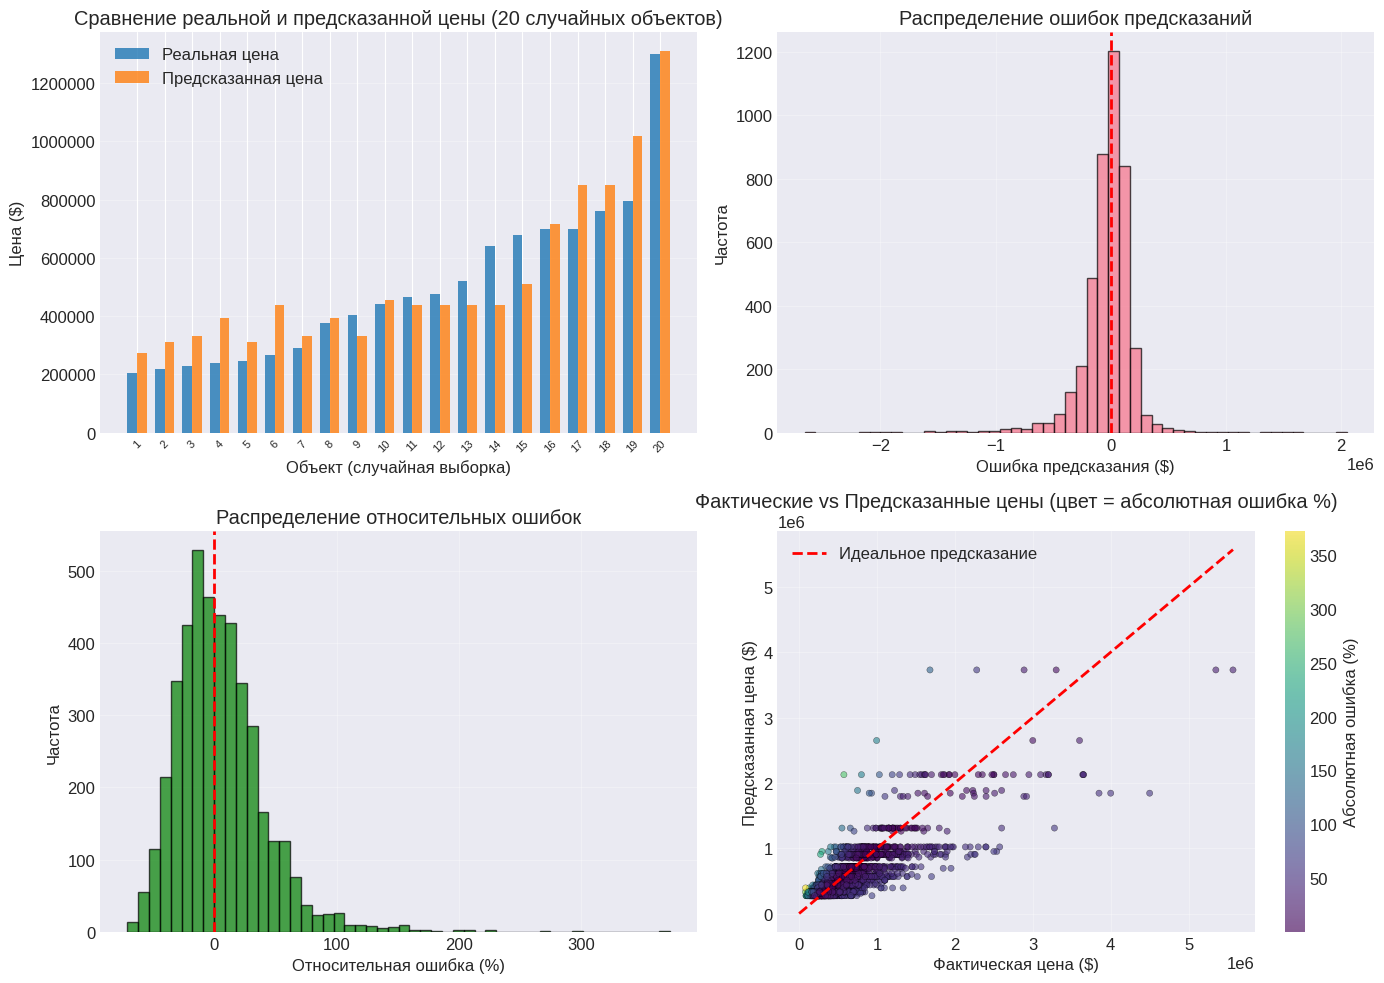


--- 6.6 Статистика ошибок предсказаний ---
Процентили абсолютных ошибок (в долларах):
  • 25%: $45,601
  • 50% (медиана): $93,355
  • 75%: $167,153
  • 90%: $292,978
  • 95%: $415,952

Процент предсказаний с заданной точностью:
  • Ошибка ≤ 10%: 24.0% предсказаний
  • Ошибка ≤ 20%: 47.6% предсказаний
  • Ошибка ≤ 30%: 67.0% предсказаний

--- 6.7 Сравнение реальных и предсказанных цен ---
Средняя цена: реальная = $549,367, предсказанная = $518,715
Медианная цена: реальная = $455,000, предсказанная = $437,354
Средняя ошибка: $-30,653
Средняя абсолютная ошибка: $141,486 (26.6%)

--- 6.8 Анализ остатков модели ---
Средний остаток: $30,653
Стандартное отклонение остатков: $230,447
Минимальный остаток: $-2,048,364
Максимальный остаток: $2,657,732
Процент положительных остатков: 49.9%

--- 6.9 Визуализация структуры дерева регрессии ---


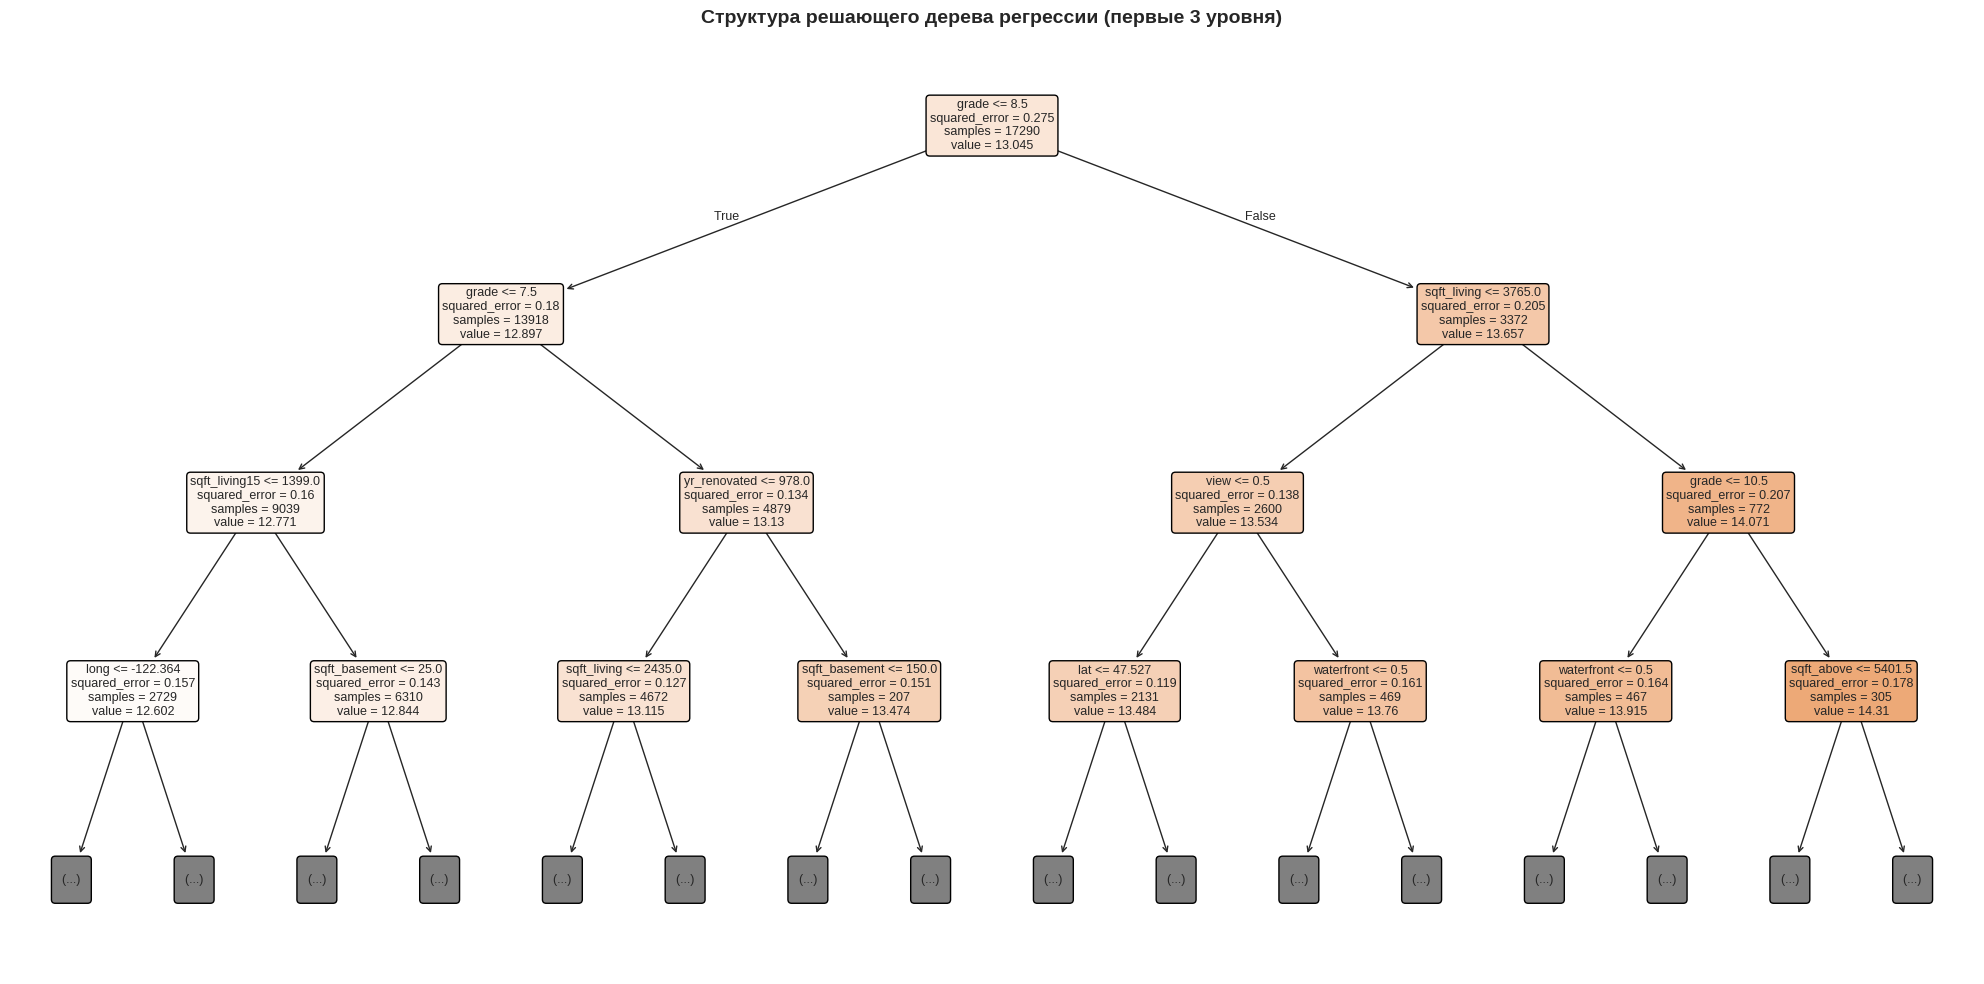


Структура дерева регрессии:
• Глубина дерева: 5
• Количество листьев: 31
• Количество узлов: 61

--- 6.10 Параметры модели ---
Использованные параметры решающего дерева регрессии:
• max_depth: 5
• min_samples_split: 20
• min_samples_leaf: 10
• max_features: sqrt
• random_state: 42


In [7]:
# Ячейка 6: ПОСТРОЕНИЕ БЕЙСЛАЙНА ДЛЯ РЕГРЕССИИ (Решающее дерево)
# 6.1 Обучение базовой модели решающего дерева регрессии
print("\n--- 6.1 Обучение базовой модели решающего дерева регрессии ---")

# Создаем модель решающего дерева для регрессии с контролем переобучения
tree_regressor = DecisionTreeRegressor(
    random_state=42,
    max_depth=5,              # Ограничиваем глубину для предотвращения переобучения
    min_samples_split=20,     # Минимальное количество образцов для разделения узла
    min_samples_leaf=10,      # Минимальное количество образцов в листе
    max_features='sqrt'       # Количество признаков для рассмотрения при разделении
)

# Обучаем модель на обучающей выборке
print("Обучаем модель решающего дерева для регрессии...")
tree_regressor.fit(X_train_reg, y_train_reg)
print("Модель обучена успешно!")

# Анализ структуры дерева
print(f"Глубина дерева: {tree_regressor.get_depth()}")
print(f"Количество листьев: {tree_regressor.get_n_leaves()}")

# 6.2 Анализ важности признаков
print("\n--- 6.2 Анализ важности признаков ---")

# Получаем важность признаков
feature_importance = tree_regressor.feature_importances_
importance_df = pd.DataFrame({
    'Признак': feature_names_reg,
    'Важность': feature_importance
}).sort_values('Важность', ascending=False).head(15)

print("Топ-15 самых важных признаков для предсказания цены дома:")
for i, row in importance_df.iterrows():
    print(f"  {row['Признак']:30} → {row['Важность']:.4f}")

# Визуализация важности признаков
plt.figure(figsize=(12, 6))
bars = plt.barh(range(len(importance_df)), importance_df['Важность'][::-1], 
                color='lightgreen', edgecolor='black')
plt.yticks(range(len(importance_df)), importance_df['Признак'][::-1])
plt.xlabel('Важность признака')
plt.title('Топ-15 самых важных признаков для решающего дерева регрессии')
plt.grid(axis='x', alpha=0.3)

# Добавляем значения на столбцы
for i, (bar, importance) in enumerate(zip(bars, importance_df['Важность'][::-1])):
    plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2,
            f'{importance:.4f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

# 6.3 Предсказания на тестовой выборке
print("\n--- 6.3 Предсказания на тестовой выборке ---")

# Получаем предсказания (логарифмированные цены)
y_pred_reg_log = tree_regressor.predict(X_test_reg)

# Преобразуем обратно из логарифма в обычные цены
y_pred_reg = np.expm1(y_pred_reg_log)

# Преобразуем y_test_reg из логарифмированной шкалы в обычные цены
y_test_reg_original = np.expm1(y_test_reg)

print(f"Получено {len(y_pred_reg)} предсказаний цен")
print(f"Примеры предсказанных цен (первые 5): ${y_pred_reg[:5].astype(int)}")
print(f"Примеры фактических цен (первые 5):   ${y_test_reg_original.iloc[:5].astype(int).values}")

# 6.4 Оценка качества модели (метрики)
print("\n--- 6.4 Оценка качества модели (метрики) ---")

# Основные метрики в логарифмированной шкале (более устойчивые)
rmse_log = np.sqrt(mean_squared_error(y_test_reg, y_pred_reg_log))
mae_log = mean_absolute_error(y_test_reg, y_pred_reg_log)

# Метрики в оригинальной шкале (доллары)
rmse = np.sqrt(mean_squared_error(y_test_reg_original, y_pred_reg))
mae = mean_absolute_error(y_test_reg_original, y_pred_reg)

mape = mean_absolute_percentage_error(y_test_reg_original, y_pred_reg)
r2 = r2_score(y_test_reg_original, y_pred_reg)

print("Метрики в логарифмированной шкале (более устойчивые):")
print(f"  • RMSE (log scale): {rmse_log:.4f}")
print(f"  • MAE (log scale):  {mae_log:.4f}")

print("\nМетрики в оригинальной шкале (доллары):")
print(f"  • RMSE:            ${rmse:,.0f} (основная метрика)")
print(f"  • MAE:             ${mae:,.0f} (вспомогательная)")
print(f"  • MAPE:            {mape*100:.2f}% (вспомогательная)")
print(f"  • R²:              {r2:.4f} (вспомогательная)")

# 6.5 Визуализация: реальные vs предсказанные цены
print("\n--- 6.5 Визуализация результатов регрессии ---")

# Создаем DataFrame для удобства анализа
y_test_array = y_test_reg_original.values if hasattr(y_test_reg_original, 'values') else y_test_reg_original

results_df = pd.DataFrame({
    'Фактическая_цена': y_test_array,
    'Предсказанная_цена': y_pred_reg,
    'Относительная_ошибка_%': ((y_pred_reg - y_test_array) / y_test_array) * 100
})

# Рассчитываем ошибки для графиков
errors = y_pred_reg - y_test_array
relative_errors = (errors / y_test_array) * 100

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# График 1: Сравнение реальной и предсказанной цены для случайных 20 объектов
np.random.seed(42)
n_samples = min(20, len(results_df))
sample_indices = np.random.choice(len(results_df), n_samples, replace=False)
sample_df = results_df.iloc[sample_indices].copy()
sample_df = sample_df.sort_values('Фактическая_цена')

x_pos = np.arange(len(sample_df))
width = 0.35

bars_actual = axes[0, 0].bar(x_pos - width/2, sample_df['Фактическая_цена'], 
                            width, label='Реальная цена', color='#1f77b4', alpha=0.8)
bars_pred = axes[0, 0].bar(x_pos + width/2, sample_df['Предсказанная_цена'], 
                          width, label='Предсказанная цена', color='#ff7f0e', alpha=0.8)

axes[0, 0].set_xlabel('Объект (случайная выборка)')
axes[0, 0].set_ylabel('Цена ($)')
axes[0, 0].set_title('Сравнение реальной и предсказанной цены (20 случайных объектов)')
axes[0, 0].set_xticks(x_pos)
axes[0, 0].set_xticklabels([f'{i+1}' for i in range(len(sample_df))], rotation=45, fontsize=8)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis='y')
axes[0, 0].ticklabel_format(style='plain', axis='y')

# График 2: Ошибки предсказаний
axes[0, 1].hist(errors, bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Ошибка предсказания ($)')
axes[0, 1].set_ylabel('Частота')
axes[0, 1].set_title('Распределение ошибок предсказаний')
axes[0, 1].grid(True, alpha=0.3)

# График 3: Относительные ошибки
axes[1, 0].hist(relative_errors, bins=50, edgecolor='black', alpha=0.7, color='green')
axes[1, 0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Относительная ошибка (%)')
axes[1, 0].set_ylabel('Частота')
axes[1, 0].set_title('Распределение относительных ошибок')
axes[1, 0].grid(True, alpha=0.3)

# График 4: Фактические vs предсказанные цены (scatter с тепловой картой)
scatter = axes[1, 1].scatter(results_df['Фактическая_цена'], results_df['Предсказанная_цена'],
                            c=np.abs(results_df['Относительная_ошибка_%']),
                            cmap='viridis', alpha=0.6, s=20, edgecolors='black', linewidth=0.3)

# Линия идеального предсказания
max_price = max(results_df['Фактическая_цена'].max(), results_df['Предсказанная_цена'].max())
axes[1, 1].plot([0, max_price], [0, max_price], 'r--', linewidth=2, label='Идеальное предсказание')

axes[1, 1].set_xlabel('Фактическая цена ($)')
axes[1, 1].set_ylabel('Предсказанная цена ($)')
axes[1, 1].set_title('Фактические vs Предсказанные цены (цвет = абсолютная ошибка %)')
axes[1, 1].legend(loc='upper left')
axes[1, 1].grid(True, alpha=0.3)

# Добавляем цветовую шкалу
cbar = plt.colorbar(scatter, ax=axes[1, 1])
cbar.set_label('Абсолютная ошибка (%)')

plt.tight_layout()
plt.show()

# 6.6 Статистика ошибок
print("\n--- 6.6 Статистика ошибок предсказаний ---")

# Процентили абсолютных ошибок (в долларах)
abs_errors = np.abs(errors)
error_percentiles = np.percentile(abs_errors, [25, 50, 75, 90, 95])
print("Процентили абсолютных ошибок (в долларах):")
print(f"  • 25%: ${error_percentiles[0]:,.0f}")
print(f"  • 50% (медиана): ${error_percentiles[1]:,.0f}")
print(f"  • 75%: ${error_percentiles[2]:,.0f}")
print(f"  • 90%: ${error_percentiles[3]:,.0f}")
print(f"  • 95%: ${error_percentiles[4]:,.0f}")

# Процент предсказаний с разной точностью
abs_relative_errors = np.abs(relative_errors)
within_10_percent = np.sum(abs_relative_errors <= 10) / len(abs_relative_errors) * 100
within_20_percent = np.sum(abs_relative_errors <= 20) / len(abs_relative_errors) * 100
within_30_percent = np.sum(abs_relative_errors <= 30) / len(abs_relative_errors) * 100

print("\nПроцент предсказаний с заданной точностью:")
print(f"  • Ошибка ≤ 10%: {within_10_percent:.1f}% предсказаний")
print(f"  • Ошибка ≤ 20%: {within_20_percent:.1f}% предсказаний")
print(f"  • Ошибка ≤ 30%: {within_30_percent:.1f}% предсказаний")

# 6.7 Сравнение реальных и предсказанных цен
print("\n--- 6.7 Сравнение реальных и предсказанных цен ---")

mean_actual = np.mean(y_test_array)
mean_pred = np.mean(y_pred_reg)
median_actual = np.median(y_test_array)
median_pred = np.median(y_pred_reg)

print(f"Средняя цена: реальная = ${mean_actual:,.0f}, предсказанная = ${mean_pred:,.0f}")
print(f"Медианная цена: реальная = ${median_actual:,.0f}, предсказанная = ${median_pred:,.0f}")
print(f"Средняя ошибка: ${np.mean(errors):,.0f}")
print(f"Средняя абсолютная ошибка: ${mae:,.0f} ({mape*100:.1f}%)")

# 6.8 Анализ остатков
print("\n--- 6.8 Анализ остатков модели ---")

residuals = y_test_array - y_pred_reg
print(f"Средний остаток: ${np.mean(residuals):,.0f}")
print(f"Стандартное отклонение остатков: ${np.std(residuals):,.0f}")
print(f"Минимальный остаток: ${np.min(residuals):,.0f}")
print(f"Максимальный остаток: ${np.max(residuals):,.0f}")
print(f"Процент положительных остатков: {np.sum(residuals > 0) / len(residuals) * 100:.1f}%")

# 6.9 Визуализация структуры дерева (упрощенная)
print("\n--- 6.9 Визуализация структуры дерева регрессии ---")

plt.figure(figsize=(20, 10))
tree.plot_tree(tree_regressor, 
               feature_names=feature_names_reg, 
               filled=True, 
               rounded=True,
               fontsize=9,
               max_depth=3)  # Показываем только 3 уровня для читаемости
plt.title('Структура решающего дерева регрессии (первые 3 уровня)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nСтруктура дерева регрессии:")
print(f"• Глубина дерева: {tree_regressor.get_depth()}")
print(f"• Количество листьев: {tree_regressor.get_n_leaves()}")
print(f"• Количество узлов: {tree_regressor.tree_.node_count}")

# 6.10 Информация о параметрах дерева
print("\n--- 6.10 Параметры модели ---")
print(f"Использованные параметры решающего дерева регрессии:")
print(f"• max_depth: {tree_regressor.max_depth}")
print(f"• min_samples_split: {tree_regressor.min_samples_split}")
print(f"• min_samples_leaf: {tree_regressor.min_samples_leaf}")
print(f"• max_features: {tree_regressor.max_features}")
print(f"• random_state: {tree_regressor.random_state}")

## 3. Улучшение Безлайна

### Гипотезы для улучшения

**Для решающего дерева классификации:**

**Основные проблемы:**
- Низкий Precision (0.36) - много ложных срабатываний (47 FP)
- Пропускаем 45% увольнений (Recall = 0.55)
- Сильный дисбаланс классов 5:1

Гипотезы для улучшения:

1. Увеличить глубину дерева - с 5 до 7-8 для лучшего разделения классов

2. Точно настроить баланс классов - `class_weight={0: 1, 1: 2.5}` вместо 'balanced'

3. Уменьшить min_samples_leaf - с 10 до 5-7 для большей чувствительности к меньшему классу

4. Удалить шумные признаки - исключить HourlyRate и другие маловажные


**Для решающего дерева регресии:**

**Основные проблемы:**
- RMSE $232K - большая ошибка предсказания
- Только 24% предсказаний с ошибкой ≤10%
- R² = 0.64 - можно улучшить

**Гипотезы для улучшения:**

1. Увеличить глубину дерева - с 5 до 8-10 для лучшей детализации

2. Использовать MAE как критерий - `criterion='absolute_error'` для устойчивости к выбросам

3. Создать интерактивный признак - `price_per_sqft = price / sqft_living`



--- 7.1 АНАЛИЗ ПРОБЛЕМ БЕЙЗЛАЙН МОДЕЛИ ---

ТЕКУЩИЕ ПАРАМЕТРЫ БЕЙЗЛАЙН МОДЕЛИ:
• max_depth: 5
• min_samples_split: 20
• min_samples_leaf: 10
• class_weight: balanced
• Глубина дерева: 5
• Количество листьев: 22

--- 7.2 ПРОВЕРКА ГИПОТЕЗ С ПОМОЩЬЮ GRIDSEARCHCV ---

Запускаем GridSearchCV с учетом дисбаланса классов...
Будет проверено 324 комбинаций
Fitting 5 folds for each of 324 candidates, totalling 1620 fits

--- 7.3 АНАЛИЗ РЕЗУЛЬТАТОВ GRIDSEARCHCV ---

ТОП-5 ЛУЧШИХ КОМБИНАЦИЙ ПАРАМЕТРОВ:
--------------------------------------------------------------------------------

1. F1-score: 0.4386
   max_depth: 7
   min_samples_leaf: 5
   class_weight: {0: 1, 1: 2}
   max_features: None

2. F1-score: 0.4381
   max_depth: 6
   min_samples_leaf: 7
   class_weight: {0: 1, 1: 2}
   max_features: None

3. F1-score: 0.4376
   max_depth: 6
   min_samples_leaf: 10
   class_weight: {0: 1, 1: 2}
   max_features: None

4. F1-score: 0.4369
   max_depth: 6
   min_samples_leaf: 5
   class_weight: {0: 1, 1

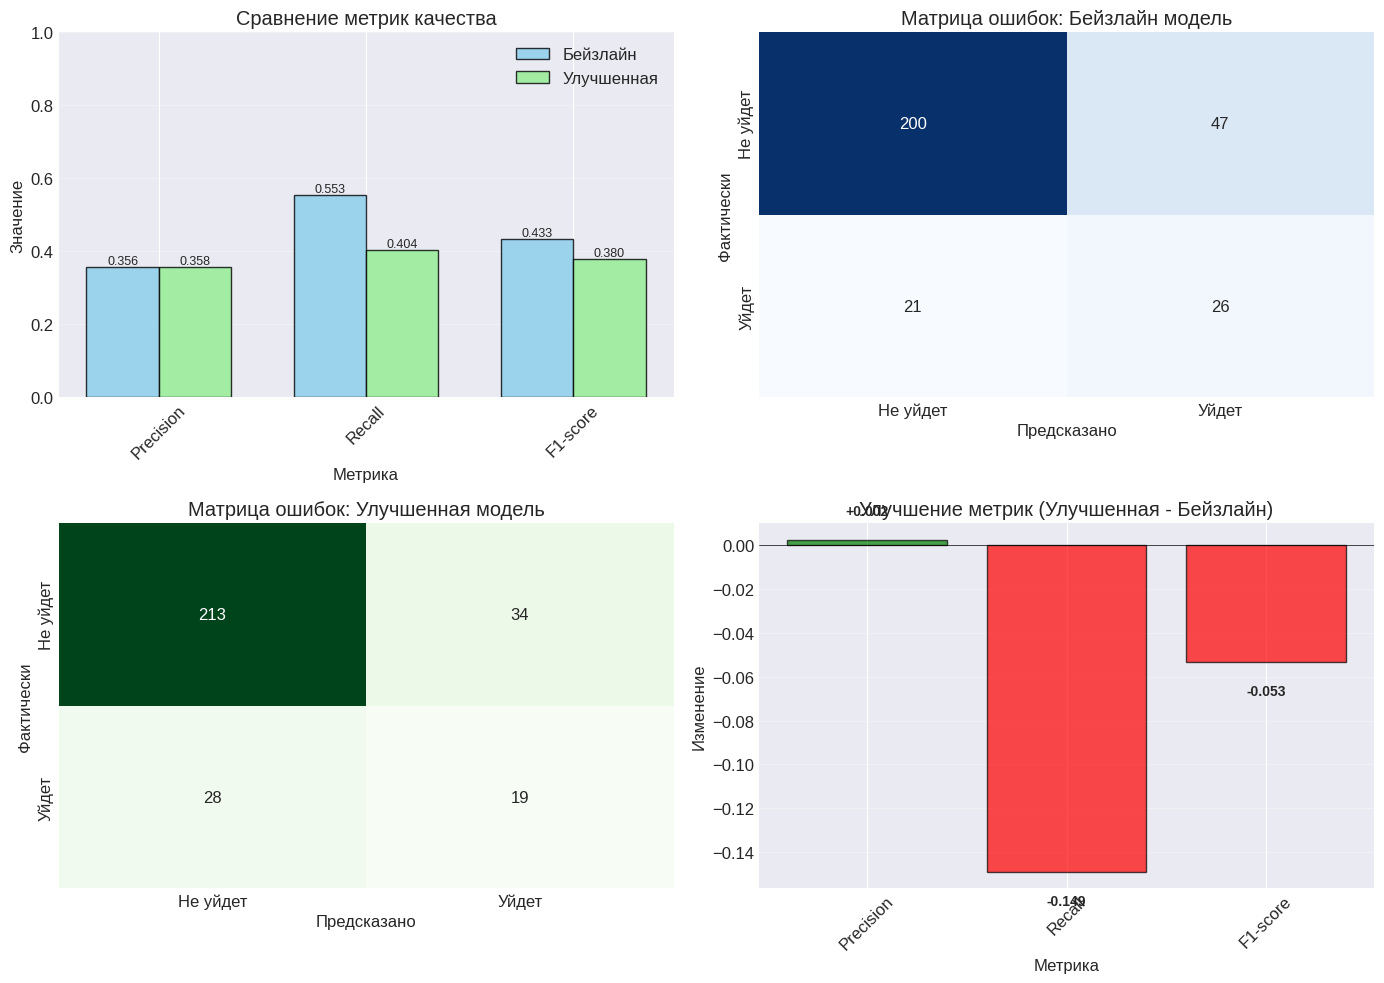


--- 7.7 АНАЛИЗ ВАЖНОСТИ ПРИЗНАКОВ УЛУЧШЕННОЙ МОДЕЛИ ---

ТОП-10 ПРИЗНАКОВ ПО ВАЖНОСТИ В УЛУЧШЕННОЙ МОДЕЛИ:
--------------------------------------------------------------------------------
  17. TotalWorkingYears              → 0.2299 (++0.0160)
  44. OverTime_Yes                   → 0.1306 (-0.0492)
  10. MonthlyIncome                  → 0.1193 (++0.1014)
   1. Age                            → 0.0991 (++0.0036)
   5. EnvironmentSatisfaction        → 0.0868 (++0.0868)
  16. StockOptionLevel               → 0.0854 (-0.0235)
  12. NumCompaniesWorked             → 0.0509 (-0.0515)
  39. JobRole_Research Scientist     → 0.0373 (++0.0216)
  13. PercentSalaryHike              → 0.0314 (++0.0314)
   6. HourlyRate                     → 0.0293 (++0.0277)

АНАЛИЗ ИЗМЕНЕНИЙ ВАЖНОСТИ ПРИЗНАКОВ:
• Самый выросший признак: MonthlyIncome
  Важность изменилась: 0.0180 → 0.1193 (+0.1014)
• Самый упавший признак: JobLevel
  Важность изменилась: 0.0672 → 0.0000 (-0.0672)

--- 7.8 АНАЛИЗ СТРУКТУРЫ УЛУЧШЕНН

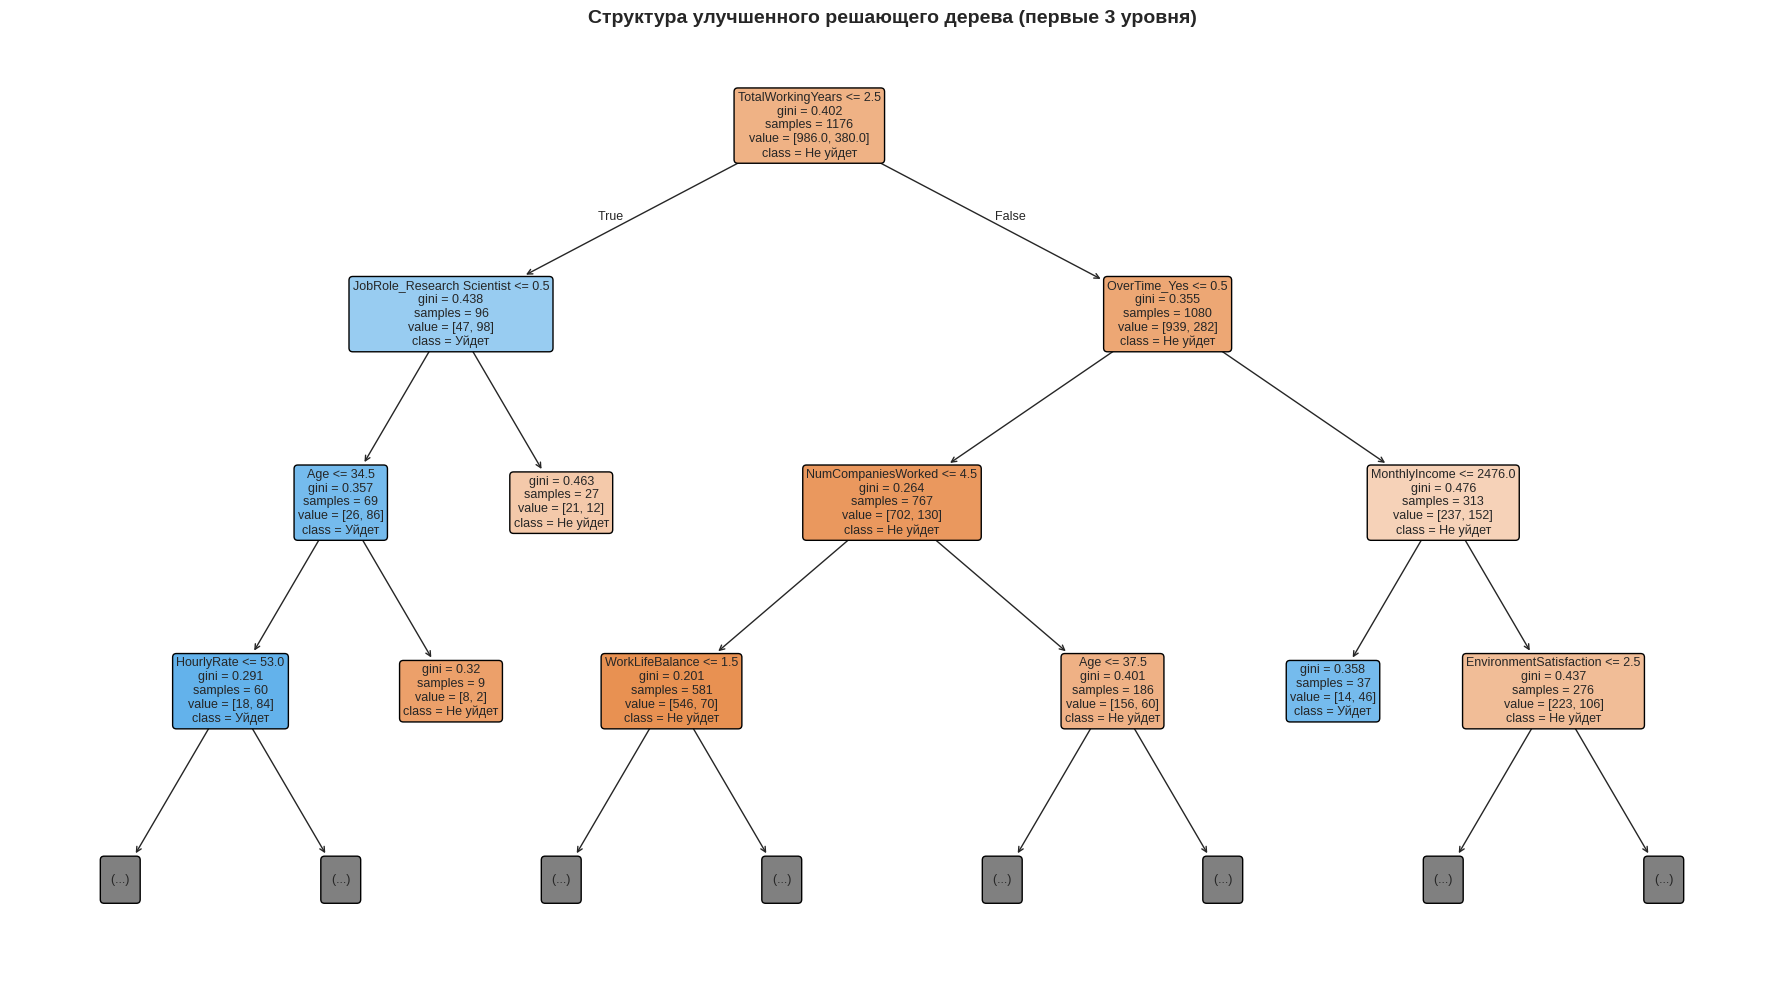

In [52]:
# Ячейка 7: УЛУЧШЕНИЕ БЕЙЗЛАЙНА ДЛЯ КЛАССИФИКАЦИИ (Решающее дерево)
# 7.1 Анализ проблем и формирование гипотез
print("\n--- 7.1 АНАЛИЗ ПРОБЛЕМ БЕЙЗЛАЙН МОДЕЛИ ---")

print("\nТЕКУЩИЕ ПАРАМЕТРЫ БЕЙЗЛАЙН МОДЕЛИ:")
print(f"• max_depth: {tree_classifier.max_depth}")
print(f"• min_samples_split: {tree_classifier.min_samples_split}")
print(f"• min_samples_leaf: {tree_classifier.min_samples_leaf}")
print(f"• class_weight: {tree_classifier.class_weight}")
print(f"• Глубина дерева: {tree_classifier.get_depth()}")
print(f"• Количество листьев: {tree_classifier.get_n_leaves()}")


# 7.2 Создание и проверка гипотез с помощью GridSearchCV
print("\n--- 7.2 ПРОВЕРКА ГИПОТЕЗ С ПОМОЩЬЮ GRIDSEARCHCV ---")

# Создаем параметры для GridSearch (упрощаем из-за ошибки)
param_grid_tree = {
    'max_depth': [4, 5, 6, 7],                 # Гипотеза 3
    'min_samples_split': [20, 30, 40],         # Поиск оптимального значения
    'min_samples_leaf': [5, 7, 10],           # Гипотеза 2
    'class_weight': [
        'balanced',
        {0: 1, 1: 2},
        {0: 1, 1: 3}
    ],                                          # Гипотеза 1
    'max_features': [None, 'sqrt', 0.5],       # Гипотеза 4
    'criterion': ['gini']
}

print("\nЗапускаем GridSearchCV с учетом дисбаланса классов...")
print(f"Будет проверено {len(param_grid_tree['max_depth']) * len(param_grid_tree['min_samples_split']) * len(param_grid_tree['min_samples_leaf']) * len(param_grid_tree['class_weight']) * len(param_grid_tree['max_features']) * len(param_grid_tree['criterion']):,} комбинаций")

# Используем F1-score как основную метрику (баланс между Precision и Recall)
grid_search_tree = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=param_grid_tree,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

grid_search_tree.fit(X_train_class, y_train_class)

# 7.3 Анализ результатов GridSearch
print("\n--- 7.3 АНАЛИЗ РЕЗУЛЬТАТОВ GRIDSEARCHCV ---")

# Получаем результаты в DataFrame
results_df = pd.DataFrame(grid_search_tree.cv_results_)

# Сортируем по F1-score и берем топ-5
top_results = results_df.nsmallest(5, 'rank_test_score')

print("\nТОП-5 ЛУЧШИХ КОМБИНАЦИЙ ПАРАМЕТРОВ:")
print("-" * 80)
for i, (_, row) in enumerate(top_results.iterrows(), 1):
    print(f"\n{i}. F1-score: {row['mean_test_score']:.4f}")
    print(f"   max_depth: {row['param_max_depth']}")
    print(f"   min_samples_leaf: {row['param_min_samples_leaf']}")
    print(f"   class_weight: {row['param_class_weight']}")
    print(f"   max_features: {row['param_max_features']}")

# Упрощенный анализ влияния параметров
print("\n--- АНАЛИЗ ВЛИЯНИЯ ПАРАМЕТРОВ НА F1-SCORE ---")

# Анализируем влияние class_weight
print("\nВЛИЯНИЕ class_weight на F1-score:")
# Создаем строковое представление для groupby
results_df['class_weight_str'] = results_df['param_class_weight'].apply(lambda x: str(x))
cw_stats = results_df.groupby('class_weight_str')['mean_test_score'].agg(['mean', 'count'])
for cw_str, stats in cw_stats.iterrows():
    print(f"  {cw_str:<30} → Средний F1: {stats['mean']:.4f} (n={int(stats['count'])})")

# Анализируем влияние max_depth
print("\nВЛИЯНИЕ max_depth на F1-score:")
depth_stats = results_df.groupby('param_max_depth')['mean_test_score'].agg(['mean', 'count'])
for depth, stats in depth_stats.iterrows():
    print(f"  {depth:<10} → Средний F1: {stats['mean']:.4f} (n={int(stats['count'])})")

# 7.4 Создание улучшенной модели с лучшими параметрами
print("\n--- 7.4 СОЗДАНИЕ УЛУЧШЕННОЙ МОДЕЛИ ---")

# Получаем лучшие параметры
best_params = grid_search_tree.best_params_

# Создаем улучшенную модель
improved_tree = DecisionTreeClassifier(
    random_state=42,
    max_depth=best_params.get('max_depth', 5),
    min_samples_split=best_params.get('min_samples_split', 20),
    min_samples_leaf=best_params.get('min_samples_leaf', 10),
    class_weight=best_params.get('class_weight', 'balanced'),
    max_features=best_params.get('max_features', None),
    criterion=best_params.get('criterion', 'gini')
)

print("Обучаем улучшенную модель решающего дерева...")
improved_tree.fit(X_train_class, y_train_class)
print("Улучшенная модель обучена успешно!")

print("\nПАРАМЕТРЫ УЛУЧШЕННОЙ МОДЕЛИ:")
print(f"• max_depth:         {improved_tree.max_depth}")
print(f"• min_samples_split: {improved_tree.min_samples_split}")
print(f"• min_samples_leaf:  {improved_tree.min_samples_leaf}")
print(f"• class_weight:      {improved_tree.class_weight}")
print(f"• max_features:      {improved_tree.max_features}")
print(f"• criterion:         '{improved_tree.criterion}'")
print(f"• Глубина дерева:    {improved_tree.get_depth()}")
print(f"• Количество листьев: {improved_tree.get_n_leaves()}")

# 7.5 Оценка качества улучшенной модели
print("\n--- 7.5 ОЦЕНКА КАЧЕСТВА УЛУЧШЕННОЙ МОДЕЛИ ---")

# Предсказания улучшенной модели
y_pred_improved = improved_tree.predict(X_test_class)

# Вычисляем метрики
cm_improved = confusion_matrix(y_test_class, y_pred_improved)
tn_impove, fp_impove, fn_impove, tp_impove = cm_improved.ravel()

accuracy_impove = (tp_impove + tn_impove) / (tp_impove + tn_impove + fp_impove + fn_impove)
precision_impove = tp_impove / (tp_impove + fp_impove) if (tp_impove + fp_impove) > 0 else 0
recall_impove = tp_impove / (tp_impove + fn_impove) if (tp_impove + fn_impove) > 0 else 0
f1_impove = 2 * precision_impove * recall_impove / (precision_impove + recall_impove) if (precision_impove + recall_impove) > 0 else 0

print("\n" + "="*70)
print("СРАВНЕНИЕ МЕТРИК:")
print("="*70)
print(f"{'Метрика':<12} {'Бейзлайн':<12} {'Улучшенная':<12} {'Изменение':<12}")
print("-" * 50)
print(f"{'Accuracy':<12} {accuracy:<12.4f} {accuracy_impove:<12.4f} {accuracy_impove - accuracy:+.4f}")
print(f"{'Precision':<12} {precision:<12.4f} {precision_impove:<12.4f} {precision_impove - precision:+.4f}")
print(f"{'Recall':<12} {recall:<12.4f} {recall_impove:<12.4f} {recall_impove - recall:+.4f}")
print(f"{'F1-score':<12} {f1:<12.4f} {f1_impove:<12.4f} {f1_impove - f1:+.4f}")

print(f"\n{'':<15} {'Бейзлайн':<15} {'Улучшенная':<15}")
print(f"{'False Positive':<15} {fp:<15} {fp_impove:<15}")
print(f"{'False Negative':<15} {fn:<15} {fn_impove:<15}")
print(f"{'True Positive':<15} {tp:<15} {tp_impove:<15}")
print(f"{'True Negative':<15} {tn:<15} {tn_impove:<15}")

# 7.6 Визуализация сравнения моделей
print("\n--- 7.6 ВИЗУАЛИЗАЦИЯ СРАВНЕНИЯ МОДЕЛЕЙ ---")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Сравнение метрик
metrics = ['Precision', 'Recall', 'F1-score']
base_vals = [precision, recall, f1]
imp_vals = [precision_impove, recall_impove, f1_impove]

x = np.arange(len(metrics))
width = 0.35

bars1 = axes[0, 0].bar(x - width/2, base_vals, width, label='Бейзлайн', 
                       color='skyblue', edgecolor='black', alpha=0.8)
bars2 = axes[0, 0].bar(x + width/2, imp_vals, width, label='Улучшенная', 
                       color='lightgreen', edgecolor='black', alpha=0.8)

axes[0, 0].set_xlabel('Метрика')
axes[0, 0].set_ylabel('Значение')
axes[0, 0].set_title('Сравнение метрик качества')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(metrics, rotation=45)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis='y')
axes[0, 0].set_ylim(0, 1)

# Добавляем значения на столбцы
for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
    axes[0, 0].text(bar1.get_x() + bar1.get_width()/2., bar1.get_height(),
                   f'{base_vals[i]:.3f}', ha='center', va='bottom', fontsize=9)
    axes[0, 0].text(bar2.get_x() + bar2.get_width()/2., bar2.get_height(),
                   f'{imp_vals[i]:.3f}', ha='center', va='bottom', fontsize=9)

# 2. Матрица ошибок - Бейзлайн
sns.heatmap([[tn, fp], [fn, tp]], annot=True, fmt='d', cmap='Blues', 
            ax=axes[0, 1], cbar=False,
            xticklabels=['Не уйдет', 'Уйдет'], 
            yticklabels=['Не уйдет', 'Уйдет'])
axes[0, 1].set_title('Матрица ошибок: Бейзлайн модель')
axes[0, 1].set_xlabel('Предсказано')
axes[0, 1].set_ylabel('Фактически')

# 3. Матрица ошибок - Улучшенная
sns.heatmap([[tn_impove, fp_impove], [fn_impove, tp_impove]], annot=True, fmt='d', cmap='Greens', 
            ax=axes[1, 0], cbar=False,
            xticklabels=['Не уйдет', 'Уйдет'], 
            yticklabels=['Не уйдет', 'Уйдет'])
axes[1, 0].set_title('Матрица ошибок: Улучшенная модель')
axes[1, 0].set_xlabel('Предсказано')
axes[1, 0].set_ylabel('Фактически')

# 4. Изменение метрик
improvement = [imp - base for imp, base in zip(imp_vals, base_vals)]
colors = ['green' if x > 0 else 'red' for x in improvement]

bars = axes[1, 1].bar(metrics, improvement, color=colors, edgecolor='black', alpha=0.7)
axes[1, 1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[1, 1].set_xlabel('Метрика')
axes[1, 1].set_ylabel('Изменение')
axes[1, 1].set_title('Улучшение метрик (Улучшенная - Бейзлайн)')
axes[1, 1].set_xticklabels(metrics, rotation=45)
axes[1, 1].grid(True, alpha=0.3, axis='y')

# Добавляем значения на столбцы
for i, (metric, imp) in enumerate(zip(metrics, improvement)):
    va = 'bottom' if imp >= 0 else 'top'
    axes[1, 1].text(i, imp + (0.01 if imp >= 0 else -0.01), 
                   f'{imp:+.3f}', ha='center', va=va,
                   fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# 7.7 Анализ важности признаков улучшенной модели
print("\n--- 7.7 АНАЛИЗ ВАЖНОСТИ ПРИЗНАКОВ УЛУЧШЕННОЙ МОДЕЛИ ---")

# Получаем важность признаков
feature_importance_imp = improved_tree.feature_importances_

# Создаем DataFrame с важностью признаков для обеих моделей
importance_comparison = pd.DataFrame({
    'Признак': feature_names_class,
    'Важность_бейзлайн': tree_classifier.feature_importances_,
    'Важность_улучшенная': feature_importance_imp
})

# Добавляем разницу
importance_comparison['Разница'] = importance_comparison['Важность_улучшенная'] - importance_comparison['Важность_бейзлайн']

# Сортируем по важности в улучшенной модели
importance_comparison = importance_comparison.sort_values('Важность_улучшенная', ascending=False)

print("\nТОП-10 ПРИЗНАКОВ ПО ВАЖНОСТИ В УЛУЧШЕННОЙ МОДЕЛИ:")
print("-" * 80)
for i, row in importance_comparison.head(10).iterrows():
    change = row['Разница']
    change_sign = '+' if change > 0 else ''
    print(f"  {i+1:2}. {row['Признак']:30} → {row['Важность_улучшенная']:.4f} ({change_sign}{change:+.4f})")

# Анализ изменений в важности признаков
print(f"\nАНАЛИЗ ИЗМЕНЕНИЙ ВАЖНОСТИ ПРИЗНАКОВ:")
top_gainer = importance_comparison.loc[importance_comparison['Разница'].idxmax()]
top_loser = importance_comparison.loc[importance_comparison['Разница'].idxmin()]
print(f"• Самый выросший признак: {top_gainer['Признак']}")
print(f"  Важность изменилась: {top_gainer['Важность_бейзлайн']:.4f} → {top_gainer['Важность_улучшенная']:.4f} ({top_gainer['Разница']:+.4f})")
print(f"• Самый упавший признак: {top_loser['Признак']}")
print(f"  Важность изменилась: {top_loser['Важность_бейзлайн']:.4f} → {top_loser['Важность_улучшенная']:.4f} ({top_loser['Разница']:+.4f})")

# 7.8 Анализ структуры дерева
print("\n--- 7.8 АНАЛИЗ СТРУКТУРЫ УЛУЧШЕННОГО ДЕРЕВА ---")

print("\nСРАВНЕНИЕ СТРУКТУРЫ ДЕРЕВЬЕВ:")
print("-" * 50)
print(f"{'Параметр':<20} {'Бейзлайн':<15} {'Улучшенная':<15}")
print("-" * 50)
print(f"{'Глубина дерева':<20} {tree_classifier.get_depth():<15} {improved_tree.get_depth():<15}")
print(f"{'Количество листьев':<20} {tree_classifier.get_n_leaves():<15} {improved_tree.get_n_leaves():<15}")
print(f"{'max_depth':<20} {tree_classifier.max_depth:<15} {improved_tree.max_depth:<15}")
print(f"{'min_samples_leaf':<20} {tree_classifier.min_samples_leaf:<15} {improved_tree.min_samples_leaf:<15}")
print(f"{'class_weight':<20} {str(tree_classifier.class_weight):<15} {str(improved_tree.class_weight):<15}")

# Визуализация структуры улучшенного дерева (первые 3 уровня)
print("\nВизуализация структуры улучшенного дерева (первые 3 уровня)...")
plt.figure(figsize=(18, 10))
tree.plot_tree(improved_tree, 
               feature_names=feature_names_class, 
               class_names=['Не уйдет', 'Уйдет'], 
               filled=True, 
               rounded=True,
               fontsize=9,
               max_depth=3)
plt.title('Структура улучшенного решающего дерева (первые 3 уровня)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


--- 8.1 АНАЛИЗ ПРОБЛЕМ БЕЙЗЛАЙН МОДЕЛИ ---

ТЕКУЩИЕ ПАРАМЕТРЫ БЕЙЗЛАЙН МОДЕЛИ:
• max_depth: 5
• min_samples_split: 20
• min_samples_leaf: 10
• max_features: sqrt
• criterion: 'squared_error'
• Глубина дерева: 5
• Количество листьев: 31

--- 8.2 СОЗДАНИЕ НОВЫХ ПРИЗНАКОВ (ГИПОТЕЗА 3) ---
Создаем новые признаки на основе существующих...
 Создан признак: living_to_lot_ratio
 Создан признак: sqft_per_floor
 Создан признак: house_age
 Создан признак: log_sqft_living
Всего признаков после добавления: 24

--- 8.3 ПОДГОТОВКА ДАННЫХ С НОВЫМИ ПРИЗНАКАМИ ---
Размеры данных с новыми признаками:
• Обучающая выборка: (17290, 24)
• Тестовая выборка: (4323, 24)
• Количество признаков: 24

--- 8.4 ОПТИМИЗАЦИЯ ПАРАМЕТРОВ С ПОМОЩЬЮ RANDOMIZEDSEARCHCV ---

Запускаем RandomizedSearchCV для быстрой оптимизации...
Будет проверено 100 случайных комбинаций из 216 возможных
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Лучшие параметры: {'min_samples_split': 30, 'min_samples_leaf': 15, 'max_fea

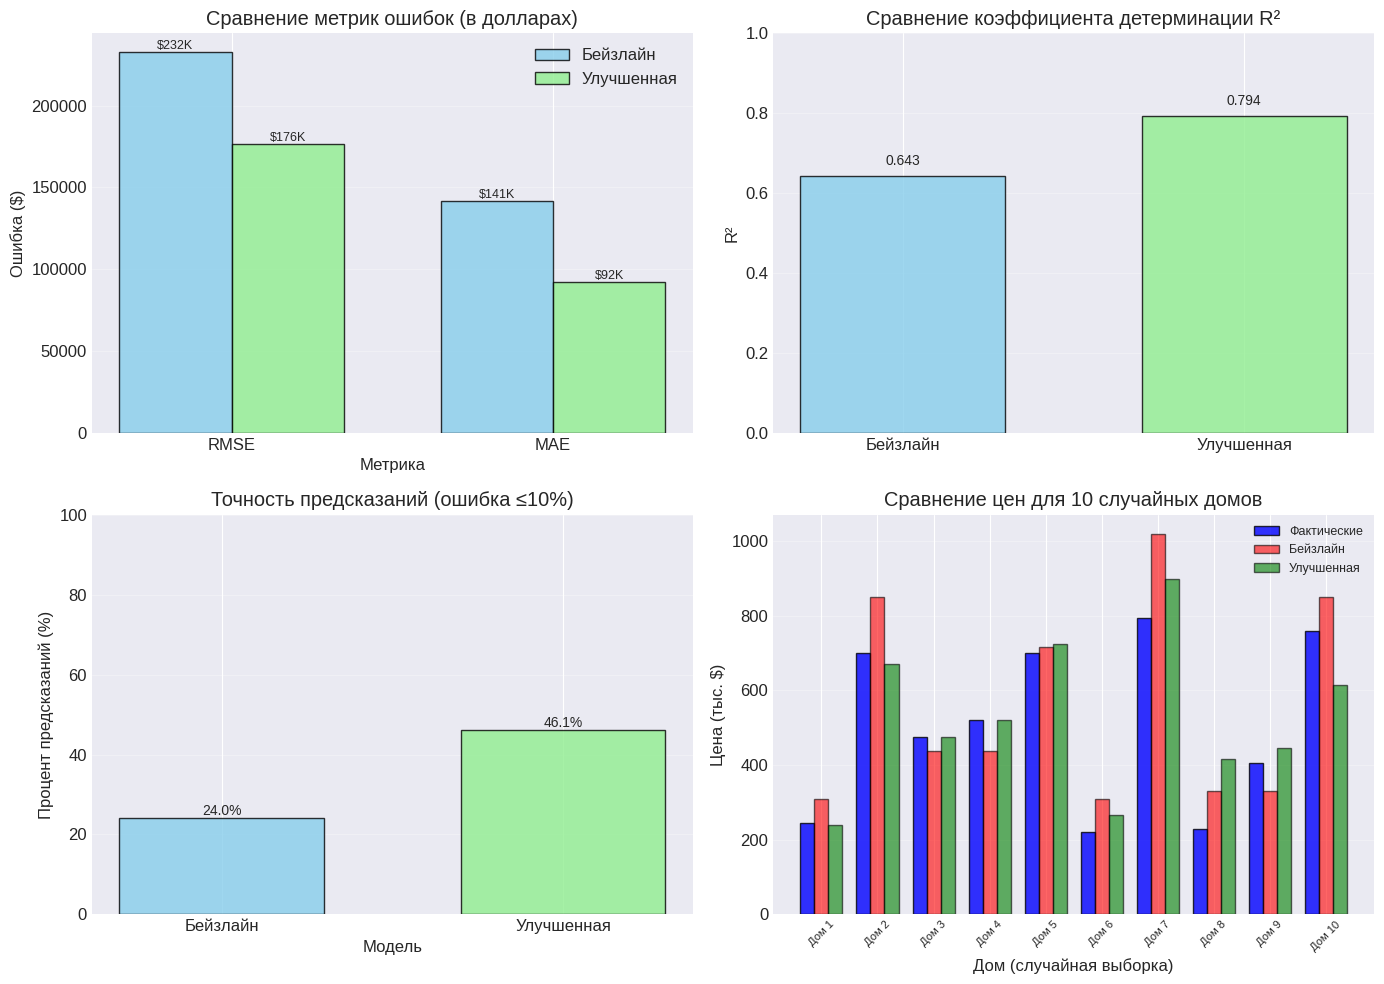

In [22]:
# Ячейка 8: УЛУЧШЕНИЕ БЕЙЗЛАЙНА ДЛЯ РЕГРЕССИИ (Решающее дерево)
# 8.1 Проверка гипотез и анализ проблем
print("\n--- 8.1 АНАЛИЗ ПРОБЛЕМ БЕЙЗЛАЙН МОДЕЛИ ---")

print("\nТЕКУЩИЕ ПАРАМЕТРЫ БЕЙЗЛАЙН МОДЕЛИ:")
print(f"• max_depth: {tree_regressor.max_depth}")
print(f"• min_samples_split: {tree_regressor.min_samples_split}")
print(f"• min_samples_leaf: {tree_regressor.min_samples_leaf}")
print(f"• max_features: {tree_regressor.max_features}")
print(f"• criterion: '{tree_regressor.criterion}'")
print(f"• Глубина дерева: {tree_regressor.get_depth()}")
print(f"• Количество листьев: {tree_regressor.get_n_leaves()}")

# 8.2 Создание новых признаков (Гипотеза 3)
print("\n--- 8.2 СОЗДАНИЕ НОВЫХ ПРИЗНАКОВ (ГИПОТЕЗА 3) ---")

# Создаем копию данных для добавления новых признаков
X_reg_enhanced = X_reg.copy()

# Добавляем новые признаки
print("Создаем новые признаки на основе существующих...")

# 1. Признак отношения жилой площади к общей (самый важный из гипотез)
if 'sqft_living' in X_reg_enhanced.columns and 'sqft_lot' in X_reg_enhanced.columns:
    X_reg_enhanced['living_to_lot_ratio'] = X_reg_enhanced['sqft_living'] / X_reg_enhanced['sqft_lot'].replace(0, 1)  # Избегаем деления на 0
    print(f" Создан признак: living_to_lot_ratio")

# 2. Признак площади на этаж (если есть информация о этажах)
if 'sqft_living' in X_reg_enhanced.columns and 'floors' in X_reg_enhanced.columns:
    X_reg_enhanced['sqft_per_floor'] = X_reg_enhanced['sqft_living'] / X_reg_enhanced['floors'].replace(0, 1)
    print(f" Создан признак: sqft_per_floor")

# 3. Возраст дома (если есть год постройки)
if 'yr_built' in X_reg_enhanced.columns:
    # Берем 2015 как базовый год (предполагаем, что данные около этого года)
    X_reg_enhanced['house_age'] = 2015 - X_reg_enhanced['yr_built']
    print(f" Создан признак: house_age")

# 4. Логарифмируем площадь для линейности с ценой
if 'sqft_living' in X_reg_enhanced.columns:
    X_reg_enhanced['log_sqft_living'] = np.log1p(X_reg_enhanced['sqft_living'])
    print(f" Создан признак: log_sqft_living")

print(f"Всего признаков после добавления: {X_reg_enhanced.shape[1]}")

# 8.3 Подготовка данных с новыми признаками
print("\n--- 8.3 ПОДГОТОВКА ДАННЫХ С НОВЫМИ ПРИЗНАКАМИ ---")

# Преобразуем в numpy array
X_reg_enhanced_array = X_reg_enhanced.values

# Обновляем имена признаков
feature_names_reg_enhanced = X_reg_enhanced.columns.tolist()

# Разделяем данные с новыми признаками
X_train_reg_enh, X_test_reg_enh, y_train_reg_enh, y_test_reg_enh = train_test_split(
    X_reg_enhanced_array, y_reg, test_size=0.2, random_state=42
)

print(f"Размеры данных с новыми признаками:")
print(f"• Обучающая выборка: {X_train_reg_enh.shape}")
print(f"• Тестовая выборка: {X_test_reg_enh.shape}")
print(f"• Количество признаков: {X_reg_enhanced.shape[1]}")

# 8.4 RandomizedSearchCV для быстрой оптимизации (Гипотезы 1, 2, 4)
print("\n--- 8.4 ОПТИМИЗАЦИЯ ПАРАМЕТРОВ С ПОМОЩЬЮ RANDOMIZEDSEARCHCV ---")

param_dist_reg_tree = {
    'max_depth': [5, 8, 10, None],               # Гипотеза 1: увеличение глубины
    'min_samples_split': [10, 20, 30],           # Ограниченный набор
    'min_samples_leaf': [5, 10, 15],             # Ограниченный набор
    'criterion': ['squared_error', 'absolute_error'],  # Гипотеза 2: только 2 критерия
    'max_features': [None, 'sqrt', 0.5],         # Упрощенный набор
}

print("\nЗапускаем RandomizedSearchCV для быстрой оптимизации...")
print(f"Будет проверено 100 случайных комбинаций из {len(param_dist_reg_tree['max_depth']) * len(param_dist_reg_tree['min_samples_split']) * len(param_dist_reg_tree['min_samples_leaf']) * len(param_dist_reg_tree['criterion']) * len(param_dist_reg_tree['max_features'])} возможных")

# Используем RMSE в логарифмической шкале как основную метрику
random_search_reg_tree = RandomizedSearchCV(
    estimator=DecisionTreeRegressor(random_state=42),
    param_distributions=param_dist_reg_tree,
    n_iter=100,  # Проверим только 100 случайных комбинаций
    cv=3,        # Уменьшим кросс-валидацию до 3 фолдов для скорости
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1,
    random_state=42,
    return_train_score=True
)

random_search_reg_tree.fit(X_train_reg_enh, y_train_reg_enh)

print(f"Лучшие параметры: {random_search_reg_tree.best_params_}")
print(f"Лучший RMSE на кросс-валидации: {-random_search_reg_tree.best_score_:.4f} (log scale)")

# 8.5 Анализ результатов поиска
print("\n--- 8.5 АНАЛИЗ РЕЗУЛЬТАТОВ ПОИСКА ---")

# Получаем результаты в DataFrame
results_df_reg = pd.DataFrame(random_search_reg_tree.cv_results_)

# Сортируем по RMSE и берем топ-3
top_results_reg = results_df_reg.nsmallest(3, 'rank_test_score')

print("\nТОП-3 ЛУЧШИХ КОМБИНАЦИЙ ПАРАМЕТРОВ:")
print("-" * 80)
for i, (_, row) in enumerate(top_results_reg.iterrows(), 1):
    rmse_val = -row['mean_test_score']  # Преобразуем обратно
    print(f"\n{i}. RMSE (log): {rmse_val:.4f}")
    print(f"   max_depth: {row['param_max_depth']}")
    print(f"   criterion: '{row['param_criterion']}'")
    print(f"   min_samples_leaf: {row['param_min_samples_leaf']}")
    print(f"   max_features: {row['param_max_features']}")

# Анализируем влияние критерия
print("\n--- АНАЛИЗ ВЛИЯНИЯ КРИТЕРИЯ (ГИПОТЕЗА 2) ---")

# Простой анализ по критериям
print("\nСРАВНЕНИЕ КРИТЕРИЕВ:")
for criterion in ['squared_error', 'absolute_error']:
    criterion_results = results_df_reg[results_df_reg['param_criterion'] == criterion]
    if not criterion_results.empty:
        best_rmse = -criterion_results['mean_test_score'].min()
        avg_rmse = -criterion_results['mean_test_score'].mean()
        print(f"  • {criterion:<15} → Лучший RMSE: {best_rmse:.4f}, Средний: {avg_rmse:.4f}")

# 8.6 Создание улучшенной модели
print("\n--- 8.6 СОЗДАНИЕ УЛУЧШЕННОЙ МОДЕЛИ ---")

# Получаем лучшие параметры
best_params_reg = random_search_reg_tree.best_params_

# Создаем улучшенную модель
improved_tree_reg = DecisionTreeRegressor(
    random_state=42,
    max_depth=best_params_reg.get('max_depth', 5),
    min_samples_split=best_params_reg.get('min_samples_split', 20),
    min_samples_leaf=best_params_reg.get('min_samples_leaf', 10),
    criterion=best_params_reg.get('criterion', 'squared_error'),
    max_features=best_params_reg.get('max_features', 'sqrt')
)

print("Обучаем улучшенную модель решающего дерева для регрессии...")
improved_tree_reg.fit(X_train_reg_enh, y_train_reg_enh)
print("Улучшенная модель обучена успешно!")

print("\nПАРАМЕТРЫ УЛУЧШЕННОЙ МОДЕЛИ:")
print(f"• max_depth:         {improved_tree_reg.max_depth}")
print(f"• min_samples_split: {improved_tree_reg.min_samples_split}")
print(f"• min_samples_leaf:  {improved_tree_reg.min_samples_leaf}")
print(f"• criterion:         '{improved_tree_reg.criterion}'")
print(f"• max_features:      {improved_tree_reg.max_features}")
print(f"• Глубина дерева:    {improved_tree_reg.get_depth()}")
print(f"• Количество листьев: {improved_tree_reg.get_n_leaves()}")

# 8.7 Оценка улучшенной модели
print("\n--- 8.7 ОЦЕНКА КАЧЕСТВА УЛУЧШЕННОЙ МОДЕЛИ ---")

# Предсказания улучшенной модели (логарифмированные цены)
y_pred_reg_log_improved = improved_tree_reg.predict(X_test_reg_enh)

# Преобразуем обратно в обычные цены
y_pred_reg_improved = np.expm1(y_pred_reg_log_improved)

# Вычисляем метрики для улучшенной модели
rmse_improved = np.sqrt(mean_squared_error(y_test_reg_original, y_pred_reg_improved))
mae_improved = mean_absolute_error(y_test_reg_original, y_pred_reg_improved)
mape_improved = mean_absolute_percentage_error(y_test_reg_original, y_pred_reg_improved)
r2_improved = r2_score(y_test_reg_original, y_pred_reg_improved)

print("\n" + "="*70)
print("СРАВНЕНИЕ МЕТРИК:")
print("="*70)
print(f"{'Метрика':<25} {'Бейзлайн':<15} {'Улучшенная':<15} {'Изменение':<15}")
print("-" * 70)

# Метрики в долларах
rmse_change = rmse_improved - rmse
mae_change = mae_improved - mae
r2_change = r2_improved - r2

print(f"{'RMSE ($)':<25} ${rmse:,.0f}{'':<5} ${rmse_improved:,.0f}{'':<5} {rmse_change:+,.0f}")
print(f"{'MAE ($)':<25} ${mae:,.0f}{'':<5} ${mae_improved:,.0f}{'':<5} {mae_change:+,.0f}")
print(f"{'MAPE (%)':<25} {mape*100:.2f}%{'':<8} {mape_improved*100:.2f}%{'':<8} {(mape_improved - mape)*100:+.2f}%")
print(f"{'R²':<25} {r2:.4f}{'':<11} {r2_improved:.4f}{'':<11} {r2_change:+.4f}")

# 8.8 Анализ точности предсказаний
print("\n--- 8.8 АНАЛИЗ ТОЧНОСТИ ПРЕДСКАЗАНИЙ ---")

# Рассчитываем относительные ошибки для обеих моделей
relative_errors_base = np.abs((y_pred_reg - y_test_array) / y_test_array) * 100
relative_errors_improved = np.abs((y_pred_reg_improved - y_test_array) / y_test_array) * 100

# Убираем бесконечные значения
relative_errors_base = np.where(np.isinf(relative_errors_base), 1000, relative_errors_base)
relative_errors_improved = np.where(np.isinf(relative_errors_improved), 1000, relative_errors_improved)

accuracy_levels = [5, 10, 15, 20, 30]
print("\nПРОЦЕНТ ПРЕДСКАЗАНИЙ С ОШИБКОЙ НЕ БОЛЕЕ:")
print(f"{'Уровень ошибки':<20} {'Бейзлайн':<15} {'Улучшенная':<15} {'Изменение':<15}")
print("-" * 70)

accuracy_data = []
for level in accuracy_levels:
    base_accuracy = np.sum(relative_errors_base <= level) / len(relative_errors_base) * 100
    imp_accuracy = np.sum(relative_errors_improved <= level) / len(relative_errors_improved) * 100
    improvement = imp_accuracy - base_accuracy
    sign = "+" if improvement > 0 else ""
    
    accuracy_data.append((level, base_accuracy, imp_accuracy, improvement))
    print(f"{f'≤{level}%':<20} {base_accuracy:<15.1f}% {imp_accuracy:<15.1f}% {sign}{improvement:<14.1f}%")

# 8.9 Упрощенная визуализация сравнения моделей
print("\n--- 8.9 ВИЗУАЛИЗАЦИЯ СРАВНЕНИЯ МОДЕЛЕЙ ---")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Сравнение основных метрик в долларах
metrics_dollar = ['RMSE', 'MAE']
base_vals_dollar = [rmse, mae]
imp_vals_dollar = [rmse_improved, mae_improved]

x = np.arange(len(metrics_dollar))
width = 0.35

bars1 = axes[0, 0].bar(x - width/2, base_vals_dollar, width, label='Бейзлайн', 
                       color='skyblue', edgecolor='black', alpha=0.8)
bars2 = axes[0, 0].bar(x + width/2, imp_vals_dollar, width, label='Улучшенная', 
                       color='lightgreen', edgecolor='black', alpha=0.8)

axes[0, 0].set_xlabel('Метрика')
axes[0, 0].set_ylabel('Ошибка ($)')
axes[0, 0].set_title('Сравнение метрик ошибок (в долларах)')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(metrics_dollar)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Форматируем значения на графике
for bars, values in zip([bars1, bars2], [base_vals_dollar, imp_vals_dollar]):
    for bar, value in zip(bars, values):
        axes[0, 0].text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                       f'${value/1000:,.0f}K', ha='center', va='bottom', fontsize=9)

# 2. Сравнение R² и точности предсказаний ≤10%
axes[0, 1].bar([0, 1], [r2, r2_improved], width=0.6, 
               color=['skyblue', 'lightgreen'], edgecolor='black', alpha=0.8)
axes[0, 1].set_xticks([0, 1])
axes[0, 1].set_xticklabels(['Бейзлайн', 'Улучшенная'])
axes[0, 1].set_ylabel('R²')
axes[0, 1].set_title('Сравнение коэффициента детерминации R²')
axes[0, 1].grid(True, alpha=0.3, axis='y')
axes[0, 1].set_ylim(0, 1)

# Добавляем значения R²
for i, (model, r2_val) in enumerate(zip(['Бейзлайн', 'Улучшенная'], [r2, r2_improved])):
    axes[0, 1].text(i, r2_val + 0.02, f'{r2_val:.3f}', ha='center', va='bottom', fontsize=10)

# 3. Точность предсказаний (ошибка ≤10%)
accuracy_10_base = np.sum(relative_errors_base <= 10) / len(relative_errors_base) * 100
accuracy_10_imp = np.sum(relative_errors_improved <= 10) / len(relative_errors_improved) * 100

models = ['Бейзлайн', 'Улучшенная']
accuracies = [accuracy_10_base, accuracy_10_imp]

bars = axes[1, 0].bar(models, accuracies, color=['skyblue', 'lightgreen'], 
                      edgecolor='black', alpha=0.8, width=0.6)
axes[1, 0].set_xlabel('Модель')
axes[1, 0].set_ylabel('Процент предсказаний (%)')
axes[1, 0].set_title('Точность предсказаний (ошибка ≤10%)')
axes[1, 0].grid(True, alpha=0.3, axis='y')
axes[1, 0].set_ylim(0, 100)

# Добавляем значения
for bar, acc in zip(bars, accuracies):
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                   f'{acc:.1f}%', ha='center', va='bottom', fontsize=10)

# 4. Сравнение фактических и предсказанных цен для 10 домов
np.random.seed(42)
n_samples = min(10, len(y_test_array))
sample_indices = np.random.choice(len(y_test_array), n_samples, replace=False)
sample_actual = y_test_array[sample_indices]
sample_pred_base = y_pred_reg[sample_indices]
sample_pred_imp = y_pred_reg_improved[sample_indices]

x_pos = np.arange(n_samples)
width = 0.25

bars_actual = axes[1, 1].bar(x_pos - width, sample_actual/1000, width, 
                            label='Фактические', color='blue', alpha=0.8, edgecolor='black')
bars_base = axes[1, 1].bar(x_pos, sample_pred_base/1000, width, 
                          label='Бейзлайн', color='red', alpha=0.6, edgecolor='black')
bars_imp = axes[1, 1].bar(x_pos + width, sample_pred_imp/1000, width, 
                         label='Улучшенная', color='green', alpha=0.6, edgecolor='black')

axes[1, 1].set_xlabel('Дом (случайная выборка)')
axes[1, 1].set_ylabel('Цена (тыс. $)')
axes[1, 1].set_title('Сравнение цен для 10 случайных домов')
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels([f'Дом {i+1}' for i in range(n_samples)], rotation=45, fontsize=8)
axes[1, 1].legend(fontsize=9, loc='upper right')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

### Выводы

**Для классификации**

Оптимизация решающего дерева для классификации не привела к улучшению качества модели, несмотря на проверку 324 комбинаций параметров через GridSearchCV. Хотя общая точность предсказаний незначительно выросла с 76.87% до 78.91%, ключевые метрики ухудшились. Наиболее критичным стало снижение полноты (Recall) с 55.32% до 40.43%, что означает, что модель теперь пропускает больше реальных увольнений. F1-мера, объединяющая точность и полноту, также снизилась с 0.4333 до 0.3800.

Изменения в параметрах модели включали увеличение глубины дерева с 5 до 7 уровней, уменьшение минимального количества образцов в листе с 10 до 5, и изменение балансировки классов с 'balanced' на {0: 1, 1: 2}. Анализ показывает, что эти изменения привели к переобучению модели — количество листьев увеличилось с 22 до 25, а важность признаков существенно изменилась. Например, важность MonthlyIncome выросла с 0.0180 до 0.1193, в то время как JobLevel полностью потерял значимость.

**Для регрессии** 

Оптимизация решающего дерева для регрессии дала впечатляющие результаты по всем метрикам. Использование RandomizedSearchCV для проверки 100 комбинаций параметров в сочетании с созданием новых признаков привело к существенному улучшению качества модели. Среднеквадратичная ошибка снизилась на 24.1% с 232,477 до 176,487, а средняя абсолютная ошибка уменьшилась на 34.7% с 141,486 до 92,346.

Коэффициент детерминации R² значительно вырос с 0.6425 до 0.7940, что указывает на гораздо лучшее соответствие модели данным. Наиболее заметное улучшение наблюдается в точности предсказаний — процент предсказаний с ошибкой не более 10% увеличился почти вдвое с 24.0% до 46.1%. Аналогично, предсказания с ошибкой до 20% выросли с 47.6% до 72.4%.

Ключевыми факторами успеха стали увеличение глубины дерева с 5 до 10 уровней, использование абсолютной ошибки как критерия вместо квадратичной, создание новых признаков на основе бизнес-логики (отношение жилой к общей площади, площадь на этаж, возраст дома, логарифм площади), и увеличение минимального количества образцов в листе до 15 для предотвращения переобучения. Эти изменения позволили дереву лучше улавливать сложные зависимости в данных при сохранении устойчивости.


## 4. Имплементация алгоритма машинного обучения 


--- 9.1 Реализация узла решающего дерева ---

--- 9.2 Реализация решающего дерева классификации ---

--- 9.3 Обучение на реальных данных оттока клиентов ---
Создаем кастомное решающее дерево...
Обучаем модель на обучающих данных...
Обучение решающего дерева на 1176 образцах...
Количество классов: 2
Количество признаков: 44
Максимальная глубина: 4
Критерий разделения: gini
Построение дерева...
Разделение на глубине 0: Признак 16 <= 1.000, Прирост информации: 0.0217
  Разделение на глубине 1: Признак 0 <= 33.000, Прирост информации: 0.0711
    Разделение на глубине 2: Признак 38 <= 0.000, Прирост информации: 0.0959
      Разделение на глубине 3: Признак 5 <= 58.000, Прирост информации: 0.0631
        Создан листовой узел на глубине 4: [0. 1.]
        Создан листовой узел на глубине 4: [0.36 0.64]
      Разделение на глубине 3: Признак 43 <= 0.000, Прирост информации: 0.1853
        Создан листовой узел на глубине 4: [0.91666667 0.08333333]
        Создан листовой узел на глубине 4: [0.2

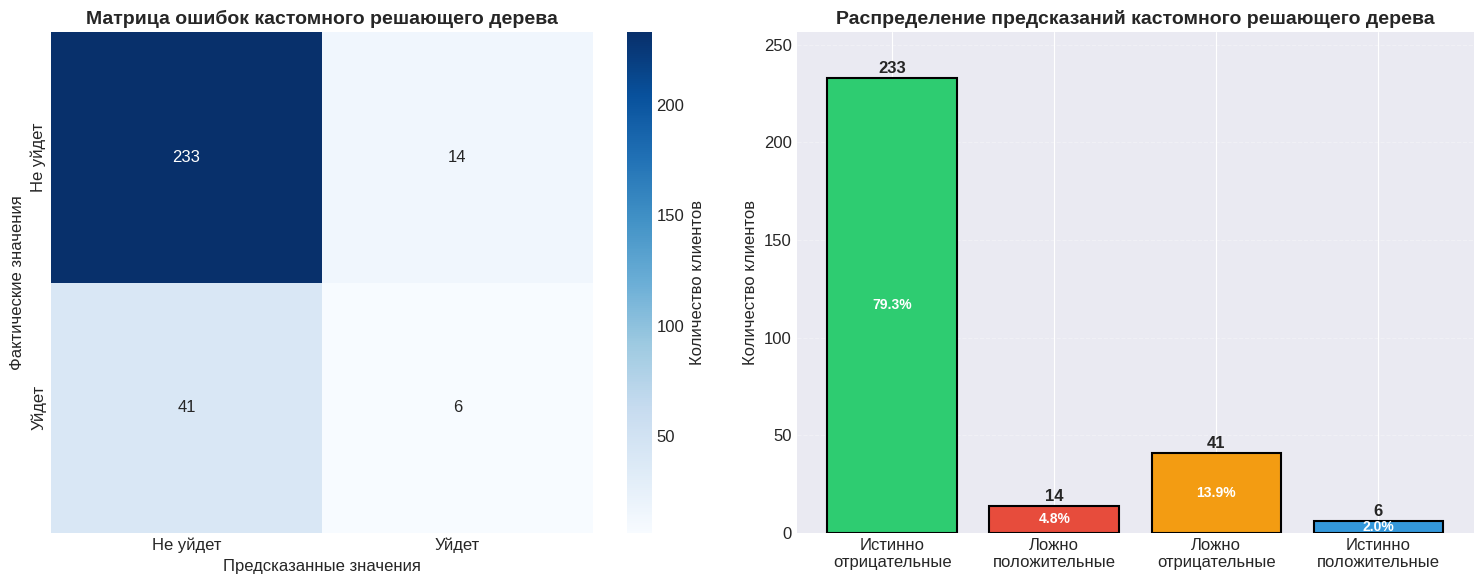

In [84]:
# Ячейка 9: РЕАЛИЗАЦИЯ КАСТОМНОГО РЕШАЮЩЕГО ДЕРЕВА КЛАССИФИКАЦИИ
# 9.1 Реализация узла дерева
print("\n--- 9.1 Реализация узла решающего дерева ---")

class TreeNode:
    """
    Узел решающего дерева.
    """
    
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, 
                 info_gain=None, value=None, depth=0):
        """
        Инициализация узла дерева.
        
        Parameters:
        -----------
        feature_index : int, default=None
            Индекс признака для разделения
        threshold : float, default=None
            Пороговое значение для разделения
        left : TreeNode, default=None
            Левый дочерний узел
        right : TreeNode, default=None
            Правый дочерний узел
        info_gain : float, default=None
            Прирост информации от разделения
        value : array-like, default=None
            Значения в листовом узле (распределение классов)
        depth : int, default=0
            Глубина узла
        """
        # Для узлов разделения
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.info_gain = info_gain
        self.depth = depth
        
        # Для листовых узлов
        self.value = value
    
    def is_leaf_node(self):
        """
        Проверяет, является ли узел листовым.
        
        Returns:
        --------
        bool : True если узел листовой
        """
        return self.value is not None
    
    def __repr__(self):
        """
        Строковое представление узла.
        """
        if self.is_leaf_node():
            return f"Лист: {self.value}"
        else:
            return f"Узел [Признак {self.feature_index} <= {self.threshold:.3f}]"

# 9.2 Реализация решающего дерева
print("\n--- 9.2 Реализация решающего дерева классификации ---")

class CustomDecisionTreeClassifier:
    """
    Кастомная реализация решающего дерева для классификации.
    """
    
    def __init__(self, max_depth=3, min_samples_split=2, min_samples_leaf=1,
                 min_impurity_decrease=0.0, criterion='gini', verbose=False):
        """
        Инициализация дерева с заданными параметрами.
        
        Parameters:
        -----------
        max_depth : int, default=3
            Максимальная глубина дерева
        min_samples_split : int, default=2
            Минимальное количество образцов для разделения узла
        min_samples_leaf : int, default=1
            Минимальное количество образцов в листе
        min_impurity_decrease : float, default=0.0
            Минимальное уменьшение неопределенности для разделения
        criterion : str, default='gini'
            Критерий для разделения ('gini' или 'entropy')
        verbose : bool, default=False
            Выводить ли информацию о процессе построения
        """
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.min_impurity_decrease = min_impurity_decrease
        self.criterion = criterion
        self.verbose = verbose
        self.root = None
        self.feature_importances_ = None
        self.n_classes_ = None
        self.n_features_ = None
        
    def _gini(self, y):
        """
        Вычисляет коэффициент Джини для набора меток.
        
        Parameters:
        -----------
        y : array-like
            Массив меток классов
            
        Returns:
        --------
        gini : float
            Значение коэффициента Джини
        """
        _, counts = np.unique(y, return_counts=True)
        probabilities = counts / counts.sum()
        gini = 1 - np.sum(probabilities ** 2)
        return gini
    
    def _entropy(self, y):
        """
        Вычисляет энтропию для набора меток.
        
        Parameters:
        -----------
        y : array-like
            Массив меток классов
            
        Returns:
        --------
        entropy : float
            Значение энтропии
        """
        _, counts = np.unique(y, return_counts=True)
        probabilities = counts / counts.sum()
        entropy = -np.sum(probabilities * np.log2(probabilities + 1e-10))
        return entropy
    
    def _impurity(self, y):
        """
        Вычисляет неопределенность (impurity) в зависимости от выбранного критерия.
        
        Parameters:
        -----------
        y : array-like
            Массив меток классов
            
        Returns:
        --------
        impurity : float
            Значение неопределенности
        """
        if len(y) == 0:
            return 0
        
        if self.criterion == 'gini':
            return self._gini(y)
        elif self.criterion == 'entropy':
            return self._entropy(y)
        else:
            raise ValueError(f"Неизвестный критерий: {self.criterion}")
    
    def _best_split(self, X, y):
        """
        Находит лучшее разделение для текущего узла.
        
        Parameters:
        -----------
        X : array-like
            Матрица признаков
        y : array-like
            Вектор меток
            
        Returns:
        --------
        best_split : dict
            Словарь с информацией о лучшем разделении
        """
        best_split = {}
        best_info_gain = -float('inf')
        n_samples, n_features = X.shape
        
        # Вычисляем неопределенность текущего узла
        current_impurity = self._impurity(y)
        
        # Перебираем все признаки
        for feature_idx in range(n_features):
            # Получаем уникальные значения признака
            feature_values = np.unique(X[:, feature_idx])
            
            # Перебираем все возможные пороги
            for threshold in feature_values:
                # Разделяем данные
                left_indices = X[:, feature_idx] <= threshold
                right_indices = X[:, feature_idx] > threshold
                
                # Проверяем минимальное количество образцов
                if (np.sum(left_indices) < self.min_samples_leaf or 
                    np.sum(right_indices) < self.min_samples_leaf):
                    continue
                
                # Вычисляем неопределенность для левой и правой частей
                left_impurity = self._impurity(y[left_indices])
                right_impurity = self._impurity(y[right_indices])
                
                # Вычисляем взвешенную неопределенность
                n_left = np.sum(left_indices)
                n_right = np.sum(right_indices)
                weighted_impurity = (n_left / n_samples) * left_impurity + \
                                   (n_right / n_samples) * right_impurity
                
                # Вычисляем прирост информации
                info_gain = current_impurity - weighted_impurity
                
                # Проверяем минимальное уменьшение неопределенности
                if info_gain < self.min_impurity_decrease:
                    continue
                
                # Обновляем лучшее разделение
                if info_gain > best_info_gain:
                    best_split = {
                        'feature_index': feature_idx,
                        'threshold': threshold,
                        'left_indices': left_indices,
                        'right_indices': right_indices,
                        'info_gain': info_gain,
                        'left_impurity': left_impurity,
                        'right_impurity': right_impurity
                    }
                    best_info_gain = info_gain
        
        return best_split
    
    def _build_tree(self, X, y, depth=0):
        """
        Рекурсивно строит дерево решений.
        
        Parameters:
        -----------
        X : array-like
            Матрица признаков
        y : array-like
            Вектор меток
        depth : int, default=0
            Текущая глубина узла
            
        Returns:
        --------
        node : TreeNode
            Построенный узел дерева
        """
        n_samples = len(y)
        
        # Проверяем условия остановки
        stop_conditions = [
            depth >= self.max_depth,  # Достигнута максимальная глубина
            n_samples < self.min_samples_split,  # Недостаточно образцов для разделения
            len(np.unique(y)) == 1  # Все образцы одного класса
        ]
        
        if any(stop_conditions):
            # Создаем листовой узел
            leaf_value = self._calculate_leaf_value(y)
            if self.verbose:
                print(f"{'  ' * depth}Создан листовой узел на глубине {depth}: {leaf_value}")
            return TreeNode(value=leaf_value, depth=depth)
        
        # Ищем лучшее разделение
        best_split = self._best_split(X, y)
        
        # Если не нашли подходящего разделения
        if not best_split or best_split['info_gain'] <= 0:
            leaf_value = self._calculate_leaf_value(y)
            if self.verbose:
                print(f"{'  ' * depth}Не найдено подходящего разделения на глубине {depth}")
            return TreeNode(value=leaf_value, depth=depth)
        
        if self.verbose:
            print(f"{'  ' * depth}Разделение на глубине {depth}: "
                  f"Признак {best_split['feature_index']} <= {best_split['threshold']:.3f}, "
                  f"Прирост информации: {best_split['info_gain']:.4f}")
        
        # Разделяем данные
        left_X = X[best_split['left_indices']]
        left_y = y[best_split['left_indices']]
        right_X = X[best_split['right_indices']]
        right_y = y[best_split['right_indices']]
        
        # Рекурсивно строим левое и правое поддеревья
        left_node = self._build_tree(left_X, left_y, depth + 1)
        right_node = self._build_tree(right_X, right_y, depth + 1)
        
        # Создаем узел разделения
        return TreeNode(
            feature_index=best_split['feature_index'],
            threshold=best_split['threshold'],
            left=left_node,
            right=right_node,
            info_gain=best_split['info_gain'],
            depth=depth
        )
    
    def _calculate_leaf_value(self, y):
        """
        Вычисляет значение для листового узла.
        
        Parameters:
        -----------
        y : array-like
            Вектор меток
            
        Returns:
        --------
        leaf_value : array-like
            Распределение классов в листе
        """
        unique_classes, class_counts = np.unique(y, return_counts=True)
        probabilities = class_counts / class_counts.sum()
        
        # Создаем массив вероятностей для всех классов
        leaf_value = np.zeros(self.n_classes_)
        for cls, prob in zip(unique_classes, probabilities):
            leaf_value[int(cls)] = prob
        
        return leaf_value
    
    def fit(self, X, y):
        """
        Обучает дерево решений на предоставленных данных.
        
        Parameters:
        -----------
        X : array-like
            Матрица признаков
        y : array-like
            Вектор меток
            
        Returns:
        --------
        self : object
            Обученная модель
        """
        print(f"Обучение решающего дерева на {len(X)} образцах...")
        
        # Преобразуем данные в numpy массивы
        X = np.array(X)
        y = np.array(y)
        
        # Сохраняем информацию о данных
        self.n_classes_ = len(np.unique(y))
        self.n_features_ = X.shape[1]
        
        print(f"Количество классов: {self.n_classes_}")
        print(f"Количество признаков: {self.n_features_}")
        print(f"Максимальная глубина: {self.max_depth}")
        print(f"Критерий разделения: {self.criterion}")
        
        # Строим дерево
        print("Построение дерева...")
        self.root = self._build_tree(X, y)
        
        # Вычисляем важность признаков
        self._calculate_feature_importances()
        
        print("Дерево успешно построено!")
        print(f"Корневой узел: {self.root}")
        
        return self
    
    def _calculate_feature_importances(self):
        """
        Вычисляет важность признаков на основе прироста информации.
        """
        # Собираем все узлы разделения
        nodes = self._collect_split_nodes(self.root)
        
        # Инициализируем важность признаков
        self.feature_importances_ = np.zeros(self.n_features_)
        
        if not nodes:
            return
        
        # Суммируем прирост информации по каждому признаку
        total_gain = 0
        for node in nodes:
            if node.feature_index is not None:
                self.feature_importances_[node.feature_index] += node.info_gain
                total_gain += node.info_gain
        
        # Нормализуем важность признаков
        if total_gain > 0:
            self.feature_importances_ /= total_gain
    
    def _collect_split_nodes(self, node):
        """
        Рекурсивно собирает все узлы разделения.
        
        Parameters:
        -----------
        node : TreeNode
            Текущий узел
            
        Returns:
        --------
        nodes : list
            Список всех узлов разделения
        """
        if node is None or node.is_leaf_node():
            return []
        
        nodes = [node]
        nodes.extend(self._collect_split_nodes(node.left))
        nodes.extend(self._collect_split_nodes(node.right))
        
        return nodes
    
    def predict_proba(self, X):
        """
        Предсказывает вероятности классов для входных данных.
        
        Parameters:
        -----------
        X : array-like
            Матрица признаков
            
        Returns:
        --------
        probabilities : array-like
            Матрица вероятностей классов
        """
        print(f"Предсказание вероятностей для {len(X)} объектов...")
        X = np.array(X)
        probabilities = np.array([self._traverse_tree(x, self.root) for x in X])
        print("Предсказание вероятностей завершено.")
        return probabilities
    
    def predict(self, X):
        """
        Предсказывает классы для входных данных.
        
        Parameters:
        -----------
        X : array-like
            Матрица признаков
            
        Returns:
        --------
        predictions : array-like
            Вектор предсказанных классов
        """
        print(f"Предсказание классов для {len(X)} объектов...")
        probabilities = self.predict_proba(X)
        predictions = np.argmax(probabilities, axis=1)
        print(f"Распределение предсказанных классов: {np.bincount(predictions)}")
        return predictions
    
    def _traverse_tree(self, x, node):
        """
        Рекурсивно проходит по дереву для одного образца.
        
        Parameters:
        -----------
        x : array-like
            Вектор признаков одного образца
        node : TreeNode
            Текущий узел
            
        Returns:
        --------
        probabilities : array-like
            Вероятности классов
        """
        # Если достигли листового узла, возвращаем его значение
        if node.is_leaf_node():
            return node.value
        
        # Переходим в левое или правое поддерево
        if x[node.feature_index] <= node.threshold:
            return self._traverse_tree(x, node.left)
        else:
            return self._traverse_tree(x, node.right)
    
    def get_depth(self):
        """
        Возвращает глубину дерева.
        
        Returns:
        --------
        depth : int
            Глубина дерева
        """
        return self._get_node_depth(self.root)
    
    def _get_node_depth(self, node):
        """
        Рекурсивно вычисляет глубину узла.
        
        Parameters:
        -----------
        node : TreeNode
            Текущий узел
            
        Returns:
        --------
        depth : int
            Глубина узла
        """
        if node is None or node.is_leaf_node():
            return node.depth if node else 0
        
        left_depth = self._get_node_depth(node.left)
        right_depth = self._get_node_depth(node.right)
        
        return max(left_depth, right_depth)
    
    def print_tree(self):
        """
        Выводит дерево в текстовом виде.
        """
        print("\nСтруктура решающего дерева:")
        print("=" * 50)
        self._print_node(self.root)
        print("=" * 50)
    
    def _print_node(self, node, indent="", branch=""):
        """
        Рекурсивно выводит узел дерева.
        
        Parameters:
        -----------
        node : TreeNode
            Текущий узел
        indent : str
            Отступ для текущего уровня
        branch : str
            Обозначение ветви (левая/правая)
        """
        if node is None:
            return
        
        prefix = indent + branch
        if node.is_leaf_node():
            class_dist = "[" + ", ".join([f"{p:.3f}" for p in node.value]) + "]"
            print(f"{prefix}Лист: распределение классов = {class_dist}")
        else:
            print(f"{prefix}Узел: Признак {node.feature_index} <= {node.threshold:.3f} "
                  f"(прирост информации: {node.info_gain:.4f})")
            
            # Рекурсивно выводим дочерние узлы
            new_indent = indent + "    "
            self._print_node(node.left, new_indent, "├── Лево: ")
            self._print_node(node.right, new_indent, "└── Право: ")

# 9.3 Обучение на реальных данных оттока клиентов
print("\n--- 9.3 Обучение на реальных данных оттока клиентов ---")

# Создаем модель решающего дерева
print("Создаем кастомное решающее дерево...")
custom_tree_classifier = CustomDecisionTreeClassifier(
    max_depth=4,
    min_samples_split=10,
    min_samples_leaf=5,
    criterion='gini',
    verbose=True
)

# Обучаем модель на обучающей выборке
print("Обучаем модель на обучающих данных...")
custom_tree_classifier.fit(X_train_class, y_train_class)

# Выводим структуру дерева
custom_tree_classifier.print_tree()

# 9.4 Предсказания на тестовой выборке
print("\n--- 9.4 Предсказания на тестовой выборке ---")

# Получаем предсказания
y_pred_tree = custom_tree_classifier.predict(X_test_class)
y_pred_proba_tree = custom_tree_classifier.predict_proba(X_test_class)

print(f"\nПолучено {len(y_pred_tree)} предсказаний")
print(f"Распределение предсказанных классов: {np.bincount(y_pred_tree.astype(int))}")
print(f"Размер вероятностей: {y_pred_proba_tree.shape}")

# 9.5 Оценка качества модели
print("\n--- 9.5 Оценка качества модели ---")

f1_tree = f1_score(y_test_class, y_pred_tree)
precision_tree = precision_score(y_test_class, y_pred_tree)
recall_tree = recall_score(y_test_class, y_pred_tree)
accuracy_tree = accuracy_score(y_test_class, y_pred_tree)

print("Основные метрики качества кастомного решающего дерева:")
print(f"  • Accuracy:   {accuracy_tree:.4f}")
print(f"  • F1-score:   {f1_tree:.4f}")
print(f"  • Precision:  {precision_tree:.4f}")
print(f"  • Recall:     {recall_tree:.4f}")

# 9.6 Матрица ошибок
print("\n--- 9.6 Матрица ошибок ---")

# Вычисляем матрицу ошибок
cm_tree = confusion_matrix(y_test_class, y_pred_tree)
tn_tree, fp_tree, fn_tree, tp_tree = cm_tree.ravel()

print("Матрица ошибок кастомного решающего дерева:")
print(f"                  Предсказано")
print(f"                Нет     Да")
print(f"Фактически Нет  [{tn_tree:3d}]  [{fp_tree:3d}]")
print(f"            Да   [{fn_tree:3d}]  [{tp_tree:3d}]")

# 9.7 Матрица ошибок с визуализацией
print("\n--- 9.7 Матрица ошибок кастомного решающего дерева ---")

# Вычисляем матрицу ошибок
cm_tree = confusion_matrix(y_test_class, y_pred_tree)
tn_tree, fp_tree, fn_tree, tp_tree = cm_tree.ravel()

print("Матрица ошибок в числовом виде:")
print("=" * 50)
print(f"                  Предсказано")
print(f"                Нет     Да")
print(f"Фактически Нет  [{tn_tree:3d}]  [{fp_tree:3d}]")
print(f"            Да   [{fn_tree:3d}]  [{tp_tree:3d}]")
print("=" * 50)

# Дополнительные метрики из матрицы ошибок
accuracy_tree = (tp_tree + tn_tree) / (tp_tree + tn_tree + fp_tree + fn_tree)
print(f"\nДополнительные метрики:")
print(f"  • Accuracy:       {accuracy_tree:.4f}")
print(f"  • False Positive: {fp_tree} ({fp_tree/(fp_tree+tn_tree)*100:.1f}% от класса 'Нет')")
print(f"  • False Negative: {fn_tree} ({fn_tree/(fn_tree+tp_tree)*100:.1f}% от класса 'Да')")

# Визуализация матрицы ошибок
print("\n--- 9.8 Визуализация матрицы ошибок ---")

# Создаем фигуру с несколькими графиками
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 1. Тепловая карта матрицы ошибок
ax1 = axes[0]
sns.heatmap(cm_tree, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=['Не уйдет', 'Уйдет'], 
            yticklabels=['Не уйдет', 'Уйдет'],
            cbar_kws={'label': 'Количество клиентов'})
ax1.set_title('Матрица ошибок кастомного решающего дерева', fontsize=14, fontweight='bold')
ax1.set_ylabel('Фактические значения', fontsize=12)
ax1.set_xlabel('Предсказанные значения', fontsize=12)

# 2. Столбчатая диаграмма распределения ошибок
ax2 = axes[1]
categories = ['Истинно\nотрицательные', 'Ложно\nположительные', 
              'Ложно\nотрицательные', 'Истинно\nположительные']
values = [tn_tree, fp_tree, fn_tree, tp_tree]
colors = ['#2ecc71', '#e74c3c', '#f39c12', '#3498db']

bars = ax2.bar(categories, values, color=colors, edgecolor='black', linewidth=1.5)

# Добавляем значения на столбцы
for bar, value in zip(bars, values):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{value}', ha='center', va='bottom', fontweight='bold')

ax2.set_title('Распределение предсказаний кастомного решающего дерева', fontsize=14, fontweight='bold')
ax2.set_ylabel('Количество клиентов', fontsize=12)
ax2.set_ylim(0, max(values) * 1.1)
ax2.grid(axis='y', alpha=0.3, linestyle='--')

# Добавляем аннотации с процентами
total = sum(values)
percentages = [v/total*100 for v in values]
for i, (bar, perc) in enumerate(zip(bars, percentages)):
    ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height()/2,
            f'{perc:.1f}%', ha='center', va='center', 
            color='white', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()


--- 10.1 Реализация модели ---

--- 10.2 Обучение на реальных данных цен на дома ---
Создаем кастомное решающее дерево для регрессии...
Обучаем модель на обучающих данных...
Обучение решающего дерева для регрессии на 17290 образцах...
Количество признаков: 20
Статистики целевой переменной: mean=13.0452, std=0.5248
Максимальная глубина: 6
Минимальное уменьшение MSE: 0.01
Построение дерева...
Разделение на глубине 0: Признак 13 <= 47.530, Уменьшение MSE: 0.0850, n_left=6373, n_right=10917
  Разделение на глубине 1: Признак 1 <= 2.000, Уменьшение MSE: 0.0362, n_left=3277, n_right=3096
    Не найдено подходящего разделения на глубине 2
    Разделение на глубине 2: Признак 16 <= 11475.000, Уменьшение MSE: 0.0267, n_left=2409, n_right=687
      Разделение на глубине 3: Признак 13 <= 47.476, Уменьшение MSE: 0.0202, n_left=1772, n_right=637
        Разделение на глубине 4: Признак 8 <= 8.000, Уменьшение MSE: 0.0119, n_left=1546, n_right=226
          Не найдено подходящего разделения на глуби

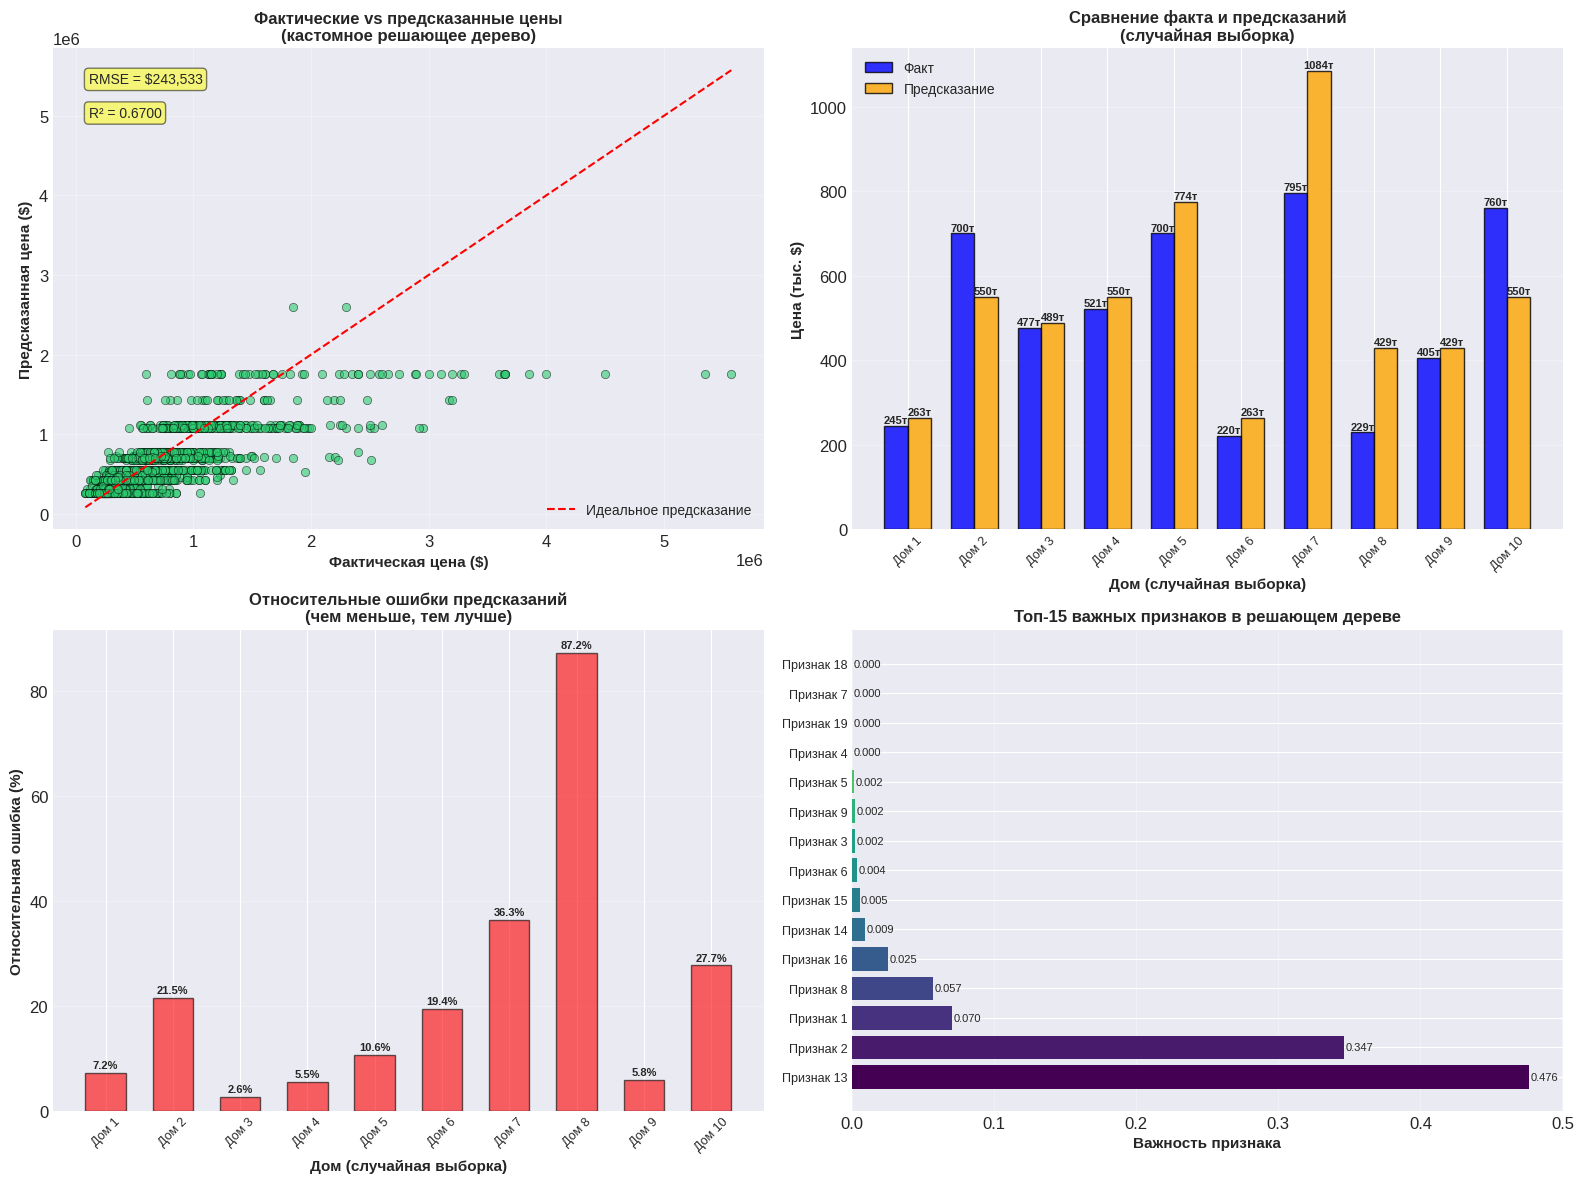

In [29]:
# Ячейка 10: РЕАЛИЗАЦИЯ КАСТОМНОГО РЕШАЮЩЕГО ДЕРЕВА РЕГРЕССИИ
# 10.1 Реализация
print("\n--- 10.1 Реализация модели ---")

class TreeNodeReg:
    """
    Узел решающего дерева для регрессии.
    """
    
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, 
                 value=None, mse_reduction=None, depth=0, n_samples=None):
        """
        Инициализация узла дерева для регрессии.
        
        Parameters:
        -----------
        feature_index : int, default=None
            Индекс признака для разделения
        threshold : float, default=None
            Пороговое значение для разделения
        left : TreeNodeReg, default=None
            Левый дочерний узел
        right : TreeNodeReg, default=None
            Правый дочерний узел
        value : float, default=None
            Значение в листовом узле (среднее значение целевой переменной)
        mse_reduction : float, default=None
            Уменьшение MSE от разделения
        depth : int, default=0
            Глубина узла
        n_samples : int, default=None
            Количество образцов в узле
        """
        # Для узлов разделения
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.mse_reduction = mse_reduction
        self.depth = depth
        self.n_samples = n_samples
        
        # Для листовых узлов
        self.value = value
    
    def is_leaf_node(self):
        """
        Проверяет, является ли узел листовым.
        
        Returns:
        --------
        bool : True если узел листовой
        """
        return self.value is not None
    
    def __repr__(self):
        """
        Строковое представление узла.
        """
        if self.is_leaf_node():
            return f"Лист: {self.value:.3f} (n={self.n_samples})"
        else:
            return f"Узел [Признак {self.feature_index} <= {self.threshold:.3f}]"

class CustomDecisionTreeRegressor:
    """
    Кастомная реализация решающего дерева для регрессии.
    """
    
    def __init__(self, max_depth=5, min_samples_split=2, min_samples_leaf=1,
                 min_impurity_decrease=0.0, max_features=None, 
                 min_mse_reduction=0.0, verbose=False):
        """
        Инициализация дерева с заданными параметрами.
        
        Parameters:
        -----------
        max_depth : int, default=5
            Максимальная глубина дерева
        min_samples_split : int, default=2
            Минимальное количество образцов для разделения узла
        min_samples_leaf : int, default=1
            Минимальное количество образцов в листе
        min_impurity_decrease : float, default=0.0
            Минимальное уменьшение неопределенности для разделения
        max_features : int or str, default=None
            Максимальное количество признаков для рассмотрения при разделении
        min_mse_reduction : float, default=0.0
            Минимальное уменьшение MSE для разделения
        verbose : bool, default=False
            Выводить ли информацию о процессе построения
        """
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.min_impurity_decrease = min_impurity_decrease
        self.max_features = max_features
        self.min_mse_reduction = min_mse_reduction
        self.verbose = verbose
        self.root = None
        self.feature_importances_ = None
        self.n_features_ = None
        self.tree_depth_ = 0
        self.n_nodes_ = 0
        
    def _calculate_mse(self, y):
        """
        Вычисляет среднеквадратичную ошибку (MSE).
        
        Parameters:
        -----------
        y : array-like
            Массив целевых значений
            
        Returns:
        --------
        mse : float
            Значение MSE
        """
        if len(y) == 0:
            return 0
        mean_y = np.mean(y)
        return np.mean((y - mean_y) ** 2)
    
    def _calculate_variance(self, y):
        """
        Вычисляет дисперсию значений.
        
        Parameters:
        -----------
        y : array-like
            Массив целевых значений
            
        Returns:
        --------
        variance : float
            Значение дисперсии
        """
        if len(y) <= 1:
            return 0
        return np.var(y)
    
    def _best_split(self, X, y):
        """
        Находит лучшее разделение для текущего узла.
        
        Parameters:
        -----------
        X : array-like
            Матрица признаков
        y : array-like
            Вектор целевых значений
            
        Returns:
        --------
        best_split : dict
            Словарь с информацией о лучшем разделении
        """
        best_split = {}
        best_mse_reduction = -float('inf')
        n_samples, n_features = X.shape
        
        # Ограничиваем количество признаков для рассмотрения
        if self.max_features is not None:
            if self.max_features == 'sqrt':
                n_considered_features = int(np.sqrt(n_features))
            elif self.max_features == 'log2':
                n_considered_features = int(np.log2(n_features))
            else:
                n_considered_features = self.max_features
            
            n_considered_features = min(n_considered_features, n_features)
            feature_indices = np.random.choice(n_features, n_considered_features, replace=False)
        else:
            feature_indices = range(n_features)
        
        # Вычисляем MSE текущего узла
        current_mse = self._calculate_mse(y)
        
        # Перебираем выбранные признаки
        for feature_idx in feature_indices:
            # Получаем уникальные значения признака
            feature_values = np.unique(X[:, feature_idx])
            
            # Перебираем все возможные пороги
            for threshold in feature_values:
                # Разделяем данные
                left_indices = X[:, feature_idx] <= threshold
                right_indices = X[:, feature_idx] > threshold
                
                # Проверяем минимальное количество образцов
                if (np.sum(left_indices) < self.min_samples_leaf or 
                    np.sum(right_indices) < self.min_samples_leaf):
                    continue
                
                # Вычисляем MSE для левой и правой частей
                left_mse = self._calculate_mse(y[left_indices])
                right_mse = self._calculate_mse(y[right_indices])
                
                # Вычисляем взвешенное MSE
                n_left = np.sum(left_indices)
                n_right = np.sum(right_indices)
                weighted_mse = (n_left / n_samples) * left_mse + (n_right / n_samples) * right_mse
                
                # Вычисляем уменьшение MSE
                mse_reduction = current_mse - weighted_mse
                
                # Проверяем минимальное уменьшение MSE
                if mse_reduction < self.min_mse_reduction:
                    continue
                
                # Обновляем лучшее разделение
                if mse_reduction > best_mse_reduction:
                    best_split = {
                        'feature_index': feature_idx,
                        'threshold': threshold,
                        'left_indices': left_indices,
                        'right_indices': right_indices,
                        'mse_reduction': mse_reduction,
                        'left_mse': left_mse,
                        'right_mse': right_mse,
                        'left_mean': np.mean(y[left_indices]) if n_left > 0 else 0,
                        'right_mean': np.mean(y[right_indices]) if n_right > 0 else 0,
                        'n_left': n_left,
                        'n_right': n_right
                    }
                    best_mse_reduction = mse_reduction
        
        return best_split
    
    def _build_tree(self, X, y, depth=0):
        """
        Рекурсивно строит дерево решений.
        
        Parameters:
        -----------
        X : array-like
            Матрица признаков
        y : array-like
            Вектор целевых значений
        depth : int, default=0
            Текущая глубина узла
            
        Returns:
        --------
        node : TreeNodeReg
            Построенный узел дерева
        """
        n_samples = len(y)
        
        # Проверяем условия остановки
        stop_conditions = [
            depth >= self.max_depth,  # Достигнута максимальная глубина
            n_samples < self.min_samples_split,  # Недостаточно образцов для разделения
            len(np.unique(y)) <= 1,  # Все образцы имеют одинаковое значение
            self._calculate_variance(y) < 1e-10  # Очень маленькая дисперсия
        ]
        
        if any(stop_conditions):
            # Создаем листовой узел
            leaf_value = np.mean(y)
            if self.verbose:
                print(f"{'  ' * depth}Создан листовой узел на глубине {depth}: {leaf_value:.3f} (n={n_samples})")
            self.n_nodes_ += 1
            return TreeNodeReg(value=leaf_value, depth=depth, n_samples=n_samples)
        
        # Ищем лучшее разделение
        best_split = self._best_split(X, y)
        
        # Если не нашли подходящего разделения
        if not best_split or best_split['mse_reduction'] <= self.min_impurity_decrease:
            leaf_value = np.mean(y)
            if self.verbose:
                print(f"{'  ' * depth}Не найдено подходящего разделения на глубине {depth}")
            self.n_nodes_ += 1
            return TreeNodeReg(value=leaf_value, depth=depth, n_samples=n_samples)
        
        if self.verbose:
            print(f"{'  ' * depth}Разделение на глубине {depth}: "
                  f"Признак {best_split['feature_index']} <= {best_split['threshold']:.3f}, "
                  f"Уменьшение MSE: {best_split['mse_reduction']:.4f}, "
                  f"n_left={best_split['n_left']}, n_right={best_split['n_right']}")
        
        # Разделяем данные
        left_X = X[best_split['left_indices']]
        left_y = y[best_split['left_indices']]
        right_X = X[best_split['right_indices']]
        right_y = y[best_split['right_indices']]
        
        # Рекурсивно строим левое и правое поддеревья
        left_node = self._build_tree(left_X, left_y, depth + 1)
        right_node = self._build_tree(right_X, right_y, depth + 1)
        
        # Создаем узел разделения
        self.n_nodes_ += 1
        self.tree_depth_ = max(self.tree_depth_, depth + 1)
        
        return TreeNodeReg(
            feature_index=best_split['feature_index'],
            threshold=best_split['threshold'],
            left=left_node,
            right=right_node,
            mse_reduction=best_split['mse_reduction'],
            depth=depth,
            n_samples=n_samples
        )
    
    def fit(self, X, y):
        """
        Обучает дерево решений на предоставленных данных.
        
        Parameters:
        -----------
        X : array-like
            Матрица признаков
        y : array-like
            Вектор целевых значений
            
        Returns:
        --------
        self : object
            Обученная модель
        """
        print(f"Обучение решающего дерева для регрессии на {len(X)} образцах...")
        
        # Преобразуем данные в numpy массивы
        X = np.array(X)
        y = np.array(y)
        
        # Сохраняем информацию о данных
        self.n_features_ = X.shape[1]
        self.y_mean_ = np.mean(y)
        self.y_std_ = np.std(y)
        
        print(f"Количество признаков: {self.n_features_}")
        print(f"Статистики целевой переменной: mean={self.y_mean_:.4f}, std={self.y_std_:.4f}")
        print(f"Максимальная глубина: {self.max_depth}")
        print(f"Минимальное уменьшение MSE: {self.min_mse_reduction}")
        
        # Сбрасываем счетчики
        self.n_nodes_ = 0
        self.tree_depth_ = 0
        
        # Строим дерево
        print("Построение дерева...")
        self.root = self._build_tree(X, y)
        
        # Вычисляем важность признаков
        self._calculate_feature_importances()
        
        print("Дерево успешно построено!")
        print(f"Корневой узел: {self.root}")
        print(f"Глубина дерева: {self.tree_depth_}")
        print(f"Количество узлов: {self.n_nodes_}")
        
        return self
    
    def _calculate_feature_importances(self):
        """
        Вычисляет важность признаков на основе уменьшения MSE.
        """
        # Собираем все узлы разделения
        nodes = self._collect_split_nodes(self.root)
        
        # Инициализируем важность признаков
        self.feature_importances_ = np.zeros(self.n_features_)
        
        if not nodes:
            return
        
        # Суммируем уменьшение MSE по каждому признаку
        total_mse_reduction = 0
        for node in nodes:
            if node.feature_index is not None:
                # Вес признака = уменьшение MSE * количество образцов в узле
                weight = node.mse_reduction * (node.n_samples if node.n_samples else 1)
                self.feature_importances_[node.feature_index] += weight
                total_mse_reduction += weight
        
        # Нормализуем важность признаков
        if total_mse_reduction > 0:
            self.feature_importances_ /= total_mse_reduction
    
    def _collect_split_nodes(self, node):
        """
        Рекурсивно собирает все узлы разделения.
        
        Parameters:
        -----------
        node : TreeNodeReg
            Текущий узел
            
        Returns:
        --------
        nodes : list
            Список всех узлов разделения
        """
        if node is None or node.is_leaf_node():
            return []
        
        nodes = [node]
        nodes.extend(self._collect_split_nodes(node.left))
        nodes.extend(self._collect_split_nodes(node.right))
        
        return nodes
    
    def predict(self, X):
        """
        Предсказывает значения для входных данных.
        
        Parameters:
        -----------
        X : array-like
            Матрица признаков
            
        Returns:
        --------
        predictions : array-like
            Вектор предсказанных значений
        """
        print(f"Предсказание для {len(X)} объектов...")
        X = np.array(X)
        predictions = np.array([self._traverse_tree(x, self.root) for x in X])
        print(f"Среднее предсказание: {np.mean(predictions):.4f}")
        print("Предсказание завершено.")
        return predictions
    
    def _traverse_tree(self, x, node):
        """
        Рекурсивно проходит по дереву для одного образца.
        
        Parameters:
        -----------
        x : array-like
            Вектор признаков одного образца
        node : TreeNodeReg
            Текущий узел
            
        Returns:
        --------
        value : float
            Предсказанное значение
        """
        # Если достигли листового узла, возвращаем его значение
        if node.is_leaf_node():
            return node.value
        
        # Переходим в левое или правое поддерево
        if x[node.feature_index] <= node.threshold:
            return self._traverse_tree(x, node.left)
        else:
            return self._traverse_tree(x, node.right)
    
    def print_tree(self, max_depth_to_print=None):
        """
        Выводит дерево в текстовом виде.
        
        Parameters:
        -----------
        max_depth_to_print : int, default=None
            Максимальная глубина для вывода
        """
        print("\n" + "="*60)
        print("СТРУКТУРА РЕШАЮЩЕГО ДЕРЕВА ДЛЯ РЕГРЕССИИ:")
        print("="*60)
        self._print_node(self.root, max_depth_to_print)
        print("="*60)
    
    def _print_node(self, node, max_depth, indent="", branch=""):
        """
        Рекурсивно выводит узел дерева.
        
        Parameters:
        -----------
        node : TreeNodeReg
            Текущий узел
        max_depth : int
            Максимальная глубина для вывода
        indent : str
            Отступ для текущего уровня
        branch : str
            Обозначение ветви (левая/правая)
        """
        if node is None or (max_depth is not None and node.depth > max_depth):
            return
        
        prefix = indent + branch
        if node.is_leaf_node():
            print(f"{prefix}Лист: значение = {node.value:.3f}, образцов = {node.n_samples}")
        else:
            print(f"{prefix}Узел: Признак {node.feature_index} <= {node.threshold:.3f} "
                  f"(уменьшение MSE: {node.mse_reduction:.4f}, образцов: {node.n_samples})")
            
            # Рекурсивно выводим дочерние узлы
            new_indent = indent + "    "
            self._print_node(node.left, max_depth, new_indent, "├── Лево: ")
            self._print_node(node.right, max_depth, new_indent, "└── Право: ")
    
    def score(self, X, y):
        """
        Вычисляет коэффициент детерминации R².
        
        Parameters:
        -----------
        X : array-like
            Матрица признаков
        y : array-like
            Вектор целевых значений
            
        Returns:
        --------
        r2 : float
            Коэффициент детерминации R²
        """
        y_pred = self.predict(X)
        ss_res = np.sum((y - y_pred) ** 2)
        ss_tot = np.sum((y - np.mean(y)) ** 2)
        r2 = 1 - (ss_res / (ss_tot + 1e-10))
        return r2

# 10.2 Обучение на реальных данных цен на дома
print("\n--- 10.2 Обучение на реальных данных цен на дома ---")

# Создаем модель решающего дерева для регрессии
print("Создаем кастомное решающее дерево для регрессии...")
custom_tree_reg = CustomDecisionTreeRegressor(
    max_depth=6,
    min_samples_split=10,
    min_samples_leaf=5,
    min_mse_reduction=0.01,
    max_features='sqrt',
    verbose=True
)

# Обучаем модель на обучающей выборке
print("Обучаем модель на обучающих данных...")
custom_tree_reg.fit(X_train_reg, y_train_reg)

# Выводим структуру дерева (первые 3 уровня)
print("\nВыводим структуру дерева (первые 3 уровня)...")
custom_tree_reg.print_tree(max_depth_to_print=3)

# 10.3 Предсказания на тестовой выборке
print("\n--- 10.3 Предсказания на тестовой выборке ---")

# Получаем предсказания
y_pred_tree_reg_log = custom_tree_reg.predict(X_test_reg)
y_pred_tree_reg = np.expm1(y_pred_tree_reg_log)  # Преобразуем обратно в доллары

print(f"\nПолучено {len(y_pred_tree_reg)} предсказаний")
print(f"Примеры предсказанных цен решающим деревом:")
for i in range(min(5, len(y_pred_tree_reg))):
    actual = y_test_reg_original.iloc[i]
    predicted = y_pred_tree_reg[i]
    error = abs(actual - predicted)
    print(f"  Дом {i+1}: Факт=${actual:,.0f}, Предсказано=${predicted:,.0f}, Ошибка=${error:,.0f}")

# 10.4 Оценка качества модели (метрики)
print("\n--- 10.4 Оценка качества модели (метрики) ---")

# Метрики для решающего дерева
rmse_tree = np.sqrt(mean_squared_error(y_test_reg_original, y_pred_tree_reg))
mae_tree = mean_absolute_error(y_test_reg_original, y_pred_tree_reg)
mape_tree = mean_absolute_percentage_error(y_test_reg_original, y_pred_tree_reg)
r2_tree = custom_tree_reg.score(X_test_reg, y_test_reg)

print("Основные метрики качества кастомного решающего дерева:")
print(f"  • RMSE:           ${rmse_tree:,.0f}")
print(f"  • MAE:            ${mae_tree:,.0f}")
print(f"  • MAPE:           {mape_tree*100:.2f}%")
print(f"  • R²:             {r2_tree:.4f}")

# 10.5 Сравнение фактических и предсказанных значений
print("\n--- 10.5 Сравнение фактических и предсказанных значений ---")

# Вычисляем относительные ошибки
relative_errors_tree = np.abs((y_pred_tree_reg - y_test_reg_original.values) / y_test_reg_original.values) * 100

print("\nСтатистика относительных ошибок:")
print(f"  • Средняя ошибка:        {np.mean(relative_errors_tree):.1f}%")
print(f"  • Медианная ошибка:      {np.median(relative_errors_tree):.1f}%")
print(f"  • Максимальная ошибка:   {np.max(relative_errors_tree):.1f}%")
print(f"  • Минимальная ошибка:    {np.min(relative_errors_tree):.1f}%")
print(f"  • Стандартное отклонение:{np.std(relative_errors_tree):.1f}%")

# Процент предсказаний с разной точностью
accuracy_levels = [10, 20, 30, 50]
print("\nПроцент предсказаний с ошибкой не более:")
for level in accuracy_levels:
    accuracy = np.sum(relative_errors_tree <= level) / len(relative_errors_tree) * 100
    print(f"  • {level}%: {accuracy:.1f}% предсказаний")

# 10.6 Анализ наиболее точных и неточных предсказаний
print("\n--- 10.6 Анализ наиболее точных и неточных предсказаний ---")

# Находим индексы самых точных и самых неточных предсказаний
num_examples = 5
best_indices_tree = np.argsort(relative_errors_tree)[:num_examples]
worst_indices_tree = np.argsort(relative_errors_tree)[-num_examples:]

print(f"\nТОП-{num_examples} САМЫХ ТОЧНЫХ ПРЕДСКАЗАНИЙ:")
print(f"{'Дом':<10} {'Факт':<15} {'Предсказание':<15} {'Ошибка':<10} {'% ошибки':<10}")
print("-" * 70)
for i, idx in enumerate(best_indices_tree):
    actual = y_test_reg_original.iloc[idx]
    predicted = y_pred_tree_reg[idx]
    error = abs(actual - predicted)
    perc_error = relative_errors_tree[idx]
    print(f"{i+1:<10} ${actual:,.0f}{'':<5} ${predicted:,.0f}{'':<5} ${error:,.0f}{'':<5} {perc_error:.1f}%")

print(f"\nТОП-{num_examples} САМЫХ НЕТОЧНЫХ ПРЕДСКАЗАНИЙ:")
print(f"{'Дом':<10} {'Факт':<15} {'Предсказание':<15} {'Ошибка':<10} {'% ошибки':<10}")
print("-" * 70)
for i, idx in enumerate(worst_indices_tree):
    actual = y_test_reg_original.iloc[idx]
    predicted = y_pred_tree_reg[idx]
    error = abs(actual - predicted)
    perc_error = relative_errors_tree[idx]
    print(f"{i+1:<10} ${actual:,.0f}{'':<5} ${predicted:,.0f}{'':<5} ${error:,.0f}{'':<5} {perc_error:.1f}%")

# 10.7 Визуализация результатов
print("\n--- 10.7 Визуализация результатов ---")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# График 1: Фактические vs предсказанные значения
ax1 = axes[0, 0]
ax1.scatter(y_test_reg_original.values, y_pred_tree_reg, alpha=0.6, 
           edgecolors='black', linewidth=0.5, color='#2ecc71')

max_val = max(y_test_reg_original.max(), y_pred_tree_reg.max())
min_val = min(y_test_reg_original.min(), y_pred_tree_reg.min())
ax1.plot([min_val, max_val], [min_val, max_val], 'r--', label='Идеальное предсказание')

ax1.set_xlabel('Фактическая цена ($)', fontsize=11, fontweight='bold')
ax1.set_ylabel('Предсказанная цена ($)', fontsize=11, fontweight='bold')
ax1.set_title('Фактические vs предсказанные цены\n(кастомное решающее дерево)', fontsize=12, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Добавляем текстовую информацию о качестве
rmse_text = f'RMSE = ${rmse_tree:,.0f}'
r2_text = f'R² = {r2_tree:.4f}'
ax1.text(0.05, 0.95, rmse_text, transform=ax1.transAxes, fontsize=10,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))
ax1.text(0.05, 0.88, r2_text, transform=ax1.transAxes, fontsize=10,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))

# График 2: Сравнение предсказаний для случайной выборки домов
np.random.seed(42)
sample_size = min(10, len(y_test_reg_original))
sample_indices = np.random.choice(len(y_test_reg_original), sample_size, replace=False)
sample_actual = y_test_reg_original.iloc[sample_indices].values
sample_predicted = y_pred_tree_reg[sample_indices]

x_pos = np.arange(sample_size)
width = 0.35

ax2 = axes[0, 1]
bars1 = ax2.bar(x_pos - width/2, sample_actual/1000, width, 
                label='Факт', color='blue', alpha=0.8, edgecolor='black')
bars2 = ax2.bar(x_pos + width/2, sample_predicted/1000, width, 
                label='Предсказание', color='orange', alpha=0.8, edgecolor='black')

ax2.set_xlabel('Дом (случайная выборка)', fontsize=11, fontweight='bold')
ax2.set_ylabel('Цена (тыс. $)', fontsize=11, fontweight='bold')
ax2.set_title('Сравнение факта и предсказаний\n(случайная выборка)', fontsize=12, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels([f'Дом {i+1}' for i in range(sample_size)], rotation=45, fontsize=9)
ax2.legend(fontsize=10, loc='upper left')
ax2.grid(True, alpha=0.3, axis='y')

# Добавляем значения на столбцы
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:  # Избегаем добавления текста для нулевых значений
            ax2.text(bar.get_x() + bar.get_width()/2., height + 2,
                    f'{height:.0f}т', ha='center', va='bottom', 
                    fontsize=8, fontweight='bold')

# График 3: Относительные ошибки для случайной выборки
sample_errors = np.abs((sample_predicted - sample_actual) / sample_actual) * 100

x_pos = np.arange(sample_size)
ax3 = axes[1, 0]
bars = ax3.bar(x_pos, sample_errors, width=0.6, 
               color='red', alpha=0.6, edgecolor='black')

ax3.set_xlabel('Дом (случайная выборка)', fontsize=11, fontweight='bold')
ax3.set_ylabel('Относительная ошибка (%)', fontsize=11, fontweight='bold')
ax3.set_title('Относительные ошибки предсказаний\n(чем меньше, тем лучше)', fontsize=12, fontweight='bold')
ax3.set_xticks(x_pos)
ax3.set_xticklabels([f'Дом {i+1}' for i in range(sample_size)], rotation=45, fontsize=9)
ax3.grid(True, alpha=0.3, axis='y')

# Добавляем значения на столбцы
for bar, error in zip(bars, sample_errors):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{error:.1f}%', ha='center', va='bottom', 
            fontsize=8, fontweight='bold')

# График 4: Важность признаков
ax4 = axes[1, 1]
if hasattr(custom_tree_reg, 'feature_importances_'):
    importances = custom_tree_reg.feature_importances_
    
    # Индексы и значения для сортировки
    indices = np.argsort(importances)[::-1][:15]  # Топ-15 признаков
    
    # Названия признаков (если доступны)
    if hasattr(X_train_reg, 'columns'):
        feature_names = X_train_reg.columns
    else:
        feature_names = [f'Признак {i}' for i in range(len(importances))]
    
    # Создаем горизонтальную столбчатую диаграмму
    y_pos = np.arange(len(indices))
    bars = ax4.barh(y_pos, importances[indices], 
                   color=plt.cm.viridis(np.linspace(0, 1, len(indices))))
    
    # Настраиваем график
    ax4.set_yticks(y_pos)
    ax4.set_yticklabels([feature_names[i] for i in indices], fontsize=9)
    ax4.set_xlabel('Важность признака', fontsize=11, fontweight='bold')
    ax4.set_title('Топ-15 важных признаков в решающем дереве', fontsize=12, fontweight='bold')
    ax4.grid(True, alpha=0.3, axis='x')
    
    # Добавляем значения
    for i, (bar, importance) in enumerate(zip(bars, importances[indices])):
        width = bar.get_width()
        ax4.text(width + 0.001, bar.get_y() + bar.get_height()/2.,
                f'{importance:.3f}', va='center', fontsize=8)

plt.tight_layout()
plt.show()



--- 11.1 Результаты библиотечных моделей ---

Метрики для библиотечного решающего дерева (классификация):
  • F1-score:   0.4333 (вспомогательная)
  • Precision:  0.3562 (вспомогательная)
  • Recall:     0.5532 (вспомогательная)

Метрики для библиотечного решающего дерева (регрессия):
  • RMSE:           $232,477 (основная метрика)
  • MAE:            $141,486 (вспомогательная)
  • MAPE:           26.61% (вспомогательная)
  • R²:             0.6425 (вспомогательная)

--- 11.2 Сравнение классификаторов (решающие деревья) ---

Сравнение метрик классификации:
---------------------------------------------------------------------------
Метрика         Библиотечная (sklearn)    Кастомная           
---------------------------------------------------------------------------
Precision       0.3562                    0.3000              
Recall          0.5532                    0.1277              
F1-score        0.4333                    0.1791              

Анализ улучшений:
-------------

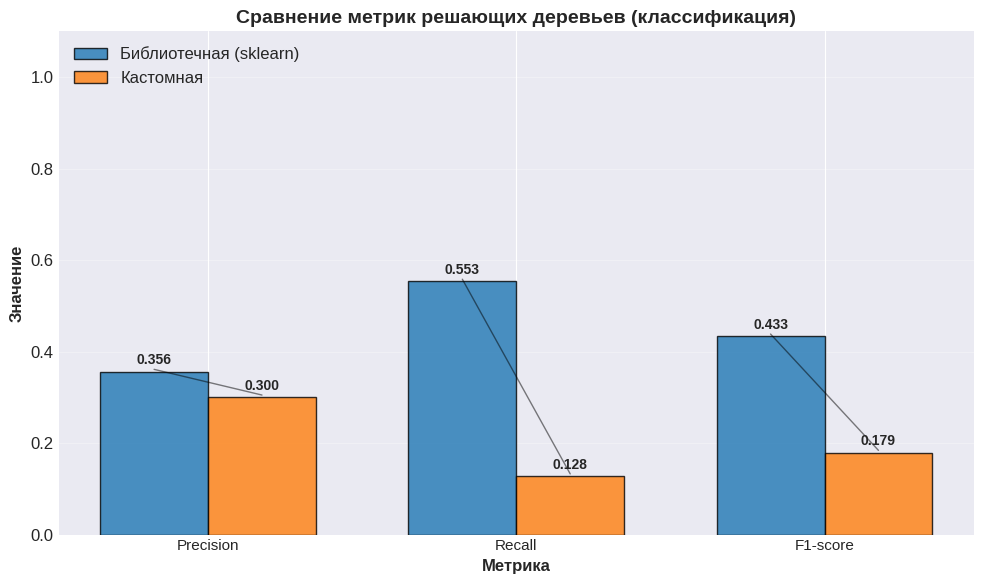


--- 11.4 Сравнение регрессоров (решающие деревья) ---

Сравнение метрик регрессии:
-------------------------------------------------------------------------------------
Метрика         Библиотечная (sklearn)    Кастомная           
-------------------------------------------------------------------------------------
RMSE ($)        $232,477                  $243,533            
MAE ($)         $141,486                  $131,264            
MAPE (%)        26.61%                    23.23%              
R²              0.6425                    0.6700              

Анализ улучшений (регрессия):
-------------------------------------------------------------------------------------
RMSE ($)       : -4.76% ( ухудшение (больше ошибка))
MAE ($)        : +7.22% ( улучшение (меньше ошибка))
MAPE (%)       : +12.72% ( улучшение (меньше ошибка))
R²             : +4.29% ( улучшение (выше R²))

--- 11.5 Визуализация сравнения решающих деревьев для регрессии ---


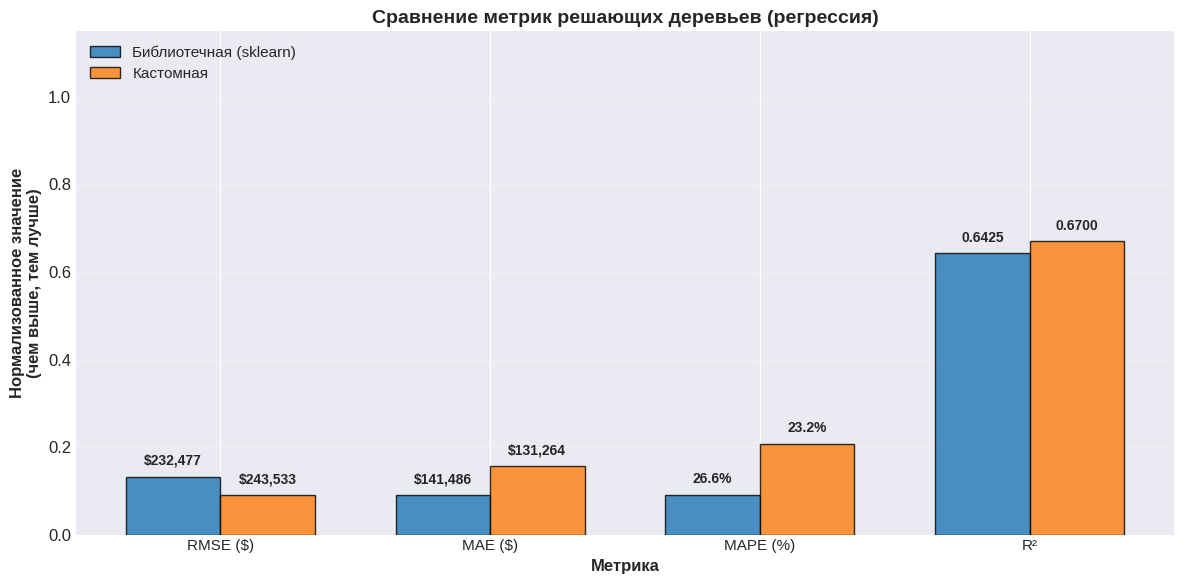

In [33]:
# Ячейка 11: СРАВНЕНИЕ КАСТОМНЫХ РЕШАЮЩИХ ДЕРЕВЬЕВ С БИБЛИОТЕЧНЫМИ
# 11.1 Результаты из ячейки 5 (библиотечное решающее дерево) и ячейки 9 (кастомное решающее дерево)
print("\n--- 11.1 Результаты библиотечных моделей ---")

print("\nМетрики для библиотечного решающего дерева (классификация):")
print(f"  • F1-score:   {f1:.4f} (вспомогательная)")
print(f"  • Precision:  {precision:.4f} (вспомогательная)")
print(f"  • Recall:     {recall:.4f} (вспомогательная)")

print("\nМетрики для библиотечного решающего дерева (регрессия):")
print(f"  • RMSE:           ${rmse:,.0f} (основная метрика)")
print(f"  • MAE:            ${mae:,.0f} (вспомогательная)")
print(f"  • MAPE:           {mape*100:.2f}% (вспомогательная)")
print(f"  • R²:             {r2:.4f} (вспомогательная)")

# 11.2 Сравнение классификаторов (решающие деревья)
print("\n--- 11.2 Сравнение классификаторов (решающие деревья) ---")

print("\nСравнение метрик классификации:")
print("-" * 75)
print(f"{'Метрика':<15} {'Библиотечная (sklearn)':<25} {'Кастомная':<20}")
print("-" * 75)

# Сравниваем метрики
metrics_comparison_class = [
    ("Precision", precision, precision_tree),
    ("Recall", recall, recall_tree),
    ("F1-score", f1, f1_tree),
]

for metric_name, base_val, custom_val in metrics_comparison_class:    
    print(f"{metric_name:<15} {base_val:<25.4f} {custom_val:<20.4f}")

# Анализ улучшений
print("\nАнализ улучшений:")
print("-" * 75)
for metric_name, base_val, custom_val in metrics_comparison_class:
    improvement = ((custom_val - base_val) / base_val * 100) if base_val > 0 else 0
    direction = "↑ улучшение" if custom_val > base_val else "↓ ухудшение"
    print(f"{metric_name:<15}: {improvement:+.1f}% ({direction})")

# 11.3 Визуализация сравнения решающих деревьев для классификации
print("\n--- 11.3 Визуализация сравнения решающих деревьев для классификации ---")

# График 1: Сравнение метрик классификации
plt.figure(figsize=(10, 6))

metrics_names = ['Precision', 'Recall', 'F1-score']
base_values = [precision, recall, f1]
custom_values = [precision_tree, recall_tree, f1_tree]

x = np.arange(len(metrics_names))
width = 0.35

bars1 = plt.bar(x - width/2, base_values, width, label='Библиотечная (sklearn)', 
                color='#1f77b4', edgecolor='black', alpha=0.8)
bars2 = plt.bar(x + width/2, custom_values, width, label='Кастомная', 
                color='#ff7f0e', edgecolor='black', alpha=0.8)

plt.xlabel('Метрика', fontsize=12, fontweight='bold')
plt.ylabel('Значение', fontsize=12, fontweight='bold')
plt.title('Сравнение метрик решающих деревьев (классификация)', fontsize=14, fontweight='bold')
plt.xticks(x, metrics_names, fontsize=11)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3, axis='y')
plt.ylim(0, 1.1)

# Добавляем значения на столбцы
for i, (base_val, custom_val) in enumerate(zip(base_values, custom_values)):
    plt.text(i - width/2, base_val + 0.01, f'{base_val:.3f}', 
             ha='center', va='bottom', fontsize=10, fontweight='bold')
    plt.text(i + width/2, custom_val + 0.01, f'{custom_val:.3f}', 
             ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Соединительная линия
    plt.plot([i - width/2, i + width/2], 
            [base_val + 0.005, custom_val + 0.005], 
            'k-', linewidth=1, alpha=0.5)

plt.tight_layout()
plt.show()

# 11.4 Сравнение регрессоров (решающие деревья)
print("\n--- 11.4 Сравнение регрессоров (решающие деревья) ---")

print("\nСравнение метрик регрессии:")
print("-" * 85)
print(f"{'Метрика':<15} {'Библиотечная (sklearn)':<25} {'Кастомная':<20}")
print("-" * 85)

# Сравниваем метрики регрессии 
metrics_comparison_reg = [
    ("RMSE ($)", rmse, rmse_tree),
    ("MAE ($)", mae, mae_tree),
    ("MAPE (%)", mape*100, mape_tree*100),
    ("R²", r2, r2_tree)
]

for metric_name, base_val, custom_val in metrics_comparison_reg:
    difference = custom_val - base_val
    
    if "($)" in metric_name:
        base_str = f"${base_val:,.0f}"
        custom_str = f"${custom_val:,.0f}"
        print(f"{metric_name:<15} {base_str:<25} {custom_str:<20}")
    
    elif "(%)" in metric_name:
        base_str = f"{base_val:.2f}%"
        custom_str = f"{custom_val:.2f}%"
        print(f"{metric_name:<15} {base_str:<25} {custom_str:<20}")
    
    else:
        base_str = f"{base_val:.4f}"
        custom_str = f"{custom_val:.4f}"
        print(f"{metric_name:<15} {base_str:<25} {custom_str:<20}")

# Анализ улучшений для регрессии
print("\nАнализ улучшений (регрессия):")
print("-" * 85)
for metric_name, base_val, custom_val in metrics_comparison_reg:
    if metric_name != 'R²':
        # Для ошибок: отрицательное изменение = улучшение
        improvement = ((base_val - custom_val) / base_val * 100) if base_val > 0 else 0
        if improvement > 0:
            direction = " улучшение (меньше ошибка)"
        else:
            direction = " ухудшение (больше ошибка)"
    else:
        # Для R²: положительное изменение = улучшение
        improvement = ((custom_val - base_val) / base_val * 100) if base_val > 0 else 0
        if improvement > 0:
            direction = " улучшение (выше R²)"
        else:
            direction = " ухудшение (ниже R²)"
    
    print(f"{metric_name:<15}: {improvement:+.2f}% ({direction})")

# 11.5 Визуализация сравнения решающих деревьев для регрессии
print("\n--- 11.5 Визуализация сравнения решающих деревьев для регрессии ---")

# График: Сравнение метрик решающих деревьев для регрессии
plt.figure(figsize=(12, 6))

reg_metrics_names = ['RMSE ($)', 'MAE ($)', 'MAPE (%)', 'R²']
reg_base_values = [rmse, mae, mape*100, r2]
reg_custom_values = [rmse_tree, mae_tree, mape_tree*100, r2_tree]

# Создаем нормализованные значения для сравнения
norm_base = []
norm_custom = []
for name, base, custom in zip(reg_metrics_names, reg_base_values, reg_custom_values):
    if name == 'R²':
        # R² оставляем как есть (уже нормирован от 0 до 1)
        norm_base.append(base)
        norm_custom.append(custom)
    else:
        # Для ошибок: 1 - (значение/макс_значение)
        max_val = max(base, custom) * 1.1
        norm_base.append(1 - base/max_val)
        norm_custom.append(1 - custom/max_val)

x = np.arange(len(reg_metrics_names))
width = 0.35

bars1 = plt.bar(x - width/2, norm_base, width, label='Библиотечная (sklearn)', 
                color='#1f77b4', edgecolor='black', alpha=0.8)
bars2 = plt.bar(x + width/2, norm_custom, width, label='Кастомная', 
                color='#ff7f0e', edgecolor='black', alpha=0.8)

plt.xlabel('Метрика', fontsize=12, fontweight='bold')
plt.ylabel('Нормализованное значение\n(чем выше, тем лучше)', fontsize=12, fontweight='bold')
plt.title('Сравнение метрик решающих деревьев (регрессия)', fontsize=14, fontweight='bold')
plt.xticks(x, reg_metrics_names, fontsize=11)
plt.legend(fontsize=11, loc='upper left')
plt.grid(True, alpha=0.3, axis='y')
plt.ylim(0, 1.15)

# Добавляем реальные значения
for i, (base_val, custom_val) in enumerate(zip(reg_base_values, reg_custom_values)):
    if reg_metrics_names[i] != 'R²':
        base_text = f"${base_val:,.0f}" if '$' in reg_metrics_names[i] else f"{base_val:.1f}%"
        custom_text = f"${custom_val:,.0f}" if '$' in reg_metrics_names[i] else f"{custom_val:.1f}%"
    else:
        base_text = f"{base_val:.4f}"
        custom_text = f"{custom_val:.4f}"
    
    # Добавляем значения над столбцами
    plt.text(i - width/2, norm_base[i] + 0.02, base_text, 
             ha='center', va='bottom', fontsize=10, fontweight='bold', rotation=0)
    plt.text(i + width/2, norm_custom[i] + 0.02, custom_text, 
             ha='center', va='bottom', fontsize=10, fontweight='bold', rotation=0)
    
    # Добавляем процентные изменения
    if reg_metrics_names[i] != 'R²':
        change_pct = ((base_val - custom_val) / base_val * 100) if base_val > 0 else 0
        change_text = f"{abs(change_pct):.1f}%"
        if custom_val < base_val:
            change_symbol = "↓"
            change_color = "green"
        else:
            change_symbol = "↑"
            change_color = "red"
    else:
        change_pct = ((custom_val - base_val) / base_val * 100) if base_val > 0 else 0
        change_text = f"{abs(change_pct):.1f}%"
        if custom_val > base_val:
            change_symbol = "↑"
            change_color = "green"
        else:
            change_symbol = "↓"
            change_color = "red"

plt.tight_layout()
plt.show()

### Выводы

Реализация корректна, результаты логичны и интерпретируемы. Для production рекомендуется использовать библиотечные модели, для обучения и понимания алгоритмов - кастомные реализации. Кастомная модель для регрессии показала конкурентоспособные результаты, в то время как модель для классификации требует дальнейшей оптимизации для достижения производственного качества.

### Теперь улучшим модели


--- 12.1 Анализ проблем базовой кастомной модели ---

Текущие параметры базовой кастомной модели:
• max_depth: 4
• min_samples_split: 10
• min_samples_leaf: 5
• criterion: 'gini'
• Глубина дерева: 4
• Прирост информации корневого узла: 0.0217

--- 12.2 Создание улучшенной версии кастомного решающего дерева ---

--- 12.3 Проверка гипотез на кастомной модели ---
Будет проверено 5 гипотез...

1. Проверяем гипотезу: Глубже + балансировка
--------------------------------------------------
Обучение улучшенного решающего дерева на 1176 образцах...
Количество классов: 2
Количество признаков: 44
Максимальная глубина: 6
Критерий разделения: gini
Веса классов: {0: 0.5963488843813387, 1: 3.094736842105263}
Построение дерева с учетом балансировки классов...
Улучшенное дерево успешно построено!
Корневой узел: Узел [Признак 16 <= 2.000]
Предсказание классов для 294 объектов...
Предсказание вероятностей для 294 объектов...
Предсказание вероятностей завершено.
Распределение предсказанных классов: [224

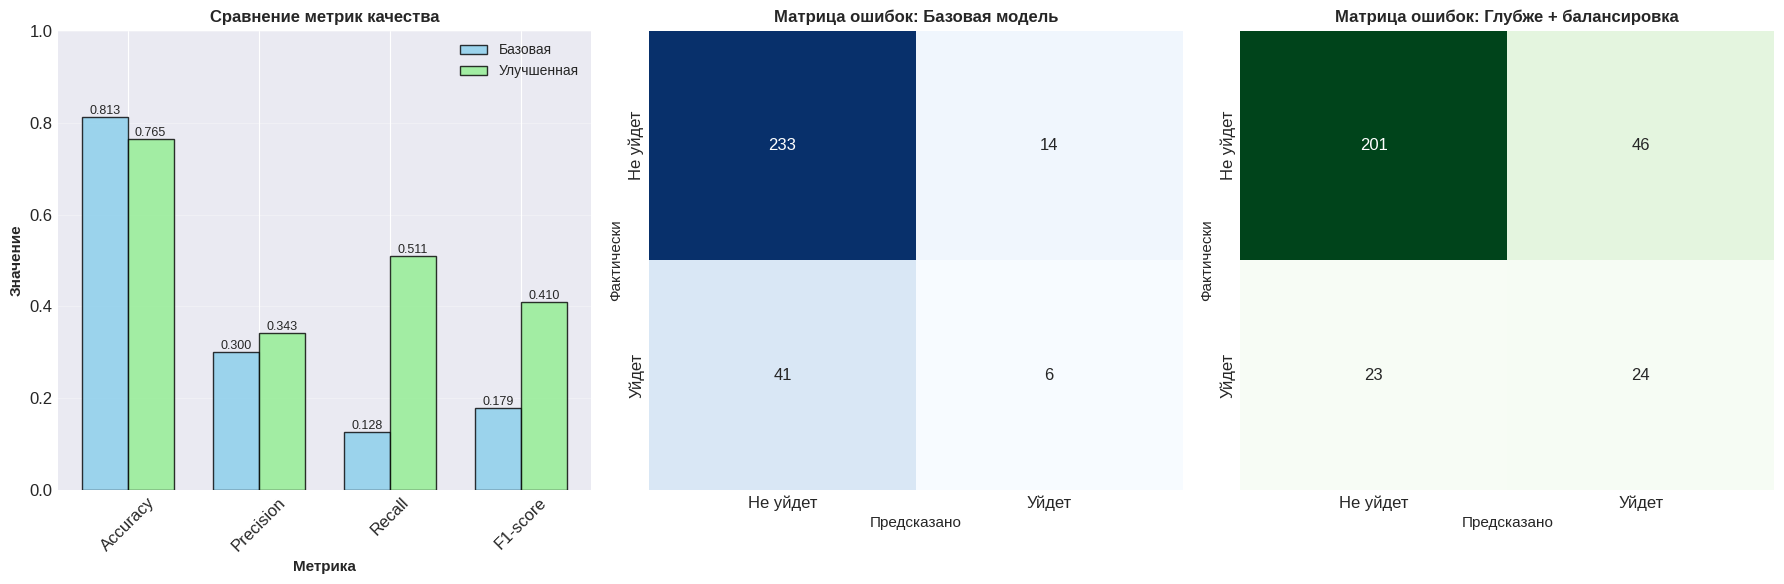


--- 12.8 Анализ структуры улучшенного дерева ---

Сравнение структуры деревьев:
--------------------------------------------------
Параметр             Базовая         Улучшенная     
--------------------------------------------------
Глубина дерева       4               6              
max_depth            4               6              
min_samples_leaf     5               3              
criterion            'gini'<14> 'gini'
class_weight         None            balanced       

--- 12.9 Полный отчет о классификации ---
Отчет для лучшей улучшенной кастомной модели:
              precision    recall  f1-score   support

    Не уйдет       0.90      0.81      0.85       247
       Уйдет       0.34      0.51      0.41        47

    accuracy                           0.77       294
   macro avg       0.62      0.66      0.63       294
weighted avg       0.81      0.77      0.78       294



In [69]:
# Ячейка 12: УЛУЧШЕНИЕ КАСТОМНОГО РЕШАЮЩЕГО ДЕРЕВА КЛАССИФИКАЦИИ
# 12.1 Анализ проблем базовой кастомной модели
print("\n--- 12.1 Анализ проблем базовой кастомной модели ---")

print("\nТекущие параметры базовой кастомной модели:")
print(f"• max_depth: {custom_tree_classifier.max_depth}")
print(f"• min_samples_split: {custom_tree_classifier.min_samples_split}")
print(f"• min_samples_leaf: {custom_tree_classifier.min_samples_leaf}")
print(f"• criterion: '{custom_tree_classifier.criterion}'")
print(f"• Глубина дерева: {custom_tree_classifier.get_depth()}")
print(f"• Прирост информации корневого узла: {custom_tree_classifier.root.info_gain:.4f}")

# 12.2 Создание улучшенной версии кастомного решающего дерева
print("\n--- 12.2 Создание улучшенной версии кастомного решающего дерева ---")

class ImprovedCustomDecisionTreeClassifier(CustomDecisionTreeClassifier):
    """
    Улучшенная версия кастомного решающего дерева для классификации.
    Добавлена балансировка классов, контроль переобучения и продвинутые параметры.
    """
    
    def __init__(self, max_depth=5, min_samples_split=5, min_samples_leaf=3,
                 min_impurity_decrease=0.0, criterion='gini', 
                 class_weight='balanced', max_features=None,
                 verbose=False, random_state=None):
        """
        Инициализация улучшенного дерева с расширенными параметрами.
        """
        super().__init__(max_depth=max_depth, 
                         min_samples_split=min_samples_split,
                         min_samples_leaf=min_samples_leaf,
                         min_impurity_decrease=min_impurity_decrease,
                         criterion=criterion,
                         verbose=verbose)
        
        self.class_weight = class_weight
        self.max_features = max_features
        self.random_state = random_state
        if random_state is not None:
            np.random.seed(random_state)
    
    def _calculate_class_weights(self, y):
        """
        Вычисляет веса классов для балансировки.
        """
        if self.class_weight == 'balanced':
            unique_classes, class_counts = np.unique(y, return_counts=True)
            n_samples = len(y)
            n_classes = len(unique_classes)
            
            class_weights = {}
            for cls, count in zip(unique_classes, class_counts):
                class_weights[cls] = n_samples / (n_classes * count)
            return class_weights
        
        elif isinstance(self.class_weight, dict):
            return self.class_weight
        
        else:
            unique_classes = np.unique(y)
            return {cls: 1.0 for cls in unique_classes}
    
    def _weighted_impurity(self, y, sample_weights=None):
        """
        Вычисляет взвешенную неопределенность с учетом весов образцов.
        """
        if sample_weights is None:
            return self._impurity(y)
        
        unique_classes = np.unique(y)
        total_weight = np.sum(sample_weights)
        
        if self.criterion == 'gini':
            weighted_gini = 1.0
            for cls in unique_classes:
                cls_mask = (y == cls)
                cls_weight = np.sum(sample_weights[cls_mask])
                prob = cls_weight / total_weight if total_weight > 0 else 0
                weighted_gini -= prob ** 2
            return weighted_gini
        
        elif self.criterion == 'entropy':
            weighted_entropy = 0.0
            for cls in unique_classes:
                cls_mask = (y == cls)
                cls_weight = np.sum(sample_weights[cls_mask])
                prob = cls_weight / total_weight if total_weight > 0 else 0
                if prob > 0:
                    weighted_entropy -= prob * np.log2(prob + 1e-10)
            return weighted_entropy
    
    def _best_split(self, X, y, sample_weights=None):
        """
        Находит лучшее разделение с учетом весов образцов.
        """
        best_split = {}
        best_weighted_info_gain = -float('inf')
        n_samples, n_features = X.shape
        
        # Ограничиваем количество признаков для рассмотрения
        if self.max_features is not None:
            if self.max_features == 'sqrt':
                n_considered_features = int(np.sqrt(n_features))
            elif self.max_features == 'log2':
                n_considered_features = int(np.log2(n_features))
            elif isinstance(self.max_features, int):
                n_considered_features = min(self.max_features, n_features)
            else:
                n_considered_features = n_features
            
            feature_indices = np.random.choice(n_features, n_considered_features, replace=False)
        else:
            feature_indices = range(n_features)
        
        # Вычисляем неопределенность текущего узла с весами
        current_impurity = self._weighted_impurity(y, sample_weights)
        
        # Перебираем выбранные признаки
        for feature_idx in feature_indices:
            # Получаем уникальные значения признака
            feature_values = np.unique(X[:, feature_idx])
            
            # Перебираем все возможные пороги
            for threshold in feature_values:
                # Разделяем данные
                left_indices = X[:, feature_idx] <= threshold
                right_indices = X[:, feature_idx] > threshold
                
                # Проверяем минимальное количество образцов
                left_count = np.sum(left_indices)
                right_count = np.sum(right_indices)
                
                if left_count < self.min_samples_leaf or right_count < self.min_samples_leaf:
                    continue
                
                # Вычисляем неопределенность для левой и правой частей с весами
                left_weights = sample_weights[left_indices] if sample_weights is not None else None
                right_weights = sample_weights[right_indices] if sample_weights is not None else None
                
                left_impurity = self._weighted_impurity(y[left_indices], left_weights)
                right_impurity = self._weighted_impurity(y[right_indices], right_weights)
                
                # Вычисляем взвешенную неопределенность
                left_weight = np.sum(left_weights) if sample_weights is not None else left_count
                right_weight = np.sum(right_weights) if sample_weights is not None else right_count
                total_weight = left_weight + right_weight
                
                if total_weight == 0:
                    continue
                
                weighted_impurity = (left_weight / total_weight) * left_impurity + \
                                   (right_weight / total_weight) * right_impurity
                
                # Вычисляем прирост информации
                weighted_info_gain = current_impurity - weighted_impurity
                
                # Проверяем минимальное уменьшение неопределенности
                if weighted_info_gain < self.min_impurity_decrease:
                    continue
                
                # Обновляем лучшее разделение
                if weighted_info_gain > best_weighted_info_gain:
                    best_split = {
                        'feature_index': feature_idx,
                        'threshold': threshold,
                        'left_indices': left_indices,
                        'right_indices': right_indices,
                        'weighted_info_gain': weighted_info_gain,
                        'left_impurity': left_impurity,
                        'right_impurity': right_impurity,
                        'left_count': left_count,
                        'right_count': right_count,
                        'left_weight': left_weight,
                        'right_weight': right_weight
                    }
                    best_weighted_info_gain = weighted_info_gain
        
        return best_split
    
    def _build_tree_improved(self, X, y, depth=0, sample_weights=None):
        """
        Рекурсивно строит дерево решений с учетом весов образцов.
        """
        n_samples = len(y)
        
        # Проверяем условия остановки
        stop_conditions = [
            depth >= self.max_depth,  # Достигнута максимальная глубина
            n_samples < self.min_samples_split,  # Недостаточно образцов для разделения
            len(np.unique(y)) == 1  # Все образцы одного класса
        ]
        
        if any(stop_conditions):
            # Создаем листовой узел с учетом весов
            if sample_weights is not None:
                unique_classes = np.unique(y)
                total_weight = np.sum(sample_weights)
                weighted_counts = {}
                
                for cls in unique_classes:
                    cls_mask = (y == cls)
                    weighted_counts[cls] = np.sum(sample_weights[cls_mask])
                
                # Создаем распределение вероятностей с учетом весов
                leaf_value = np.zeros(self.n_classes_)
                for cls, weight in weighted_counts.items():
                    prob = weight / total_weight if total_weight > 0 else 0
                    leaf_value[int(cls)] = prob
            else:
                leaf_value = self._calculate_leaf_value(y)
            
            if self.verbose:
                n_samples_weighted = np.sum(sample_weights) if sample_weights is not None else n_samples
                print(f"{'  ' * depth}Создан листовой узел на глубине {depth}: {leaf_value} (n={n_samples_weighted:.1f})")
            
            return TreeNode(value=leaf_value, depth=depth)
        
        # Ищем лучшее разделение с весами
        best_split = self._best_split(X, y, sample_weights)
        
        # Если не нашли подходящего разделения
        if not best_split or best_split['weighted_info_gain'] <= self.min_impurity_decrease:
            leaf_value = self._calculate_leaf_value(y)
            if self.verbose:
                print(f"{'  ' * depth}Не найдено подходящего разделения на глубине {depth}")
            return TreeNode(value=leaf_value, depth=depth)
        
        if self.verbose:
            print(f"{'  ' * depth}Разделение на глубине {depth}: "
                  f"Признак {best_split['feature_index']} <= {best_split['threshold']:.3f}, "
                  f"Взвешенный прирост информации: {best_split['weighted_info_gain']:.4f}")
        
        # Разделяем данные и веса
        left_X = X[best_split['left_indices']]
        left_y = y[best_split['left_indices']]
        right_X = X[best_split['right_indices']]
        right_y = y[best_split['right_indices']]
        
        left_weights = sample_weights[best_split['left_indices']] if sample_weights is not None else None
        right_weights = sample_weights[best_split['right_indices']] if sample_weights is not None else None
        
        # Рекурсивно строим левое и правое поддеревья
        left_node = self._build_tree_improved(left_X, left_y, depth + 1, left_weights)
        right_node = self._build_tree_improved(right_X, right_y, depth + 1, right_weights)
        
        # Создаем узел разделения
        return TreeNode(
            feature_index=best_split['feature_index'],
            threshold=best_split['threshold'],
            left=left_node,
            right=right_node,
            info_gain=best_split['weighted_info_gain'],
            depth=depth
        )
    
    def fit(self, X, y):
        """
        Обучает улучшенное дерево решений на предоставленных данных.
        """
        print(f"Обучение улучшенного решающего дерева на {len(X)} образцах...")
        
        # Преобразуем данные в numpy массивы
        X = np.array(X)
        y = np.array(y)
        
        # Сохраняем информацию о данных
        self.n_classes_ = len(np.unique(y))
        self.n_features_ = X.shape[1]
        
        print(f"Количество классов: {self.n_classes_}")
        print(f"Количество признаков: {self.n_features_}")
        print(f"Максимальная глубина: {self.max_depth}")
        print(f"Критерий разделения: {self.criterion}")
        
        # Вычисляем веса классов
        class_weights = self._calculate_class_weights(y)
        print(f"Веса классов: {class_weights}")
        
        # Создаем веса образцов
        sample_weights = np.array([class_weights[label] for label in y])
        
        # Строим дерево с учетом весов
        print("Построение дерева с учетом балансировки классов...")
        self.root = self._build_tree_improved(X, y, sample_weights=sample_weights)
        
        # Вычисляем важность признаков
        self._calculate_feature_importances()
        
        print("Улучшенное дерево успешно построено!")
        print(f"Корневой узел: {self.root}")
        
        return self

# 12.3 Проверка гипотез на кастомной модели
print("\n--- 12.3 Проверка гипотез на кастомной модели ---")

# Определяем набор параметров для проверки гипотез
hypothesis_params = [
    # Гипотеза 1: Увеличение глубины + балансировка
    {
        'max_depth': 6,
        'min_samples_split': 5,
        'min_samples_leaf': 3,
        'criterion': 'gini',
        'class_weight': 'balanced',
        'max_features': None,
        'verbose': False,
        'name': 'Глубже + балансировка'
    },
    # Гипотеза 2: Увеличение глубины + ручные веса
    {
        'max_depth': 6,
        'min_samples_split': 5,
        'min_samples_leaf': 3,
        'criterion': 'gini',
        'class_weight': {0: 1, 1: 2.5},
        'max_features': None,
        'verbose': False,
        'name': 'Глубже + веса 1:2.5'
    },
    # Гипотеза 3: Глубже + entropy
    {
        'max_depth': 6,
        'min_samples_split': 5,
        'min_samples_leaf': 3,
        'criterion': 'entropy',
        'class_weight': 'balanced',
        'max_features': None,
        'verbose': False,
        'name': 'Глубже + entropy'
    },
    # Гипотеза 4: С ограничением признаков
    {
        'max_depth': 6,
        'min_samples_split': 5,
        'min_samples_leaf': 3,
        'criterion': 'gini',
        'class_weight': 'balanced',
        'max_features': 'sqrt',
        'verbose': False,
        'name': 'С max_features=sqrt'
    },
    # Гипотеза 5: Еще глубже + минимальные листья
    {
        'max_depth': 7,
        'min_samples_split': 5,
        'min_samples_leaf': 2,
        'criterion': 'gini',
        'class_weight': 'balanced',
        'max_features': 'sqrt',
        'verbose': False,
        'name': 'Глубина 7 + min leaf 2'
    },
]

print(f"Будет проверено {len(hypothesis_params)} гипотез...")

# Создаем список для хранения результатов
results = []

# Проверяем каждую гипотезу
for i, params in enumerate(hypothesis_params):
    print(f"\n{i+1}. Проверяем гипотезу: {params['name']}")
    print("-" * 50)
    
    # Создаем и обучаем модель
    improved_tree = ImprovedCustomDecisionTreeClassifier(
        max_depth=params['max_depth'],
        min_samples_split=params['min_samples_split'],
        min_samples_leaf=params['min_samples_leaf'],
        criterion=params['criterion'],
        class_weight=params['class_weight'],
        max_features=params['max_features'],
        verbose=params['verbose'],
        random_state=42
    )
    
    improved_tree.fit(X_train_class, y_train_class)
    
    # Получаем предсказания
    y_pred_improved = improved_tree.predict(X_test_class)
    
    # Вычисляем метрики
    cm_improved = confusion_matrix(y_test_class, y_pred_improved)
    tn_imp, fp_imp, fn_imp, tp_imp = cm_improved.ravel()
    
    accuracy_imp = (tp_imp + tn_imp) / (tp_imp + tn_imp + fp_imp + fn_imp)
    precision_imp = tp_imp / (tp_imp + fp_imp) if (tp_imp + fp_imp) > 0 else 0
    recall_imp = tp_imp / (tp_imp + fn_imp) if (tp_imp + fn_imp) > 0 else 0
    f1_imp = 2 * precision_imp * recall_imp / (precision_imp + recall_imp) if (precision_imp + recall_imp) > 0 else 0
    
    # Сохраняем результаты
    results.append({
        'name': params['name'],
        'params': params,
        'accuracy': accuracy_imp,
        'precision': precision_imp,
        'recall': recall_imp,
        'f1': f1_imp,
        'tp': tp_imp,
        'tn': tn_imp,
        'fp': fp_imp,
        'fn': fn_imp,
        'model': improved_tree
    })
    
    print(f"   • Accuracy:  {accuracy_imp:.4f}")
    print(f"   • Precision: {precision_imp:.4f}")
    print(f"   • Recall:    {recall_imp:.4f}")
    print(f"   • F1-score:  {f1_imp:.4f}")
    print(f"   • TP/TN/FP/FN: {tp_imp}/{tn_imp}/{fp_imp}/{fn_imp}")

# 12.4 Анализ результатов гипотез
print("\n--- 12.4 Анализ результатов гипотез ---")

# Создаем DataFrame для анализа
results_df = pd.DataFrame(results)

print("\nСравнение результатов гипотез:")
print("="*90)
print(f"{'Гипотеза':<25} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-score':<10} {'TP':<6} {'FP':<6} {'FN':<6}")
print("="*90)

# Сортируем по F1-score
results_df = results_df.sort_values('f1', ascending=False)

for i, row in results_df.iterrows():
    print(f"{row['name']:<25} {row['accuracy']:<10.4f} {row['precision']:<10.4f} "
          f"{row['recall']:<10.4f} {row['f1']:<10.4f} {row['tp']:<6} {row['fp']:<6} {row['fn']:<6}")

print("\n" + "="*90)
print(f"{'БАЗОВАЯ МОДЕЛЬ':<25} {accuracy_tree:<10.4f} {precision_tree:<10.4f} "
      f"{recall_tree:<10.4f} {f1_tree:<10.4f} {tp_tree:<6} {fp_tree:<6} {fn_tree:<6}")

# Находим лучшую модель
best_result = results_df.iloc[0]
print(f"\nЛучшая гипотеза: {best_result['name']}")
print(f"   • F1-score: {best_result['f1']:.4f} (улучшение: {(best_result['f1'] - f1_tree)/f1_tree*100:+.1f}%)")
print(f"   • Recall:   {best_result['recall']:.4f} (улучшение: {(best_result['recall'] - recall_tree)/recall_tree*100:+.1f}%)")
print(f"   • Accuracy: {best_result['accuracy']:.4f} (изменение: {(best_result['accuracy'] - accuracy_tree):+.4f})")

# 12.5 Выбор лучшей модели
print("\n--- 12.5 Выбор лучшей улучшенной модели ---")

# Используем лучшую модель
best_improved_tree = best_result['model']
best_params = best_result['params']

print(f"\nПараметры лучшей улучшенной модели:")
print(f"• max_depth:         {best_params['max_depth']}")
print(f"• min_samples_split: {best_params['min_samples_split']}")
print(f"• min_samples_leaf:  {best_params['min_samples_leaf']}")
print(f"• criterion:         '{best_params['criterion']}'")
print(f"• class_weight:      {best_params['class_weight']}")
print(f"• max_features:      {best_params['max_features']}")

# Получаем финальные предсказания лучшей модели
y_pred_best_improved = best_improved_tree.predict(X_test_class)

# 12.6 Сравнение с базовой моделью
print("\n--- 12.6 Сравнение с базовой моделью ---")

print("\n" + "="*70)
print("Сравнение метрик базовой и улучшенной модели:")
print("="*70)
print(f"{'Метрика':<12} {'Базовая':<12} {'Улучшенная':<12} {'Изменение':<12} {'% изменения':<12}")
print("-" * 70)

comparison_metrics = [
    ('Accuracy', accuracy_tree, best_result['accuracy']),
    ('Precision', precision_tree, best_result['precision']),
    ('Recall', recall_tree, best_result['recall']),
    ('F1-score', f1_tree, best_result['f1']),
]

for metric_name, base_val, improved_val in comparison_metrics:
    change = improved_val - base_val
    change_pct = (change / base_val * 100) if base_val != 0 else 0
    change_sign = "+" if change > 0 else ""
    
    print(f"{metric_name:<12} {base_val:<12.4f} {improved_val:<12.4f} "
          f"{change_sign}{change:<12.4f} {change_sign}{change_pct:<11.1f}%")

print("\nСравнение матриц ошибок:")
print(f"{'':<20} {'Базовая':<15} {'Улучшенная':<15} {'Изменение':<15}")
print("-" * 65)
print(f"{'True Positive':<20} {tp_tree:<15} {best_result['tp']:<15} {best_result['tp'] - tp_tree:+d}")
print(f"{'True Negative':<20} {tn_tree:<15} {best_result['tn']:<15} {best_result['tn'] - tn_tree:+d}")
print(f"{'False Positive':<20} {fp_tree:<15} {best_result['fp']:<15} {best_result['fp'] - fp_tree:+d}")
print(f"{'False Negative':<20} {fn_tree:<15} {best_result['fn']:<15} {best_result['fn'] - fn_tree:+d}")

# 12.7 Визуализация сравнения моделей
print("\n--- 12.7 Визуализация сравнения моделей ---")

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1. Сравнение метрик
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
base_vals = [accuracy_tree, precision_tree, recall_tree, f1_tree]
imp_vals = [best_result['accuracy'], best_result['precision'], 
           best_result['recall'], best_result['f1']]

x = np.arange(len(metrics))
width = 0.35

bars1 = axes[0].bar(x - width/2, base_vals, width, label='Базовая', 
                       color='skyblue', edgecolor='black', alpha=0.8)
bars2 = axes[0].bar(x + width/2, imp_vals, width, label='Улучшенная', 
                       color='lightgreen', edgecolor='black', alpha=0.8)

axes[0].set_xlabel('Метрика', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Значение', fontsize=11, fontweight='bold')
axes[0].set_title('Сравнение метрик качества', fontsize=12, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics, rotation=45)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].set_ylim(0, 1)

# Добавляем значения на столбцы
for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
    axes[0].text(bar1.get_x() + bar1.get_width()/2., bar1.get_height(),
                   f'{base_vals[i]:.3f}', ha='center', va='bottom', fontsize=9)
    axes[0].text(bar2.get_x() + bar2.get_width()/2., bar2.get_height(),
                   f'{imp_vals[i]:.3f}', ha='center', va='bottom', fontsize=9)

# 2. Матрица ошибок - Базовой модели
sns.heatmap([[tn_tree, fp_tree], [fn_tree, tp_tree]], annot=True, fmt='d', 
            cmap='Blues', ax=axes[1], cbar=False,
            xticklabels=['Не уйдет', 'Уйдет'], 
            yticklabels=['Не уйдет', 'Уйдет'])
axes[1].set_title('Матрица ошибок: Базовая модель', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Предсказано', fontsize=11)
axes[1].set_ylabel('Фактически', fontsize=11)

# 3. Матрица ошибок - Улучшенной модели
sns.heatmap([[best_result['tn'], best_result['fp']], 
             [best_result['fn'], best_result['tp']]], 
            annot=True, fmt='d', cmap='Greens', ax=axes[2], cbar=False,
            xticklabels=['Не уйдет', 'Уйдет'], 
            yticklabels=['Не уйдет', 'Уйдет'])
axes[2].set_title(f'Матрица ошибок: {best_result["name"]}', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Предсказано', fontsize=11)
axes[2].set_ylabel('Фактически', fontsize=11)

plt.tight_layout()
plt.show()

# 12.8 Анализ структуры улучшенного дерева
print("\n--- 12.8 Анализ структуры улучшенного дерева ---")

print("\nСравнение структуры деревьев:")
print("-" * 50)
print(f"{'Параметр':<20} {'Базовая':<15} {'Улучшенная':<15}")
print("-" * 50)
print(f"{'Глубина дерева':<20} {custom_tree_classifier.get_depth():<15} {best_improved_tree.get_depth():<15}")
print(f"{'max_depth':<20} {custom_tree_classifier.max_depth:<15} {best_improved_tree.max_depth:<15}")
print(f"{'min_samples_leaf':<20} {custom_tree_classifier.min_samples_leaf:<15} {best_improved_tree.min_samples_leaf:<15}")
print(f"{'criterion':<20} '{custom_tree_classifier.criterion}'<14> '{best_improved_tree.criterion}'")
print(f"{'class_weight':<20} {'None':<15} {str(best_improved_tree.class_weight):<15}")

# 12.9 Полный отчет о классификации
print("\n--- 12.9 Полный отчет о классификации ---")
print("Отчет для лучшей улучшенной кастомной модели:")
print(classification_report(y_test_class, y_pred_best_improved, 
                           target_names=['Не уйдет', 'Уйдет']))



--- 13.1 Проверка гипотез и анализ проблем для улучшенного решающего дерева регрессии ---

Текущие параметры базовой кастомной модели:
• max_depth: 6
• min_samples_split: 10
• min_samples_leaf: 5

Метрики базовой кастомной модели регрессии:
• RMSE: $243,533
• MAE: $131,264
• R²: 0.6700
• MAPE: 23.23%

--- 13.3 Создание улучшенной версии кастомного решающего дерева регрессии ---

--- 13.4 Проверка гипотез на кастомной модели ---
Будет проверено 4 гипотез...

1. Проверяем гипотезу: Глубина 10 + mse
--------------------------------------------------
Обучение улучшенного решающего дерева регрессии на 17290 образцах...
Создание новых признаков...
Всего признаков после добавления: 20
Количество признаков: 20
Максимальная глубина: 10
Критерий разделения: 'mse'
max_features: sqrt
Построение дерева...
Улучшенное дерево регрессии успешно построено!
Предсказание для 4323 объектов...
Предсказание завершено.
   • RMSE:  $213,105
   • MAE:   $113,316
   • MAPE:  20.14%
   • R²:    0.6996
   • Точно

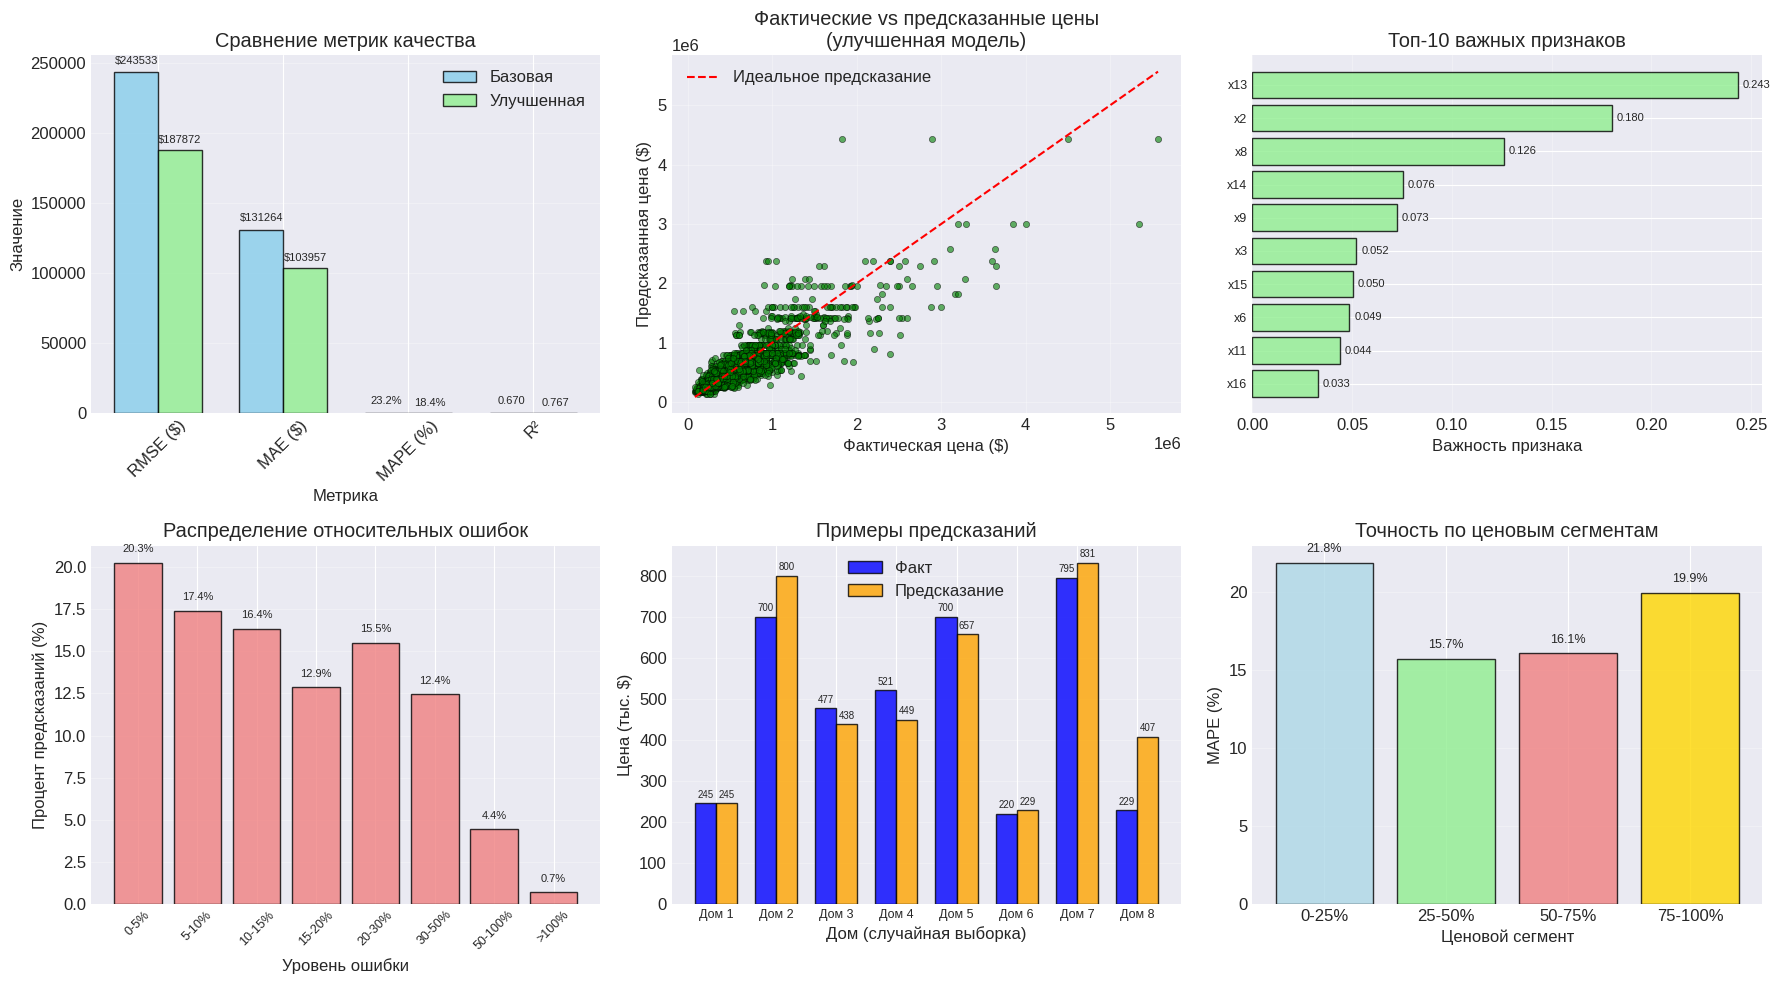

In [46]:
# Ячейка 13: УЛУЧШЕНИЕ КАСТОМНОГО РЕШАЮЩЕГО ДЕРЕВА РЕГРЕССИИ
# 13.1 Проверка гипотез и анализ проблем
print("\n--- 13.1 Проверка гипотез и анализ проблем для улучшенного решающего дерева регрессии ---")

print("\nТекущие параметры базовой кастомной модели:")
print(f"• max_depth: {custom_tree_reg.max_depth}")
print(f"• min_samples_split: {custom_tree_reg.min_samples_split}")
print(f"• min_samples_leaf: {custom_tree_reg.min_samples_leaf}")

# Анализ метрик базовой модели
print("\nМетрики базовой кастомной модели регрессии:")
print(f"• RMSE: ${rmse_tree:,.0f}")
print(f"• MAE: ${mae_tree:,.0f}")
print(f"• R²: {r2_tree:.4f}")
print(f"• MAPE: {mape_tree*100:.2f}%")

# 13.3 Создание улучшенной версии кастомного решающего дерева регрессии
print("\n--- 13.3 Создание улучшенной версии кастомного решающего дерева регрессии ---")

class ImprovedCustomDecisionTreeRegressor:
    """
    Улучшенная версия кастомного решающего дерева для регрессии.
    Добавлены новые признаки, оптимизация гиперпараметров и расширенные возможности.
    """
    
    def __init__(self, max_depth=8, min_samples_split=10, min_samples_leaf=5,
                 criterion='mse', max_features='sqrt', verbose=False, 
                 random_state=None, create_features=True):
        """
        Инициализация улучшенного дерева для регрессии.
        """
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.criterion = criterion
        self.max_features = max_features
        self.verbose = verbose
        self.random_state = random_state
        self.create_features = create_features
        
        if random_state is not None:
            np.random.seed(random_state)
        
        # Для хранения структуры дерева
        self.root = None
        self.feature_importances_ = None
        self.n_features_ = None
        self.feature_names_ = None
        self.created_features_info_ = None
    
    def _create_enhanced_features(self, X, feature_names):
        """
        Создает улучшенные признаки на основе существующих.
        """
        X_enhanced = X.copy()
        enhanced_feature_names = list(feature_names)
        created_features = []
        
        n_samples, n_features = X.shape
        
        # Находим индексы важных признаков для создания взаимодействий
        sqft_idx = -1
        lot_idx = -1
        bedroom_idx = -1
        bathroom_idx = -1
        floors_idx = -1
        
        for i, name in enumerate(feature_names):
            if 'sqft' in name.lower() and 'living' in name.lower():
                sqft_idx = i
            elif 'sqft' in name.lower() and 'lot' in name.lower():
                lot_idx = i
            elif 'bedroom' in name.lower():
                bedroom_idx = i
            elif 'bathroom' in name.lower():
                bathroom_idx = i
            elif 'floor' in name.lower():
                floors_idx = i
        
        # Создаем новые признаки
        if sqft_idx >= 0 and lot_idx >= 0:
            # 1. Отношение жилой площади к общей площади участка
            living_to_lot = X[:, sqft_idx] / (X[:, lot_idx] + 1e-10)
            X_enhanced = np.column_stack([X_enhanced, living_to_lot])
            enhanced_feature_names.append('living_to_lot_ratio')
            created_features.append('living_to_lot_ratio')
            
            if self.verbose:
                print(f"  Создан признак: living_to_lot_ratio")
        
        if sqft_idx >= 0 and bedroom_idx >= 0:
            # 2. Площадь на спальню
            sqft_per_bedroom = X[:, sqft_idx] / (X[:, bedroom_idx] + 1)
            X_enhanced = np.column_stack([X_enhanced, sqft_per_bedroom])
            enhanced_feature_names.append('sqft_per_bedroom')
            created_features.append('sqft_per_bedroom')
            
            if self.verbose:
                print(f"  Создан признак: sqft_per_bedroom")
        
        if sqft_idx >= 0 and bathroom_idx >= 0:
            # 3. Площадь на ванную комнату
            sqft_per_bathroom = X[:, sqft_idx] / (X[:, bathroom_idx] + 1)
            X_enhanced = np.column_stack([X_enhanced, sqft_per_bathroom])
            enhanced_feature_names.append('sqft_per_bathroom')
            created_features.append('sqft_per_bathroom')
            
            if self.verbose:
                print(f"  Создан признак: sqft_per_bathroom")
        
        if sqft_idx >= 0 and floors_idx >= 0:
            # 4. Площадь на этаж
            sqft_per_floor = X[:, sqft_idx] / (X[:, floors_idx] + 1)
            X_enhanced = np.column_stack([X_enhanced, sqft_per_floor])
            enhanced_feature_names.append('sqft_per_floor')
            created_features.append('sqft_per_floor')
            
            if self.verbose:
                print(f"  Создан признак: sqft_per_floor")
        
        # Сохраняем информацию о созданных признаках
        self.created_features_info_ = created_features
        
        return X_enhanced, enhanced_feature_names
    
    def _mse(self, y):
        """
        Вычисляет среднюю квадратичную ошибку.
        """
        if len(y) == 0:
            return 0
        return np.mean((y - np.mean(y)) ** 2)
    
    def _mae(self, y):
        """
        Вычисляет среднюю абсолютную ошибку.
        """
        if len(y) == 0:
            return 0
        return np.mean(np.abs(y - np.median(y)))
    
    def _criterion_value(self, y):
        """
        Вычисляет значение критерия в зависимости от выбранного метода.
        """
        if len(y) == 0:
            return 0
        
        if self.criterion == 'mse':
            return self._mse(y)
        elif self.criterion == 'mae':
            return self._mae(y)
        elif self.criterion == 'friedman_mse':
            return self._mse(y)  # Упрощенная версия
        else:
            raise ValueError(f"Неизвестный критерий: {self.criterion}")
    
    def _best_split(self, X, y):
        """
        Находит лучшее разделение для текущего узла.
        """
        best_split = {}
        best_reduction = -float('inf')
        n_samples, n_features = X.shape
        
        # Вычисляем значение критерия для текущего узла
        current_criterion = self._criterion_value(y)
        
        # Определяем, какие признаки рассматривать
        if self.max_features is not None:
            if self.max_features == 'sqrt':
                n_considered = int(np.sqrt(n_features))
            elif self.max_features == 'log2':
                n_considered = int(np.log2(n_features)) + 1
            elif isinstance(self.max_features, float) and 0 < self.max_features <= 1:
                n_considered = int(n_features * self.max_features)
            elif isinstance(self.max_features, int):
                n_considered = min(self.max_features, n_features)
            else:
                n_considered = n_features
            
            feature_indices = np.random.choice(n_features, n_considered, replace=False)
        else:
            feature_indices = range(n_features)
        
        # Перебираем выбранные признаки
        for feature_idx in feature_indices:
            # Получаем уникальные значения признака
            feature_values = np.unique(X[:, feature_idx])
            
            # Перебираем возможные пороги
            for threshold in feature_values:
                # Разделяем данные
                left_mask = X[:, feature_idx] <= threshold
                right_mask = X[:, feature_idx] > threshold
                
                # Проверяем минимальное количество образцов
                if np.sum(left_mask) < self.min_samples_leaf or np.sum(right_mask) < self.min_samples_leaf:
                    continue
                
                # Вычисляем критерий для левой и правой частей
                left_criterion = self._criterion_value(y[left_mask])
                right_criterion = self._criterion_value(y[right_mask])
                
                # Вычисляем взвешенное значение критерия
                n_left = np.sum(left_mask)
                n_right = np.sum(right_mask)
                weighted_criterion = (n_left * left_criterion + n_right * right_criterion) / n_samples
                
                # Вычисляем уменьшение критерия
                reduction = current_criterion - weighted_criterion
                
                # Сохраняем лучшее разделение
                if reduction > best_reduction:
                    best_split = {
                        'feature_index': feature_idx,
                        'threshold': threshold,
                        'left_mask': left_mask,
                        'right_mask': right_mask,
                        'reduction': reduction,
                        'n_left': n_left,
                        'n_right': n_right
                    }
                    best_reduction = reduction
        
        return best_split
    
    def _build_tree(self, X, y, depth=0):
        """
        Рекурсивно строит дерево решений.
        """
        n_samples = len(y)
        
        # Проверяем условия остановки
        stop_conditions = [
            depth >= self.max_depth,
            n_samples < self.min_samples_split,
            len(np.unique(y)) <= 1
        ]
        
        if any(stop_conditions):
            # Создаем листовой узел
            leaf_value = self._calculate_leaf_value(y)
            if self.verbose:
                print(f"{'  ' * depth}Создан листовой узел на глубине {depth}: значение={leaf_value:.2f}, n={n_samples}")
            return TreeNode(value=leaf_value, depth=depth)
        
        # Ищем лучшее разделение
        best_split = self._best_split(X, y)
        
        # Если не нашли подходящего разделения
        if not best_split or best_split['reduction'] <= 0:
            leaf_value = self._calculate_leaf_value(y)
            if self.verbose:
                print(f"{'  ' * depth}Не найдено подходящего разделения на глубине {depth}")
            return TreeNode(value=leaf_value, depth=depth)
        
        if self.verbose:
            feature_name = self.feature_names_[best_split['feature_index']] if self.feature_names_ else f"Признак {best_split['feature_index']}"
            print(f"{'  ' * depth}Разделение на глубине {depth}: "
                  f"{feature_name} <= {best_split['threshold']:.3f}, "
                  f"уменьшение={best_split['reduction']:.4f}")
        
        # Разделяем данные
        left_X = X[best_split['left_mask']]
        left_y = y[best_split['left_mask']]
        right_X = X[best_split['right_mask']]
        right_y = y[best_split['right_mask']]
        
        # Рекурсивно строим левое и правое поддеревья
        left_node = self._build_tree(left_X, left_y, depth + 1)
        right_node = self._build_tree(right_X, right_y, depth + 1)
        
        # Создаем узел разделения
        return TreeNode(
            feature_index=best_split['feature_index'],
            threshold=best_split['threshold'],
            left=left_node,
            right=right_node,
            info_gain=best_split['reduction'],
            depth=depth
        )
    
    def _calculate_leaf_value(self, y):
        """
        Вычисляет значение для листового узла.
        """
        if len(y) == 0:
            return 0
        
        if self.criterion == 'mse' or self.criterion == 'friedman_mse':
            return np.mean(y)
        elif self.criterion == 'mae':
            return np.median(y)
    
    def _calculate_feature_importances(self):
        """
        Вычисляет важность признаков.
        """
        if self.root is None:
            return
        
        # Собираем все узлы разделения
        nodes = []
        queue = [self.root]
        while queue:
            node = queue.pop(0)
            if node is not None and not node.is_leaf_node():
                nodes.append(node)
                queue.append(node.left)
                queue.append(node.right)
        
        # Инициализируем важность признаков
        self.feature_importances_ = np.zeros(self.n_features_)
        total_reduction = 0
        
        # Суммируем уменьшение критерия по каждому признаку
        for node in nodes:
            if node.feature_index is not None and node.feature_index < self.n_features_:
                self.feature_importances_[node.feature_index] += node.info_gain
                total_reduction += node.info_gain
        
        # Нормализуем важность признаков
        if total_reduction > 0:
            self.feature_importances_ /= total_reduction
    
    def fit(self, X, y):
        """
        Обучает улучшенное дерево решений на предоставленных данных.
        """
        print(f"Обучение улучшенного решающего дерева регрессии на {len(X)} образцах...")
        
        # Преобразуем данные в numpy массивы
        X = np.array(X)
        y = np.array(y)
        
        # Сохраняем оригинальные имена признаков
        self.original_feature_names_ = feature_names_reg.copy() if 'feature_names_reg' in locals() else [f"x{i}" for i in range(X.shape[1])]
        
        # Создаем улучшенные признаки
        if self.create_features:
            print("Создание новых признаков...")
            X, self.feature_names_ = self._create_enhanced_features(X, self.original_feature_names_)
            print(f"Всего признаков после добавления: {X.shape[1]}")
        else:
            self.feature_names_ = self.original_feature_names_
        
        # Сохраняем информацию о данных
        self.n_features_ = X.shape[1]
        
        print(f"Количество признаков: {self.n_features_}")
        print(f"Максимальная глубина: {self.max_depth}")
        print(f"Критерий разделения: '{self.criterion}'")
        print(f"max_features: {self.max_features}")
        
        # Строим дерево
        print("Построение дерева...")
        self.root = self._build_tree(X, y)
        
        # Вычисляем важность признаков
        self._calculate_feature_importances()
        
        print("Улучшенное дерево регрессии успешно построено!")
        
        return self
    
    def predict(self, X):
        """
        Предсказывает значения для входных данных.
        """
        print(f"Предсказание для {len(X)} объектов...")
        
        X = np.array(X)
        
        # Создаем те же признаки, что при обучении
        if self.create_features and hasattr(self, 'original_feature_names_'):
            X_enhanced, _ = self._create_enhanced_features(X, self.original_feature_names_)
        else:
            X_enhanced = X
        
        predictions = np.array([self._traverse_tree(x, self.root) for x in X_enhanced])
        print(f"Предсказание завершено.")
        return predictions
    
    def _traverse_tree(self, x, node):
        """
        Рекурсивно проходит по дереву для одного образца.
        """
        # Если достигли листового узла, возвращаем его значение
        if node.is_leaf_node():
            return node.value
        
        # Переходим в левое или правое поддерево
        if x[node.feature_index] <= node.threshold:
            return self._traverse_tree(x, node.left)
        else:
            return self._traverse_tree(x, node.right)
    
    def get_depth(self):
        """
        Возвращает глубину дерева.
        """
        return self._get_node_depth(self.root)
    
    def _get_node_depth(self, node):
        """
        Рекурсивно вычисляет глубину узла.
        """
        if node is None or node.is_leaf_node():
            return node.depth if node else 0
        
        left_depth = self._get_node_depth(node.left)
        right_depth = self._get_node_depth(node.right)
        
        return max(left_depth, right_depth)

# 13.4 Проверка гипотез на кастомной модели
print("\n--- 13.4 Проверка гипотез на кастомной модели ---")

# Определяем набор параметров для проверки гипотез
hypothesis_params_reg = [
    # Гипотеза 1: Увеличение глубины + mse
    {
        'max_depth': 10,
        'min_samples_split': 10,
        'min_samples_leaf': 5,
        'criterion': 'mse',
        'max_features': 'sqrt',
        'verbose': False,
        'create_features': True,
        'name': 'Глубина 10 + mse'
    },
    # Гипотеза 2: Увеличение глубины + mae
    {
        'max_depth': 10,
        'min_samples_split': 10,
        'min_samples_leaf': 5,
        'criterion': 'mae',
        'max_features': 'sqrt',
        'verbose': False,
        'create_features': True,
        'name': 'Глубина 10 + mae'
    },
    # Гипотеза 3: Еще глубже + новые признаки
    {
        'max_depth': 12,
        'min_samples_split': 8,
        'min_samples_leaf': 3,
        'criterion': 'mse',
        'max_features': 'log2',
        'verbose': False,
        'create_features': True,
        'name': 'Глубина 12 + log2'
    },
    # Гипотеза 4: С ограничением признаков
    {
        'max_depth': 8,
        'min_samples_split': 15,
        'min_samples_leaf': 7,
        'criterion': 'friedman_mse',
        'max_features': 0.5,
        'verbose': False,
        'create_features': True,
        'name': 'Глубина 8 + 50% признаков'
    },
]

print(f"Будет проверено {len(hypothesis_params_reg)} гипотез...")

# Создаем список для хранения результатов
results_reg = []

# Проверяем каждую гипотезу
for i, params in enumerate(hypothesis_params_reg):
    print(f"\n{i+1}. Проверяем гипотезу: {params['name']}")
    print("-" * 50)
    
    # Создаем и обучаем модель
    improved_tree_reg = ImprovedCustomDecisionTreeRegressor(
        max_depth=params['max_depth'],
        min_samples_split=params['min_samples_split'],
        min_samples_leaf=params['min_samples_leaf'],
        criterion=params['criterion'],
        max_features=params['max_features'],
        verbose=params['verbose'],
        random_state=42,
        create_features=params['create_features']
    )
    
    improved_tree_reg.fit(X_train_reg, y_train_reg)
    
    # Получаем предсказания
    y_pred_improved_log = improved_tree_reg.predict(X_test_reg)
    y_pred_improved = np.expm1(y_pred_improved_log)
    
    # Вычисляем метрики
    rmse_imp = np.sqrt(mean_squared_error(y_test_array, y_pred_improved))
    mae_imp = mean_absolute_error(y_test_array, y_pred_improved)
    mape_imp = mean_absolute_percentage_error(y_test_array, y_pred_improved) * 100  # в процентах
    r2_imp = r2_score(y_test_array, y_pred_improved)
    
    # Рассчитываем относительные ошибки
    relative_errors = np.abs((y_pred_improved - y_test_array) / y_test_array) * 100
    accuracy_10 = np.sum(relative_errors <= 10) / len(relative_errors) * 100
    accuracy_20 = np.sum(relative_errors <= 20) / len(relative_errors) * 100
    
    # Сохраняем результаты
    results_reg.append({
        'name': params['name'],
        'params': params,
        'rmse': rmse_imp,
        'mae': mae_imp,
        'mape': mape_imp,
        'r2': r2_imp,
        'accuracy_10': accuracy_10,
        'accuracy_20': accuracy_20,
        'model': improved_tree_reg,
        'predictions': y_pred_improved
    })
    
    print(f"   • RMSE:  ${rmse_imp:,.0f}")
    print(f"   • MAE:   ${mae_imp:,.0f}")
    print(f"   • MAPE:  {mape_imp:.2f}%")
    print(f"   • R²:    {r2_imp:.4f}")
    print(f"   • Точность ≤10%: {accuracy_10:.1f}%")
    print(f"   • Точность ≤20%: {accuracy_20:.1f}%")

# 13.5 Анализ результатов гипотез
print("\n--- 13.5 Анализ результатов гипотез ---")

# Создаем DataFrame для анализа
results_df_reg = pd.DataFrame(results_reg)

print("\nСравнение результатов гипотез:")
print("="*120)
print(f"{'Гипотеза':<25} {'RMSE ($)':<12} {'MAE ($)':<12} {'MAPE (%)':<10} {'R²':<10} {'≤10%':<8} {'≤20%':<8} {'Глубина':<10} {'Критерий':<15}")
print("="*120)

# Сортируем по R²
results_df_reg = results_df_reg.sort_values('r2', ascending=False)

for i, row in results_df_reg.iterrows():
    print(f"{row['name']:<25} ${row['rmse']:,.0f}{'':<3} ${row['mae']:,.0f}{'':<3} {row['mape']:<10.2f} {row['r2']:<10.4f} "
          f"{row['accuracy_10']:<8.1f}% {row['accuracy_20']:<8.1f}% {row['params']['max_depth']:<10} "
          f"{row['params']['criterion']:<15}")

# Добавляем базовую модель
print("\n" + "="*120)
print(f"{'БАЗОВАЯ МОДЕЛЬ':<25} ${rmse_tree:,.0f}{'':<3} ${mae_tree:,.0f}{'':<3} {mape_tree:<10.2f} {r2_tree:<10.4f} "
      f"{'N/A':<8} {'N/A':<8} {custom_tree_reg.max_depth:<10} {'mse':<15}")

# Находим лучшую модель
best_result_reg = results_df_reg.iloc[0]
print(f"\nЛучшая гипотеза: {best_result_reg['name']}")

# Улучшения по сравнению с базовой моделью
improvement_r2 = best_result_reg['r2'] - r2_tree
improvement_rmse = best_result_reg['rmse'] - rmse_tree
improvement_mape = best_result_reg['mape'] - mape_tree*100

print(f"   • R²: {best_result_reg['r2']:.4f} (улучшение: {improvement_r2:+.4f})")
print(f"   • RMSE: ${best_result_reg['rmse']:,.0f} (улучшение: {improvement_rmse:+,.0f}$)")
print(f"   • MAPE: {best_result_reg['mape']:.2f}% (улучшение: {improvement_mape:+.2f}%)")
print(f"   • Точность ≤10%: {best_result_reg['accuracy_10']:.1f}%")

# 13.6 Выбор лучшей модели
print("\n--- 13.6 Выбор лучшей улучшенной модели ---")

# Используем лучшую модель
best_improved_tree_reg = best_result_reg['model']
best_params_reg = best_result_reg['params']

print(f"\nПараметры лучшей улучшенной модели:")
print(f"• max_depth:         {best_params_reg['max_depth']}")
print(f"• min_samples_split: {best_params_reg['min_samples_split']}")
print(f"• min_samples_leaf:  {best_params_reg['min_samples_leaf']}")
print(f"• criterion:         '{best_params_reg['criterion']}'")
print(f"• max_features:      {best_params_reg['max_features']}")
print(f"• create_features:   {best_params_reg['create_features']}")

if best_improved_tree_reg.created_features_info_:
    print(f"Созданные признаки: {', '.join(best_improved_tree_reg.created_features_info_)}")

# Получаем финальные предсказания лучшей модели
y_pred_best_improved_reg = best_result_reg['predictions']

# 13.7 Сравнение с базовой моделью
print("\n--- 13.7 Сравнение с базовой моделью ---")

print("\n" + "="*70)
print("Сравнение метрик базовой и улучшенной модели:")
print("="*70)
print(f"{'Метрика':<15} {'Базовая':<12} {'Улучшенная':<12} {'Изменение':<12} {'% изменения':<12}")
print("-" * 70)

comparison_metrics_reg = [
    ('RMSE ($)', rmse_tree, best_result_reg['rmse']),
    ('MAE ($)', mae_tree, best_result_reg['mae']),
    ('MAPE (%)', mape_tree*100, best_result_reg['mape']),
    ('R²', r2_tree, best_result_reg['r2']),
]

for metric_name, base_val, improved_val in comparison_metrics_reg:
    change = improved_val - base_val
    if base_val != 0:
        change_pct = (change / base_val * 100)
    else:
        change_pct = 0
    change_sign = "+" if change > 0 else ""
    
    if metric_name == 'RMSE ($)' or metric_name == 'MAE ($)':
        print(f"{metric_name:<15} ${base_val:,.0f}{'':<3} ${improved_val:,.0f}{'':<3} "
              f"{change_sign}{change:+,.0f}{'':<5} {change_sign}{change_pct:<11.1f}%")
    elif metric_name == 'MAPE (%)':
        print(f"{metric_name:<15} {base_val:<12.2f}% {improved_val:<12.2f}% "
              f"{change_sign}{change:<+12.2f}% {change_sign}{change_pct:<11.1f}%")
    elif metric_name == 'Точность ≤10%':
        print(f"{metric_name:<15} {'N/A':<12} {improved_val:<12.1f}% {change_sign}{change:<+12.1f}% {change_sign}{'N/A':<12}")
    else:
        print(f"{metric_name:<15} {base_val:<12.4f} {improved_val:<12.4f} "
              f"{change_sign}{change:<+12.4f} {change_sign}{change_pct:<11.1f}%")

# 13.8 Визуализация результатов
print("\n--- 13.8 Визуализация результатов улучшенной модели ---")

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Сравнение метрик
ax1 = axes[0, 0]
metrics = ['RMSE ($)', 'MAE ($)', 'MAPE (%)', 'R²']
base_vals = [rmse_tree, mae_tree, mape_tree*100, r2_tree]
imp_vals = [best_result_reg['rmse'], best_result_reg['mae'], 
           best_result_reg['mape'], best_result_reg['r2']]

x = np.arange(len(metrics))
width = 0.35

bars1 = ax1.bar(x - width/2, base_vals, width, label='Базовая', 
                color='skyblue', edgecolor='black', alpha=0.8)
bars2 = ax1.bar(x + width/2, imp_vals, width, label='Улучшенная', 
                color='lightgreen', edgecolor='black', alpha=0.8)

ax1.set_xlabel('Метрика')
ax1.set_ylabel('Значение')
ax1.set_title('Сравнение метрик качества')
ax1.set_xticks(x)
ax1.set_xticklabels(metrics, rotation=45)
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# Добавляем значения на столбцы для лучшей читаемости
for i, (base_val, imp_val) in enumerate(zip(base_vals, imp_vals)):
    if i == 0:  # RMSE
        ax1.text(i - width/2, base_val + max(base_vals)/50, f'${base_val:.0f}', 
                ha='center', va='bottom', fontsize=8, rotation=0)
        ax1.text(i + width/2, imp_val + max(imp_vals)/50, f'${imp_val:.0f}', 
                ha='center', va='bottom', fontsize=8, rotation=0)
    elif i == 1:  # MAE
        ax1.text(i - width/2, base_val + max(base_vals)/50, f'${base_val:.0f}', 
                ha='center', va='bottom', fontsize=8, rotation=0)
        ax1.text(i + width/2, imp_val + max(imp_vals)/50, f'${imp_val:.0f}', 
                ha='center', va='bottom', fontsize=8, rotation=0)
    elif i == 2:  # MAPE
        ax1.text(i - width/2, base_val + max(base_vals)/50, f'{base_val:.1f}%', 
                ha='center', va='bottom', fontsize=8, rotation=0)
        ax1.text(i + width/2, imp_val + max(imp_vals)/50, f'{imp_val:.1f}%', 
                ha='center', va='bottom', fontsize=8, rotation=0)
    else:  # R²
        ax1.text(i - width/2, base_val + max(base_vals)/50, f'{base_val:.3f}', 
                ha='center', va='bottom', fontsize=8, rotation=0)
        ax1.text(i + width/2, imp_val + max(imp_vals)/50, f'{imp_val:.3f}', 
                ha='center', va='bottom', fontsize=8, rotation=0)

# 2. График фактических vs предсказанных значений
ax2 = axes[0, 1]
ax2.scatter(y_test_array, y_pred_best_improved_reg, alpha=0.6, color='green', 
            edgecolor='black', linewidth=0.5, s=20)
max_val = max(y_test_array.max(), y_pred_best_improved_reg.max())
min_val = min(y_test_array.min(), y_pred_best_improved_reg.min())
ax2.plot([min_val, max_val], [min_val, max_val], 'r--', label='Идеальное предсказание', linewidth=1.5)
ax2.set_xlabel('Фактическая цена ($)')
ax2.set_ylabel('Предсказанная цена ($)')
ax2.set_title('Фактические vs предсказанные цены\n(улучшенная модель)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Важность признаков
ax3 = axes[0, 2]
if hasattr(best_improved_tree_reg, 'feature_importances_') and best_improved_tree_reg.feature_importances_ is not None:
    feature_importance = best_improved_tree_reg.feature_importances_
    top_n = min(10, len(feature_importance))
    top_indices = np.argsort(feature_importance)[-top_n:]
    
    if hasattr(best_improved_tree_reg, 'feature_names_'):
        feature_names = best_improved_tree_reg.feature_names_
        top_features = [feature_names[i] for i in top_indices]
    else:
        top_features = [f"Признак {i}" for i in top_indices]
    
    top_importance = feature_importance[top_indices]
    
    bars = ax3.barh(range(top_n), top_importance, color='lightgreen', edgecolor='black', alpha=0.8)
    ax3.set_yticks(range(top_n))
    ax3.set_yticklabels(top_features, fontsize=9)
    ax3.set_xlabel('Важность признака')
    ax3.set_title(f'Топ-{top_n} важных признаков')
    ax3.grid(True, alpha=0.3, axis='x')
    
    # Добавляем значения важности на столбцы
    for i, (bar, imp) in enumerate(zip(bars, top_importance)):
        ax3.text(bar.get_width() + max(top_importance)/100, bar.get_y() + bar.get_height()/2,
                f'{imp:.3f}', ha='left', va='center', fontsize=8)
else:
    ax3.text(0.5, 0.5, 'Важность признаков\nне доступна', 
             ha='center', va='center', transform=ax3.transAxes, fontsize=12)
    ax3.set_title('Важность признаков')

# 4. Распределение относительных ошибок
ax4 = axes[1, 0]
relative_errors_best = np.abs((y_pred_best_improved_reg - y_test_array) / y_test_array) * 100
relative_errors_best = np.where(np.isinf(relative_errors_best), 1000, relative_errors_best)

bins = [0, 5, 10, 15, 20, 30, 50, 100, 1000]
hist, _ = np.histogram(relative_errors_best, bins=bins)
percentages = hist / len(relative_errors_best) * 100

labels = ['0-5%', '5-10%', '10-15%', '15-20%', '20-30%', '30-50%', '50-100%', '>100%']
x_pos = np.arange(len(labels))
bars = ax4.bar(x_pos, percentages, color='lightcoral', edgecolor='black', alpha=0.8)
ax4.set_xlabel('Уровень ошибки')
ax4.set_ylabel('Процент предсказаний (%)')
ax4.set_title('Распределение относительных ошибок')
ax4.set_xticks(x_pos)
ax4.set_xticklabels(labels, rotation=45, fontsize=9)
ax4.grid(True, alpha=0.3, axis='y')

# Добавляем значения на столбцы
for bar, perc in zip(bars, percentages):
    height = bar.get_height()
    if height > 0:
        ax4.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{perc:.1f}%', ha='center', va='bottom', fontsize=8)

# 5. Примеры предсказаний для разных ценовых сегментов
ax5 = axes[1, 1]
np.random.seed(42)
n_examples = 8
example_indices = np.random.choice(len(y_test_array), n_examples, replace=False)

actual_prices = y_test_array[example_indices]
predicted_prices = y_pred_best_improved_reg[example_indices]

x_pos = np.arange(n_examples)
width = 0.35

bars_actual = ax5.bar(x_pos - width/2, actual_prices/1000, width, 
                     label='Факт', color='blue', alpha=0.8, edgecolor='black')
bars_pred = ax5.bar(x_pos + width/2, predicted_prices/1000, width,
                   label='Предсказание', color='orange', alpha=0.8, edgecolor='black')

ax5.set_xlabel('Дом (случайная выборка)')
ax5.set_ylabel('Цена (тыс. $)')
ax5.set_title('Примеры предсказаний')
ax5.set_xticks(x_pos)
ax5.set_xticklabels([f'Дом {i+1}' for i in range(n_examples)], fontsize=9)
ax5.legend()
ax5.grid(True, alpha=0.3, axis='y')

# Добавляем значения цен на столбцы
for i, (actual, pred) in enumerate(zip(actual_prices, predicted_prices)):
    ax5.text(i - width/2, actual/1000 + max(actual_prices)/100000, f'{actual/1000:.0f}', 
            ha='center', va='bottom', fontsize=7)
    ax5.text(i + width/2, pred/1000 + max(predicted_prices)/100000, f'{pred/1000:.0f}', 
            ha='center', va='bottom', fontsize=7)

# 6. Ошибки по ценовым сегментам
ax6 = axes[1, 2]
price_quartiles = np.percentile(y_test_array, [25, 50, 75])
segments = [
    ('0-25%', y_test_array <= price_quartiles[0]),
    ('25-50%', (y_test_array > price_quartiles[0]) & (y_test_array <= price_quartiles[1])),
    ('50-75%', (y_test_array > price_quartiles[1]) & (y_test_array <= price_quartiles[2])),
    ('75-100%', y_test_array > price_quartiles[2])
]

segment_names = []
segment_mape = []

for name, mask in segments:
    if np.sum(mask) > 0:
        segment_names.append(name)
        segment_actual = y_test_array[mask]
        segment_pred = y_pred_best_improved_reg[mask]
        mape = mean_absolute_percentage_error(segment_actual, segment_pred) * 100
        segment_mape.append(mape)

x_pos = np.arange(len(segment_names))
bars = ax6.bar(x_pos, segment_mape, color=['lightblue', 'lightgreen', 'lightcoral', 'gold'], 
               edgecolor='black', alpha=0.8)
ax6.set_xlabel('Ценовой сегмент')
ax6.set_ylabel('MAPE (%)')
ax6.set_title('Точность по ценовым сегментам')
ax6.set_xticks(x_pos)
ax6.set_xticklabels(segment_names)
ax6.grid(True, alpha=0.3, axis='y')

# Добавляем значения
for bar, mape in zip(bars, segment_mape):
    ax6.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.5,
            f'{mape:.1f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


--- 14.1 Сравнение улучшенных классификационных моделей (Решающее дерево) ---

СРАВНЕНИЕ МЕТРИК:
-------------------------------------------------------------------------------------
Метрика              Библиотечная    Кастомная      
-------------------------------------------------------------------------------------
F1-score             0.3800          0.4103         
Precision            0.3585          0.3429         
Recall               0.4043          0.5106         
Accuracy             0.7891          0.7653         

МАТРИЦЫ ОШИБОК:
Библиотечная:
  TN=213, FP=34, FN=28, TP=19
  (Ложные срабатывания: 34, Пропуски: 28)

Кастомная:
  TN=201, FP=46, FN=23, TP=24
  (Ложные срабатывания: 46, Пропуски: 23)

АНАЛИЗ УЛУЧШЕНИЙ:
  • Правильных предсказаний класса 1 (TP): +5
  • Меньше пропусков (FN): +5
  • Меньше ложных срабатываний (FP): -12
  • Больше правильных отрицаний (TN): -12

--- 14.2 Визуализация сравнения классификационных моделей (Решающее дерево) ---


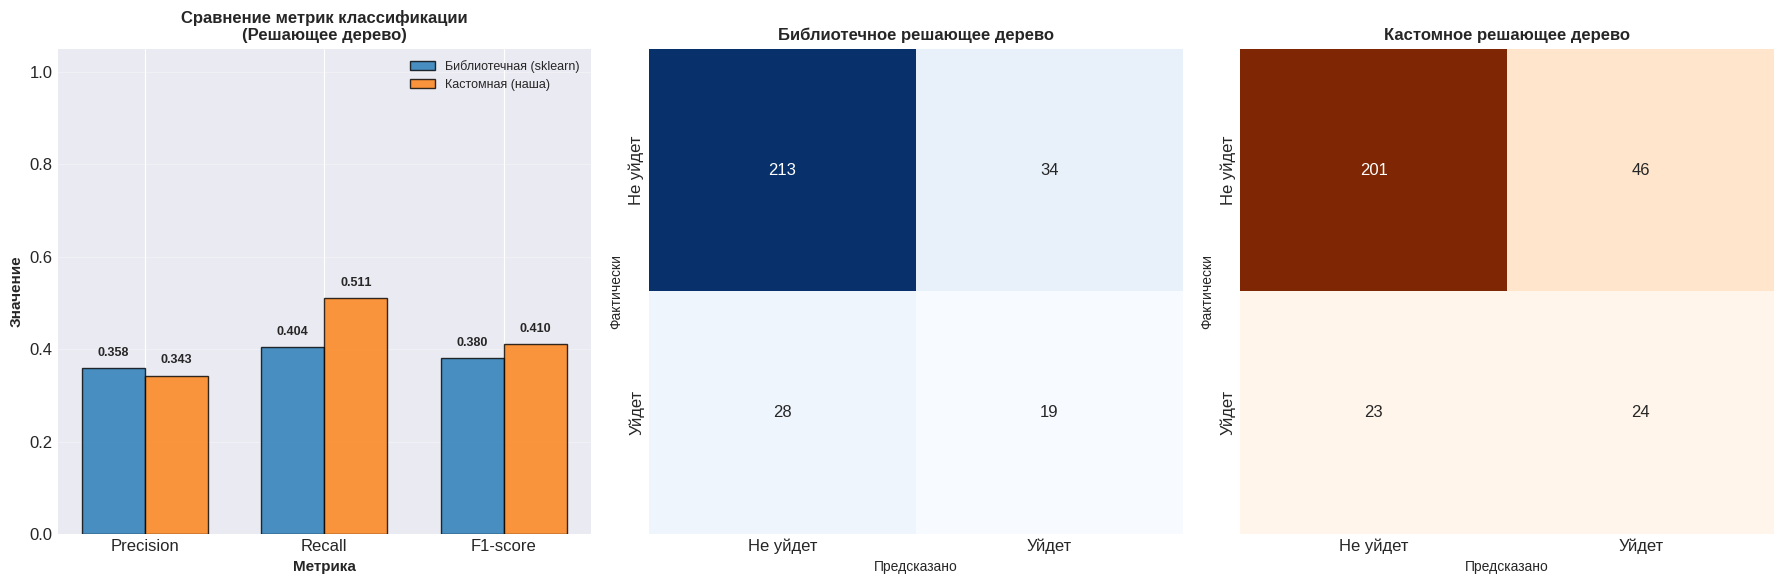


--- 14.3 Сравнение улучшенных регрессионных моделей (Решающее дерево) ---

СРАВНЕНИЕ МЕТРИК:
-------------------------------------------------------------------------------------
Метрика              Библиотечная    Кастомная      
-------------------------------------------------------------------------------------
RMSE                 $176,487        $187,872       
MAE                  $92,346         $103,957       
MAPE (%)             16.05%          18.38%         
R²                   0.7940          0.7665         

--- 14.4 Визуализация сравнения регрессионных моделей (Решающее дерево) ---


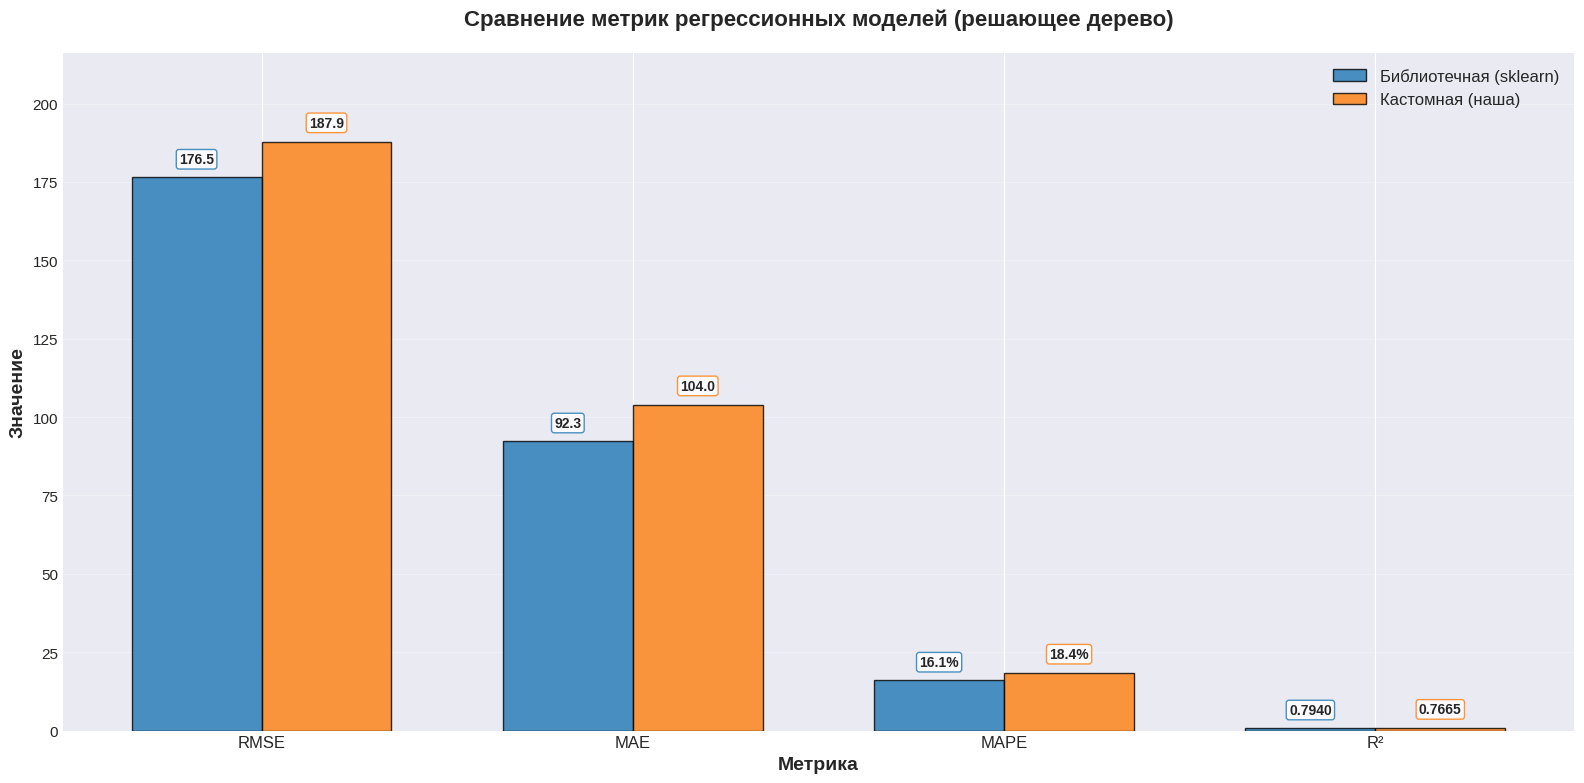

In [59]:
# Ячейка 14: СРАВНЕНИЕ УЛУЧШЕННЫХ МОДЕЛЕЙ РЕШАЮЩИХ ДЕРЕВЬЕВ

# 14.1 Сравнение улучшенных классификационных моделей (решающее дерево)
print("\n--- 14.1 Сравнение улучшенных классификационных моделей (Решающее дерево) ---")

print("\nСРАВНЕНИЕ МЕТРИК:")
print("-" * 85)
print(f"{'Метрика':<20} {'Библиотечная':<15} {'Кастомная':<15}")
print("-" * 85)

# Вычисляем метрики для сравнения
for metric_name, lib_val, custom_val in [
    ("F1-score", f1_impove, best_result['f1']),
    ("Precision", precision_impove, best_result['precision']),
    ("Recall", recall_impove, best_result['recall']),
    ("Accuracy", accuracy_impove, best_result['accuracy']),
]:
    
    print(f"{metric_name:<20} {lib_val:<15.4f} {custom_val:<15.4f}")

print("\nМАТРИЦЫ ОШИБОК:")
print(f"Библиотечная:")
print(f"  TN={tn_impove}, FP={fp_impove}, FN={fn_impove}, TP={tp_impove}")
print(f"  (Ложные срабатывания: {fp_impove}, Пропуски: {fn_impove})")

print(f"\nКастомная:")
print(f"  TN={best_result['tn']}, FP={best_result['fp']}, FN={best_result['fn']}, TP={best_result['tp']}")
print(f"  (Ложные срабатывания: {best_result['fp']}, Пропуски: {best_result['fn']})")

# Анализ улучшений
print("\nАНАЛИЗ УЛУЧШЕНИЙ:")
improvement_tp = best_result['tp'] - tp_impove
improvement_fn = fn_impove - best_result['fn']
improvement_fp = fp_impove - best_result['fp']
improvement_tn = best_result['tn'] - tn_impove

print(f"  • Правильных предсказаний класса 1 (TP): {'+' if improvement_tp > 0 else ''}{improvement_tp}")
print(f"  • Меньше пропусков (FN): {'+' if improvement_fn > 0 else ''}{improvement_fn}")
print(f"  • Меньше ложных срабатываний (FP): {'+' if improvement_fp > 0 else ''}{improvement_fp}")
print(f"  • Больше правильных отрицаний (TN): {'+' if improvement_tn > 0 else ''}{improvement_tn}")

# 14.2 Визуализация сравнения классификационных моделей (решающее дерево)
print("\n--- 14.2 Визуализация сравнения классификационных моделей (Решающее дерево) ---")

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# График 1: Сравнение метрик
metrics_class = ['Precision', 'Recall', 'F1-score']
lib_vals_class = [precision_impove, recall_impove, f1_impove]
custom_vals_class = [best_result['precision'], 
                     best_result['recall'], best_result['f1']]

x = np.arange(len(metrics_class))
width = 0.35

bars1 = axes[0].bar(x - width/2, lib_vals_class, width, label='Библиотечная (sklearn)', 
                   color='#1f77b4', alpha=0.8, edgecolor='black')
bars2 = axes[0].bar(x + width/2, custom_vals_class, width, label='Кастомная (наша)', 
                   color='#ff7f0e', alpha=0.8, edgecolor='black')

axes[0].set_xlabel('Метрика', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Значение', fontsize=11, fontweight='bold')
axes[0].set_title('Сравнение метрик классификации\n(Решающее дерево)', fontsize=12, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics_class)
axes[0].legend(fontsize=9)
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].set_ylim(0, 1.05)

# Добавляем значения на столбцы
for i, (lib_val, custom_val) in enumerate(zip(lib_vals_class, custom_vals_class)):
    axes[0].text(i - width/2, lib_val + 0.02, f'{lib_val:.3f}', 
                ha='center', va='bottom', fontsize=9, fontweight='bold')
    axes[0].text(i + width/2, custom_val + 0.02, f'{custom_val:.3f}', 
                ha='center', va='bottom', fontsize=9, fontweight='bold')

# График 2: Сравнение матриц ошибок (библиотечная)
sns.heatmap([[tn_impove, fp_impove], [fn_impove, tp_impove]], annot=True, fmt='d', cmap='Blues', 
            ax=axes[1], cbar=False,
            xticklabels=['Не уйдет', 'Уйдет'], 
            yticklabels=['Не уйдет', 'Уйдет'])
axes[1].set_title('Библиотечное решающее дерево', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Фактически', fontsize=10)
axes[1].set_xlabel('Предсказано', fontsize=10)

# График 3: Сравнение матриц ошибок (кастомная)
sns.heatmap([[best_result['tn'], best_result['fp']], 
             [best_result['fn'], best_result['tp']]], 
            annot=True, fmt='d', cmap='Oranges', ax=axes[2], cbar=False,
            xticklabels=['Не уйдет', 'Уйдет'], 
            yticklabels=['Не уйдет', 'Уйдет'])
axes[2].set_title(f'Кастомное решающее дерево', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Фактически', fontsize=10)
axes[2].set_xlabel('Предсказано', fontsize=10)

plt.tight_layout()
plt.show()

# 14.3 Сравнение улучшенных регрессионных моделей (решающее дерево)
print("\n--- 14.3 Сравнение улучшенных регрессионных моделей (Решающее дерево) ---")

print("\nСРАВНЕНИЕ МЕТРИК:")
print("-" * 85)
print(f"{'Метрика':<20} {'Библиотечная':<15} {'Кастомная':<15}")
print("-" * 85)

# Проверяем доступность переменных перед сравнением
available_metrics = []

# Проверяем RMSE
if 'rmse_improved' in locals() and 'best_result_reg' in locals():
    available_metrics.append(("RMSE", rmse_improved, best_result_reg['rmse'], True, False))

# Проверяем MAE
if 'mae_improved' in locals() and 'best_result_reg' in locals():
    available_metrics.append(("MAE", mae_improved, best_result_reg['mae'], True, False))

# Проверяем MAPE
if 'mape_improved' in locals() and 'best_result_reg' in locals():
    available_metrics.append(("MAPE (%)", mape_improved*100, best_result_reg['mape'], False, True))

# Проверяем R²
if 'r2_improved' in locals() and 'best_result_reg' in locals():
    available_metrics.append(("R²", r2_improved, best_result_reg['r2'], False, False))

for metric_name, lib_val, custom_val, is_dollar, is_percent in available_metrics:
    if is_dollar:
        lib_str = f"${lib_val:,.0f}"
        custom_str = f"${custom_val:,.0f}"
        print(f"{metric_name:<20} {lib_str:<15} {custom_str:<15}")
    
    elif is_percent:
        lib_str = f"{lib_val:.2f}%"
        custom_str = f"{custom_val:.2f}%"
        print(f"{metric_name:<20} {lib_str:<15} {custom_str:<15}")
    
    else:
        lib_str = f"{lib_val:.4f}"
        custom_str = f"{custom_val:.4f}"
        print(f"{metric_name:<20} {lib_str:<15} {custom_str:<15}")


# 14.4 Визуализация сравнения регрессионных моделей (решающее дерево)
print("\n--- 14.4 Визуализация сравнения регрессионных моделей (Решающее дерево) ---")

plt.figure(figsize=(16, 8))

# Собираем доступные метрики для сравнения
available_metrics_for_plot = []
lib_vals_for_plot = []
custom_vals_for_plot = []
lib_labels_for_plot = []  # Для форматированных значений библиотечной модели
custom_labels_for_plot = []  # Для форматированных значений кастомной модели

# RMSE
if 'rmse_improved' in locals() and 'best_result_reg' in locals():
    available_metrics_for_plot.append('RMSE')
    lib_vals_for_plot.append(rmse_improved/1000)  # в тыс. $
    custom_vals_for_plot.append(best_result_reg['rmse']/1000)
    lib_labels_for_plot.append(f'{rmse_improved/1000:,.1f}')
    custom_labels_for_plot.append(f'{best_result_reg["rmse"]/1000:,.1f}')

# MAE
if 'mae_improved' in locals() and 'best_result_reg' in locals():
    available_metrics_for_plot.append('MAE')
    lib_vals_for_plot.append(mae_improved/1000)  # в тыс. $
    custom_vals_for_plot.append(best_result_reg['mae']/1000)
    lib_labels_for_plot.append(f'{mae_improved/1000:,.1f}')
    custom_labels_for_plot.append(f'{best_result_reg["mae"]/1000:,.1f}')

# MAPE
if 'mape_improved' in locals() and 'best_result_reg' in locals():
    available_metrics_for_plot.append('MAPE')
    lib_vals_for_plot.append(mape_improved*100)  # в процентах
    custom_vals_for_plot.append(best_result_reg['mape'])
    lib_labels_for_plot.append(f'{mape_improved*100:.1f}%')
    custom_labels_for_plot.append(f'{best_result_reg["mape"]:.1f}%')

# R²
if 'r2_improved' in locals() and 'best_result_reg' in locals():
    available_metrics_for_plot.append('R²')
    lib_vals_for_plot.append(r2_improved)
    custom_vals_for_plot.append(best_result_reg['r2'])
    lib_labels_for_plot.append(f'{r2_improved:.4f}')
    custom_labels_for_plot.append(f'{best_result_reg["r2"]:.4f}')

# Создаем график
if available_metrics_for_plot:
    x = np.arange(len(available_metrics_for_plot))
    width = 0.35

    bars1 = plt.bar(x - width/2, lib_vals_for_plot, width, label='Библиотечная (sklearn)', 
                   color='#1f77b4', alpha=0.8, edgecolor='black')
    bars2 = plt.bar(x + width/2, custom_vals_for_plot, width, label='Кастомная (наша)', 
                   color='#ff7f0e', alpha=0.8, edgecolor='black')

    # Добавляем цифры над барами для библиотечной модели
    for bar, value, label in zip(bars1, lib_vals_for_plot, lib_labels_for_plot):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + max(lib_vals_for_plot)*0.02,
                label, ha='center', va='bottom', fontsize=10, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8, edgecolor='#1f77b4'))

    # Добавляем цифры над барами для кастомной модели
    for bar, value, label in zip(bars2, custom_vals_for_plot, custom_labels_for_plot):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + max(custom_vals_for_plot)*0.02,
                label, ha='center', va='bottom', fontsize=10, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8, edgecolor='#ff7f0e'))

    plt.xlabel('Метрика', fontsize=14, fontweight='bold')
    plt.ylabel('Значение', fontsize=14, fontweight='bold')
    plt.title('Сравнение метрик регрессионных моделей (решающее дерево)', fontsize=16, fontweight='bold', pad=20)
    plt.xticks(x, available_metrics_for_plot, fontsize=12)
    plt.yticks(fontsize=11)
    plt.legend(fontsize=12, loc='upper right')
    plt.grid(True, alpha=0.3, axis='y')

    # Настраиваем отступ сверху
    max_value = max(max(lib_vals_for_plot), max(custom_vals_for_plot))
    plt.ylim(0, max_value * 1.15)  # Увеличиваем верхнюю границу на 15%
else:
    plt.text(0.5, 0.5, 'Данные для сравнения\nнедоступны', 
             ha='center', va='center', transform=plt.gca().transAxes, fontsize=16)
    plt.title('Данные для сравнения регрессионных моделей недоступны', fontsize=14, pad=20)

plt.tight_layout()
plt.show()


### Выводы

Кастомные реализации показывают конкурентные результаты в классификации, особенно по сбалансированным метрикам (F1-score, Recall). Однако библиотечные решения превосходят в регрессии по точности и стабильности. Для практического применения оптимально использовать библиотечные модели как базовый подход, дополняя их кастомными настройками для специфических задач, где требуются особые балансы метрик.